## Baseline Model

In [2]:
import pandas as pd
import numpy as np
import simpy
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import logging

from capacity_generator import CataractCapacityGenerator
from patient_generator import CataractPatientGenerator
from rtt_generator import RTTWaitTimeGenerator
from service_time_generator import CataractServiceTimeGenerator
from arrival_generator import HealthcareArrivalGenerator
from provider import CataractProviderGenerator

@dataclass
class Patient:
    """Patient data structure"""
    patient_id: str
    referral_date: pd.Timestamp
    surgery_target_date: pd.Timestamp  # RTT
    priority: int
    priority_name: str
    hrg_code: str
    hrg_description: str  
    complexity_level: int 
    complexity_category: str
    
    # Surgery times
    surgery_duration: float
    preop_assessment: float
    postop_1week: float
    postop_6week: float
    theatre_setup: float
    theatre_changeover: float
    total_theatre_time: float
    total_episode_time: float
    base_surgery_duration_minutes: int 
    
    # Provider information
    assessment_provider: str
    surgery_provider: str
    is_independent_sector: bool
    provider_loyalty: bool  
    provider_type: str  
    estimated_daily_capacity: float
    
    # Bilateral info
    is_bilateral: bool = False
    inter_eye_interval: Optional[int] = None
    bilateral_pair: Optional[str] = None
    is_second_eye: bool = False
    
    # Simulation state
    actual_surgery_date: Optional[pd.Timestamp] = None
    actual_wait_days: Optional[int] = None
    served_bucket: Optional[str] = None
    completed: bool = False
    cancelled: bool = False
    
    def days_waiting(self, current_date: pd.Timestamp) -> int:
        """Calculate days waiting from referral to current date"""
        return (current_date - self.referral_date).days
    
    def days_until_target(self, current_date: pd.Timestamp) -> int:
        """Calculate days until RTT target is breached"""
        return (self.surgery_target_date - current_date).days
    
    def is_overdue(self, current_date: pd.Timestamp) -> bool:
        """Check if patient is past their RTT target"""
        return current_date >= self.surgery_target_date
    
    def within_18_weeks(self) -> bool:
        """Check if completed within 18 weeks (126 days)"""
        if self.actual_wait_days is not None:
            return self.actual_wait_days <= 126
        return (self.surgery_target_date - self.referral_date).days <= 126


class CataractSimulationSimPy:
    """
    SimPy-based cataract surgery simulation with RTT-SLA scheduling, complexity integration and provider pathways
    """
    
    def __init__(self, start_date='2024-01-01', random_seed=42):
        # Set random seed
        np.random.seed(random_seed)
        self.random_seed = random_seed
        
        # Initialize SimPy environment
        self.env = simpy.Environment()
        
        # Initialize generators 
        self.init_generators()
        
        # Simulation parameters
        self.start_date = pd.Timestamp(start_date)
        self.min_lead_time_days = 14
        self.early_pull_window_days = 28
        self.early_pull_fraction = 0.15
        
        # Capacity parameters
        self.capacity_disruption_mean = 0.92
        self.capacity_disruption_sd = 0.025
        
        # Scheduling parameters
        self.frac_at_risk = 0.25
        self.frac_due = 0.35
        self.wait_threshold_days = 126  # 18 weeks
        self.compliance_target = 0.69
        
        # State tracking
        self.patients = []
        self.completed_patients = []
        self.daily_stats = []
        self.patient_counter = 0
        self.daily_capacity = {}
        self.daily_arrivals_schedule = {}
        self.measurement_start = None
        
        # Provider tracking
        self.provider_stats = defaultdict(lambda: {
            'total_assessments': 0,
            'total_surgeries': 0,
            'total_patients': 0,
            'avg_wait_days': 0,
            'rtt_compliance': 0,
            'is_independent': False,
            'estimated_capacity': 0
        })
        
        self.waiting_queue = deque()
        
        # Setup capacity
        self.setup_yearly_capacity(2024)
        
    def init_generators(self):
        """Initializing parameter generators"""
        self.capacity_gen = CataractCapacityGenerator()
        self.patient_gen = CataractPatientGenerator(random_seed=self.random_seed)
        self.rtt_gen = RTTWaitTimeGenerator()
        self.service_gen = CataractServiceTimeGenerator()
        self.arrival_gen = HealthcareArrivalGenerator()
        self.arrival_gen.set_random_seed(self.random_seed)
        self.provider_gen = CataractProviderGenerator()
        
    
    def setup_yearly_capacity(self, year: int):
        """Setup daily capacity for the year"""
        print(f"Setting up capacity for {year}")
        total_capacity = 0
        capacity_days = 0
        
        for month in range(1, 13):
            monthly_schedule = self.capacity_gen.generate_monthly_schedule(month, year)
            for _, row in monthly_schedule.iterrows():
                date_key = row['date'].date()
                base_capacity = row['capacity']
                # Apply calibration factor
                realistic_capacity = max(0, int(base_capacity * 0.80))
                self.daily_capacity[date_key] = realistic_capacity
                
                if realistic_capacity > 0:
                    capacity_days += 1
                    total_capacity += realistic_capacity
        
        avg_capacity = total_capacity / capacity_days if capacity_days > 0 else 0
        print(f"Capacity setup: {capacity_days} operating days, avg {avg_capacity:.1f} surgeries/day")
    
    def setup_arrival_schedule(self, duration_days: int, backlog_days: int, method: str, warmup_days: int):
        """Setup arrival schedule matching original implementation"""
        total_days = backlog_days + warmup_days + duration_days
        schedule_start = self.start_date - pd.Timedelta(days=(backlog_days + warmup_days))

        print(f"Generating arrivals using '{method}' method")
        arrival_ts = self.arrival_gen.generate_arrivals_time_series(
            start_date=schedule_start.strftime('%Y-%m-%d'),
            num_days=total_days,
            method=method
        )

        self.daily_arrivals_schedule = {}
        if len(arrival_ts) > 0:
            daily_counts = arrival_ts.groupby('date').size().to_dict()
            current = schedule_start
            for _ in range(total_days):
                self.daily_arrivals_schedule[current.date()] = int(daily_counts.get(current.date(), 0))
                current += pd.Timedelta(days=1)
        else:
            current = schedule_start
            for _ in range(total_days):
                self.daily_arrivals_schedule[current.date()] = int(self.arrival_gen.get_expected_daily_arrivals(current.weekday()))
                current += pd.Timedelta(days=1)

        total_arrivals = sum(self.daily_arrivals_schedule.values())
        print(f"Arrivals: {total_arrivals:,} over {total_days} days (avg {total_arrivals/total_days:.1f}/day)")
    
    def create_patient(self, referral_date: pd.Timestamp) -> Patient:
        """Create a new patient with provider information"""
        self.patient_counter += 1
        patient_id = f"P{self.patient_counter:06d}"
        
        # Generate patient data
        pdata = self.patient_gen.generate_patient()
        
        # Generate provider pathway
        provider_pathway = self.provider_gen.generate_complete_pathway()
        
        # Bilateral surgery
        is_bilateral = np.random.random() < 0.398
        inter_eye_interval = max(30, int(np.random.lognormal(3.7, 1.2))) if is_bilateral else None
        
        # RTT target
        rtt_wait = self.rtt_gen.generate_rtt_wait(
            priority=pdata['priority'],
            hrg=pdata['hrg_code'],
            referral_month=referral_date.month
        )
        surgery_target_date = referral_date + pd.Timedelta(days=rtt_wait)
        
        # Service times
        etimes = self.service_gen.generate_complete_episode_times(
            hrg_code=pdata['hrg_code'],
            complexity=pdata['complexity_category'].lower(),
            activity_type='Day Case'
        )
        
        # Create patient instance
        patient = Patient(
            patient_id=patient_id,
            referral_date=referral_date,
            surgery_target_date=surgery_target_date,
            priority=pdata['priority'],
            priority_name=pdata['priority_name'],
            hrg_code=pdata['hrg_code'],
            hrg_description=pdata['hrg_description'],
            complexity_level=pdata['complexity_level'],
            complexity_category=pdata['complexity_category'],
            surgery_duration=etimes['surgery_duration'],
            preop_assessment=etimes['preop_assessment'],
            postop_1week=etimes['postop_1week'],
            postop_6week=etimes['postop_6week'],
            theatre_setup=etimes['theatre_setup'],
            theatre_changeover=etimes['theatre_changeover'],
            total_theatre_time=etimes['total_theatre_time'],
            total_episode_time=etimes['total_episode_time'],
            base_surgery_duration_minutes=pdata['base_surgery_duration_minutes'],
            assessment_provider=provider_pathway['assessment_provider'],
            surgery_provider=provider_pathway['surgery_provider'],
            is_independent_sector=provider_pathway['is_independent_sector'],
            provider_loyalty=provider_pathway['provider_loyalty'],
            provider_type=provider_pathway['provider_type'],
            estimated_daily_capacity=provider_pathway['estimated_daily_capacity'],
            is_bilateral=is_bilateral,
            inter_eye_interval=inter_eye_interval
        )
        
        self.update_provider_stats(patient)
        
        return patient
    
    def update_provider_stats(self, patient: Patient):
        """Tracking provider statistics"""
        # Assessment provider stats
        self.provider_stats[patient.assessment_provider]['total_assessments'] += 1
        self.provider_stats[patient.assessment_provider]['is_independent'] = patient.is_independent_sector
        
        # Surgery provider stats 
        self.provider_stats[patient.surgery_provider]['total_surgeries'] += 1
        self.provider_stats[patient.surgery_provider]['total_patients'] += 1
        self.provider_stats[patient.surgery_provider]['is_independent'] = patient.is_independent_sector
        self.provider_stats[patient.surgery_provider]['estimated_capacity'] = patient.estimated_daily_capacity
    
    def patient_arrival_process(self, backlog_days: int, warmup_days: int, duration_days: int):
        """SimPy process for patient arrivals - generates backlog then continues with scheduled arrivals"""
        # Generate backlog patients
        backlog_start = -(backlog_days + warmup_days)
        backlog_count = 0
        
        for day_offset in range(backlog_start, -warmup_days):
            arrival_date = self.start_date + pd.Timedelta(days=day_offset)
            daily_arrivals = self.daily_arrivals_schedule.get(arrival_date.date(), 
                                                            self.arrival_gen.get_expected_daily_arrivals(arrival_date.weekday()))
            
            for _ in range(daily_arrivals):
                patient = self.create_patient(arrival_date)
                self.patients.append(patient)
                self.waiting_queue.append(patient)
                backlog_count += 1
        
        print(f"Created {backlog_count} backlog patients")
        
        # Continue arrivals during simulation period
        for day in range(warmup_days + duration_days):
            arrival_date = self.start_date + pd.Timedelta(days=day - warmup_days)
            daily_arrivals = self.daily_arrivals_schedule.get(arrival_date.date(),
                                                            self.arrival_gen.get_expected_daily_arrivals(arrival_date.weekday()))
            
            for _ in range(daily_arrivals):
                patient = self.create_patient(arrival_date)
                self.patients.append(patient)
                self.waiting_queue.append(patient)
                
                # Log first few patients with provider info
                if len(self.patients) <= 5:
                    print(f"Patient {patient.patient_id}: Priority={patient.priority}, "
                          f"HRG={patient.hrg_code}, Complexity={patient.complexity_level} ({patient.complexity_category}), "
                          f"Assessment={patient.assessment_provider[:20]}, "
                          f"Surgery={patient.surgery_provider[:20]}, "
                          f"Provider loyalty={patient.provider_loyalty}, "
                          f"Sector={patient.provider_type}")
            
            # Wait until next day
            yield self.env.timeout(1)
    
    def surgery_scheduling_process(self, warmup_days: int):
        """SimPy process for daily surgery scheduling"""
        measurement_start_day = warmup_days
        self.measurement_start = self.start_date  # Setting measurement start
        
        while True:
            current_day = self.env.now
            current_date = self.start_date + pd.Timedelta(days=current_day - warmup_days)
            
            # today's capacity
            base_capacity = self.daily_capacity.get(current_date.date(), 0)
            
            if base_capacity > 0:
                stats = self.schedule_daily_surgeries(current_date, base_capacity)
                stats['arrivals'] = self.daily_arrivals_schedule.get(current_date.date(), 0)
                
                # Recording statistics if in measurement period
                if current_day >= measurement_start_day:
                    self.daily_stats.append(stats)
                
                # Log progress with provider info 
                if current_day >= measurement_start_day and (current_day - measurement_start_day) % 30 == 0:
                    day_measured = current_day - measurement_start_day
                    # Show provider distribution of ready patients
                    ready_patients = self._get_eligible_patients(current_date)
                    provider_dist = {}
                    for p in ready_patients:
                        short_name = p.surgery_provider.split()[0] if p.surgery_provider else 'UNK'
                        provider_dist[short_name] = provider_dist.get(short_name, 0) + 1
                    
                    provider_str = ', '.join([f"{k}:{v}" for k, v in sorted(provider_dist.items())])
                    print(f"Day {day_measured}: {current_date.strftime('%Y-%m-%d')}, "
                          f"Patients ready for surgery: {stats['patients_ready']}, "
                          f"Providers: [{provider_str}], "
                          f"Capacity: {stats['effective_capacity']}, "
                          f"Completed: {stats['patients_completed']}")
            
            yield self.env.timeout(1)  # Wait until next day
    
    def schedule_daily_surgeries(self, date: pd.Timestamp, base_capacity: int) -> Dict:
        """Schedule surgeries for a given day"""
        # Apply capacity disruption
        effective_capacity = self._effective_capacity(base_capacity)
        
        if effective_capacity == 0:
            return {
                'date': date, 'capacity': 0, 'effective_capacity': 0,
                'patients_ready': 0, 'patients_completed': 0, 'patients_cancelled': 0,
                'total_surgery_time': 0, 'total_theatre_time': 0,
                'utilization': 0.0, 'avg_surgery_time': 0.0, 'queue_overflow': 0,
                'complexity_distribution': {}, 'provider_distribution': {}
            }
        
        # eligible patients for surgery
        eligible_patients = self._get_eligible_patients(date)
        
        # Categorize patients into buckets
        due, at_risk, near_due, fifo_early = self._categorize_patients(eligible_patients, date)
        
        # Schedule patients according to priority buckets
        scheduled_patients = self._select_patients_for_surgery(
            due, at_risk, near_due, fifo_early, effective_capacity
        )
        
        # Perform surgeries, track complexity and providers
        completed_count = 0
        total_surgery_time = 0
        total_theatre_time = 0
        complexity_completed = {}
        provider_completed = {}
        
        for patient in scheduled_patients:
            self._complete_surgery(patient, date)
            completed_count += 1
            total_surgery_time += patient.surgery_duration
            total_theatre_time += patient.total_theatre_time
            
            # Track complexity distribution
            complexity_completed[patient.complexity_level] = complexity_completed.get(patient.complexity_level, 0) + 1
            
            # Track provider distribution
            provider_short = patient.surgery_provider.split()[0] if patient.surgery_provider else 'UNK'
            provider_completed[provider_short] = provider_completed.get(provider_short, 0) + 1
            
            # Handle bilateral cases
            if patient.is_bilateral and patient.inter_eye_interval:
                second_eye = self._schedule_bilateral_surgery(patient)
                if second_eye:
                    self.patients.append(second_eye)
                    self.waiting_queue.append(second_eye)
        
        utilization = min(100.0, (total_theatre_time / (effective_capacity * 60.0)) * 100.0)
        avg_surgery_time = total_surgery_time / completed_count if completed_count > 0 else 0.0
        
        return {
            'date': date,
            'capacity': base_capacity,
            'effective_capacity': effective_capacity,
            'patients_ready': len(due),
            'patients_completed': completed_count,
            'patients_cancelled': 0,
            'total_surgery_time': total_surgery_time,
            'total_theatre_time': total_theatre_time,
            'utilization': utilization,
            'avg_surgery_time': avg_surgery_time,
            'queue_overflow': max(0, len(due) - effective_capacity),
            'complexity_distribution': complexity_completed,
            'provider_distribution': provider_completed
        }
    
    def _effective_capacity(self, base_capacity: int) -> int:
        """Apply capacity disruption factor"""
        if base_capacity <= 0:
            return 0
        
        factor = np.clip(
            np.random.normal(self.capacity_disruption_mean, self.capacity_disruption_sd),
            0.75, 1.00
        )
        return max(1, int(np.floor(base_capacity * factor)))
    
    def _get_eligible_patients(self, date: pd.Timestamp) -> List[Patient]:
        """Get patients eligible for surgery (meeting lead time requirement)"""
        min_lead = pd.Timedelta(days=self.min_lead_time_days)
        eligible = []
        
        for patient in list(self.waiting_queue):
            if (not patient.completed and not patient.cancelled and 
                date >= patient.referral_date + min_lead):
                eligible.append(patient)
        
        return eligible
    
    def _categorize_patients(self, eligible: List[Patient], date: pd.Timestamp) -> Tuple[List, List, List, List]:
        """Categorize patients into scheduling buckets"""
        due = []
        at_risk = []
        near_due = []
        fifo_early = []
        taken = set()
        
        # 1. Due/overdue patients
        for patient in eligible:
            if patient.is_overdue(date):
                due.append(patient)
                taken.add(patient.patient_id)
        
        # 2. At-risk patients (115-125 days waiting)
        for patient in eligible:
            if patient.patient_id in taken:
                continue
            waited = patient.days_waiting(date)
            if 115 <= waited < 126:
                at_risk.append(patient)
                taken.add(patient.patient_id)
        
        # 3. Near-due patients
        for patient in eligible:
            if patient.patient_id in taken:
                continue
            days_to_target = patient.days_until_target(date)
            if 0 <= days_to_target <= self.early_pull_window_days:
                near_due.append(patient)
                taken.add(patient.patient_id)
        
        # 4. Everyone else 
        for patient in eligible:
            if patient.patient_id not in taken:
                fifo_early.append(patient)
        
        # Sort within buckets (FIFO within priority, but also considering complexity for tie-breaking)
        def fifo_key(p):
            return (-p.priority, p.referral_date, p.complexity_level)  # Higher complexity slightly prioritized
        
        due.sort(key=fifo_key)
        at_risk.sort(key=fifo_key)
        near_due.sort(key=fifo_key)
        fifo_early.sort(key=fifo_key)
        
        return due, at_risk, near_due, fifo_early
    
    def _select_patients_for_surgery(self, due: List, at_risk: List, near_due: List, 
                                   fifo_early: List, effective_capacity: int) -> List[Patient]:
        """Select patients for surgery based on capacity allocation"""
        scheduled = []
        
        # 1. Due/overdue first
        cap_due = min(int(round(self.frac_due * effective_capacity)), effective_capacity)
        take = min(len(due), cap_due)
        for i in range(take):
            due[i].served_bucket = 'due'
            scheduled.append(due[i])
        
        # 2. At-risk second
        remaining = effective_capacity - len(scheduled)
        if remaining > 0:
            cap_risk = min(int(round(self.frac_at_risk * effective_capacity)), remaining)
            take = min(len(at_risk), cap_risk)
            for i in range(take):
                at_risk[i].served_bucket = 'at_risk'
                scheduled.append(at_risk[i])
        
        # 3. Near-due (limited early pull)
        remaining = effective_capacity - len(scheduled)
        if remaining > 0 and near_due:
            quota = min(int(self.early_pull_fraction * effective_capacity), remaining, len(near_due))
            for i in range(quota):
                near_due[i].served_bucket = 'near_due'
                scheduled.append(near_due[i])
        
        # 4. Fill remaining with FIFO
        remaining = effective_capacity - len(scheduled)
        if remaining > 0 and fifo_early:
            take = min(remaining, len(fifo_early))
            for i in range(take):
                fifo_early[i].served_bucket = 'fifo'
                scheduled.append(fifo_early[i])
        
        return scheduled
    
    def _complete_surgery(self, patient: Patient, date: pd.Timestamp):
        """Complete surgery for a patient"""
        patient.completed = True
        patient.actual_surgery_date = date
        patient.actual_wait_days = patient.days_waiting(date)
        
        # Remove from waiting queue
        if patient in self.waiting_queue:
            self.waiting_queue.remove(patient)
        
        self.completed_patients.append(patient)
        
        # Update provider stats with completion data
        if patient.surgery_provider in self.provider_stats:
            stats = self.provider_stats[patient.surgery_provider]
            # Update running average of wait times
            current_avg = stats['avg_wait_days']
            current_count = stats['total_patients']
            if current_count > 0:
                stats['avg_wait_days'] = ((current_avg * (current_count - 1)) + patient.actual_wait_days) / current_count
            else:
                stats['avg_wait_days'] = patient.actual_wait_days
            
            # Update RTT compliance
            within_18_weeks = patient.within_18_weeks()
            current_compliance = stats['rtt_compliance']
            if current_count > 0:
                stats['rtt_compliance'] = ((current_compliance * (current_count - 1)) + (1 if within_18_weeks else 0)) / current_count
            else:
                stats['rtt_compliance'] = 1 if within_18_weeks else 0
    
    def _schedule_bilateral_surgery(self, patient: Patient) -> Optional[Patient]:
        """Schedule second eye surgery for bilateral patient"""
        if not patient.is_bilateral or not patient.inter_eye_interval:
            return None
        
        second_referral = patient.actual_surgery_date + pd.Timedelta(days=patient.inter_eye_interval)
        second_eye = self.create_patient(second_referral)
        second_eye.patient_id = f"{patient.patient_id}_R2"
        second_eye.is_bilateral = False
        second_eye.bilateral_pair = patient.patient_id
        second_eye.is_second_eye = True
        
        return second_eye
    
    def run_simulation(self, duration_days=90, arrival_method='autocorrelated', warmup_days=180, backlog_days=60):
        """Run the SimPy simulation with full validation setup"""
        print("Starting CALIBRATED NHS SimPy Cataract Surgery Simulation WITH COMPLEXITY AND PROVIDERS...")
        print(f"Duration: {duration_days} days, Start: {self.start_date.strftime('%Y-%m-%d')}")
        print(f"Method: {arrival_method}, Backlog: {backlog_days} days, Warm-up: {warmup_days} days")
        
        # Setup arrival schedule
        self.setup_arrival_schedule(duration_days, backlog_days, arrival_method, warmup_days)
        
        # Start the processes
        self.env.process(self.patient_arrival_process(backlog_days, warmup_days, duration_days))
        self.env.process(self.surgery_scheduling_process(warmup_days))
        
        # Run simulation
        total_days = warmup_days + duration_days
        self.env.run(until=total_days)
        
        print("SimPy simulation completed.")
        
        return self.get_simulation_summary()
    
    def get_simulation_summary(self) -> Dict:
        """Generate comprehensive simulation summary"""
        all_patients = self.patients
        measured_start = self.measurement_start or self.start_date

        # Filter to measurement period patients
        completed = [p for p in all_patients if p.completed and p.actual_surgery_date is not None and p.actual_surgery_date >= measured_start]
        pending = [p for p in all_patients if not p.completed and not p.cancelled]

        # Basic metrics
        total_arrivals = sum(d.get('arrivals', 0) for d in self.daily_stats)
        total_cap_plan = sum(d['capacity'] for d in self.daily_stats)
        total_cap_eff = sum(d['effective_capacity'] for d in self.daily_stats)
        total_completed = sum(d['patients_completed'] for d in self.daily_stats)

        # Wait time analysis
        waits = [p.actual_wait_days for p in completed if p.actual_wait_days is not None]
        if waits:
            rtt_compliance = sum(1 for w in waits if w <= 126) / len(waits) * 100
            mean_wait = float(np.mean(waits))
            median_wait = float(np.median(waits))
        else:
            rtt_compliance = 0.0
            mean_wait = 0.0
            median_wait = 0.0

        # FIFO Fairness Analysis
        fifo_violations, total_pairs = 0, 0
        buckets = defaultdict(list)
        for p in completed:
            buckets[(p.priority, p.served_bucket or 'unknown')].append(p)
        
        for (_, _), group in buckets.items():
            group_sorted_by_done = sorted(group, key=lambda x: x.actual_surgery_date)
            for i in range(len(group_sorted_by_done)):
                for j in range(i+1, len(group_sorted_by_done)):
                    p1, p2 = group_sorted_by_done[i], group_sorted_by_done[j]
                    total_pairs += 1
                    if p1.referral_date > p2.referral_date:
                        fifo_violations += 1
        
        fifo_fairness = (1 - fifo_violations/total_pairs) * 100 if total_pairs > 0 else 100.0

        # Priority distribution
        priority_dist = {}
        for p in all_patients:
            priority_dist[p.priority] = priority_dist.get(p.priority, 0) + 1

        # Bilateral rate
        first_eyes = [p for p in all_patients if not p.is_second_eye]
        bilateral_rate = (sum(1 for p in first_eyes if p.is_bilateral) / len(first_eyes) * 100.0) if first_eyes else 0.0

        # Pending patient wait times
        if self.daily_stats:
            sim_end = self.measurement_start + pd.Timedelta(days=len(self.daily_stats))
        else:
            sim_end = self.start_date
        
        pending_days_waiting = []
        for p in pending:
            days_waiting = (sim_end - p.referral_date).days
            if days_waiting > 0:  # Only include positive wait times
                pending_days_waiting.append(days_waiting)

        # Complexity analysis
        complexity_distribution = {}
        hrg_distribution = {}
        for p in all_patients:
            complexity_distribution[p.complexity_level] = complexity_distribution.get(p.complexity_level, 0) + 1
            hrg_distribution[p.hrg_code] = hrg_distribution.get(p.hrg_code, 0) + 1

        # Provider pathway analysis
        provider_loyalty_count = sum(1 for p in all_patients if p.provider_loyalty)
        provider_loyalty_rate = (provider_loyalty_count / len(all_patients) * 100.0) if all_patients else 0.0
        
        independent_sector_count = sum(1 for p in all_patients if p.is_independent_sector)
        independent_sector_rate = (independent_sector_count / len(all_patients) * 100.0) if all_patients else 0.0
        
        # Top assessment providers
        assessment_provider_dist = {}
        for p in all_patients:
            short_name = p.assessment_provider.split()[0] if p.assessment_provider else 'Unknown'
            assessment_provider_dist[short_name] = assessment_provider_dist.get(short_name, 0) + 1
        
        # Top surgery providers
        surgery_provider_dist = {}
        for p in all_patients:
            short_name = p.surgery_provider.split()[0] if p.surgery_provider else 'Unknown'
            surgery_provider_dist[short_name] = surgery_provider_dist.get(short_name, 0) + 1
        
        # Provider performance analysis (completed patients only)
        provider_performance = {}
        for p in completed:
            if p.surgery_provider not in provider_performance:
                provider_performance[p.surgery_provider] = {
                    'patients': 0,
                    'total_wait': 0,
                    'within_18_weeks': 0,
                    'avg_wait': 0,
                    'compliance': 0
                }
            
            perf = provider_performance[p.surgery_provider]
            perf['patients'] += 1
            perf['total_wait'] += p.actual_wait_days or 0
            if p.within_18_weeks():
                perf['within_18_weeks'] += 1
        
        # Calculate averages
        for provider, perf in provider_performance.items():
            if perf['patients'] > 0:
                perf['avg_wait'] = perf['total_wait'] / perf['patients']
                perf['compliance'] = (perf['within_18_weeks'] / perf['patients']) * 100.0

        return {
            # Original metrics
            'simulation_period': len(self.daily_stats),
            'total_patients': len(all_patients),
            'completed_surgeries': len(completed),
            'pending_surgeries': len(pending),
            'total_arrivals': total_arrivals,
            'avg_daily_arrivals': total_arrivals / len(self.daily_stats) if self.daily_stats else 0.0,
            'total_capacity_planned': total_cap_plan,
            'total_capacity_effective': total_cap_eff,
            'avg_daily_capacity_effective': (total_cap_eff / len([d for d in self.daily_stats if d['effective_capacity'] > 0])) if any(d['effective_capacity'] > 0 for d in self.daily_stats) else 0.0,
            'capacity_utilization': (total_completed / total_cap_eff * 100.0) if total_cap_eff > 0 else 0.0,
            'mean_current_wait': mean_wait,
            'median_current_wait': median_wait,
            'rtt_compliance_pct': rtt_compliance,
            'fifo_fairness_pct': fifo_fairness,
            'pending_days_waiting': float(np.mean(pending_days_waiting)) if pending_days_waiting else 0.0,
            'priority_distribution': priority_dist,
            'bilateral_rate_pct': bilateral_rate,
            'total_queue_overflow': sum(d.get('queue_overflow', 0) for d in self.daily_stats),
            'avg_daily_overflow': float(np.mean([d.get('queue_overflow', 0) for d in self.daily_stats])) if self.daily_stats else 0.0,
            'complexity_distribution': complexity_distribution,
            'hrg_distribution': hrg_distribution,
            # Provider metrics
            'provider_loyalty_rate_pct': provider_loyalty_rate,
            'independent_sector_rate_pct': independent_sector_rate,
            'top_assessment_providers': dict(sorted(assessment_provider_dist.items(), key=lambda x: x[1], reverse=True)[:10]),
            'top_surgery_providers': dict(sorted(surgery_provider_dist.items(), key=lambda x: x[1], reverse=True)[:10]),
            'provider_performance': provider_performance
        }
    
    def print_simulation_summary(self):
        """Print formatted simulation summary with provider section"""
        s = self.get_simulation_summary()
        
        print("Baseline cataract simulation summary")
        print(f"Simulation Period: {s['simulation_period']} days")
        print(f"Total Patients: {s['total_patients']:,}")
        print(f"Completed Surgeries (measured): {s['completed_surgeries']:,}")
        print(f"Pending Surgeries: {s['pending_surgeries']:,}")
        print(f"Average Daily Arrivals: {s['avg_daily_arrivals']:.1f}")
        print(f"Average Daily Effective Capacity: {s['avg_daily_capacity_effective']:.1f}")
        print(f"Capacity Utilization: {s['capacity_utilization']:.1f}%")

        print(f"\nWAIT TIME ANALYSIS (measured window):")
        print(f"Mean Actual Wait: {s['mean_current_wait']:.1f} days")
        print(f"Median Actual Wait: {s['median_current_wait']:.1f} days")
        print(f"18-week Compliance: {s['rtt_compliance_pct']:.1f}%")

        print(f"\nFIFO FAIRNESS (within bucket & priority):")
        print(f"FIFO Adherence: {s['fifo_fairness_pct']:.1f}%")
        print(f"Queue Overflow (due/overdue): {s['avg_daily_overflow']:.1f} patients/day")

        # Complexity section
        print(f"\nCOMPLEXITY DISTRIBUTION:")
        for level in sorted(s['complexity_distribution'].keys()):
            count = s['complexity_distribution'][level]
            pct = count / s['total_patients'] * 100.0
            print(f"  Level {level}: {count:,} ({pct:.1f}%)")

        print(f"\nHRG DISTRIBUTION (Top 5):")
        hrg_sorted = sorted(s['hrg_distribution'].items(), key=lambda x: x[1], reverse=True)[:5]
        for hrg, count in hrg_sorted:
            pct = count / s['total_patients'] * 100.0
            print(f"  {hrg}: {count:,} ({pct:.1f}%)")

        # Provider analysis section
        print(f"Patient continuity rate with same Provider: {s['provider_loyalty_rate_pct']:.1f}% (target: ~95%)")
        print(f"Independent Sector Rate: {s['independent_sector_rate_pct']:.1f}% (target: ~55%)")
        
        print(f"\nTop assessment providers:")
        for i, (provider, count) in enumerate(list(s['top_assessment_providers'].items())[:5], 1):
            pct = count / s['total_patients'] * 100.0
            print(f"  {i}. {provider}: {count:,} ({pct:.1f}%)")
        
        print(f"\nTop surgery providers:")
        for i, (provider, count) in enumerate(list(s['top_surgery_providers'].items())[:5], 1):
            pct = count / s['total_patients'] * 100.0
            print(f"  {i}. {provider}: {count:,} ({pct:.1f}%)")
        
        print(f"\nProvider performance (Top 5 by volume - completed patients only):")
        perf_sorted = sorted([(k, v) for k, v in s['provider_performance'].items() if v['patients'] > 10], 
                           key=lambda x: x[1]['patients'], reverse=True)[:5]
        for provider, perf in perf_sorted:
            short_name = provider.split()[0] if len(provider.split()) > 0 else provider[:20]
            print(f"  {short_name}: {perf['patients']} patients, "
                  f"{perf['avg_wait']:.1f}d avg wait, "
                  f"{perf['compliance']:.1f}% RTT compliance")

        print(f"\nOther metrics:")
        print(f"Bilateral Rate (first eyes): {s['bilateral_rate_pct']:.1f}%")
        print(f"Pending Average Wait: {s['pending_days_waiting']:.1f} days")
        
        # Priority distribution
        priority_names = {1: 'Routine', 2: 'Urgent', 3: 'Emergency'}
        for priority, count in s['priority_distribution'].items():
            pct = count / s['total_patients'] * 100.0
            name = priority_names.get(priority, f'Priority {priority}')
            print(f"  {name}: {count:,} ({pct:.1f}%)")

        # Validation status
        print("\nValidation Status:")
        if 90 <= s['mean_current_wait'] <= 120:
            print(f"  Wait Times: {s['mean_current_wait']:.1f} days (target: ~108)")
        else:
            print(f" Wait Times: {s['mean_current_wait']:.1f} days (target: ~108)")

        if 65 <= s['rtt_compliance_pct'] <= 75:
            print(f" RTT Compliance: {s['rtt_compliance_pct']:.1f}% (target: ~69%)")
        else:
            print(f" RTT Compliance: {s['rtt_compliance_pct']:.1f}% (target: ~69%)")

        if 37 <= s['bilateral_rate_pct'] <= 42:
            print(f" Bilateral Rate: {s['bilateral_rate_pct']:.1f}% (target: ~40%)")
        else:
            print(f" Bilateral Rate: {s['bilateral_rate_pct']:.1f}% (target: ~40%)")

        if s['fifo_fairness_pct'] >= 90:
            print(f" FIFO Fairness: {s['fifo_fairness_pct']:.1f}% (target: >90%)")
        else:
            print(f" FIFO Fairness: {s['fifo_fairness_pct']:.1f}% (target: >90%)")

        # Provider validation
        if 90 <= s['provider_loyalty_rate_pct'] <= 98:
            print(f" Provider Loyalty: {s['provider_loyalty_rate_pct']:.1f}% (target: ~95%)")
        else:
            print(f" Provider Loyalty: {s['provider_loyalty_rate_pct']:.1f}% (target: ~95%)")

        if 50 <= s['independent_sector_rate_pct'] <= 60:
            print(f" Independent Sector: {s['independent_sector_rate_pct']:.1f}% (target: ~55%)")
        else:
            print(f" Independent Sector: {s['independent_sector_rate_pct']:.1f}% (target: ~55%)")


    def export_results(self, filename_prefix='simpy_cataract_simulation_with_providers'):
        """Export simulation results to CSV files with provider fields"""
        # Convert patients to DataFrame format with provider columns
        patients_data = []
        for p in self.patients:
            patients_data.append({
                'patient_id': p.patient_id,
                'referral_date': p.referral_date,
                'surgery_date': p.surgery_target_date,
                'actual_surgery_date': p.actual_surgery_date,
                'wait_days': (p.surgery_target_date - p.referral_date).days,
                'actual_wait_days': p.actual_wait_days,
                'rtt_target_wait': (p.surgery_target_date - p.referral_date).days,
                'within_18_weeks': p.within_18_weeks(),
                'hrg_code': p.hrg_code,
                'hrg_description': p.hrg_description,
                'priority': p.priority,
                'priority_name': p.priority_name,
                'complexity_level': p.complexity_level,
                'complexity_category': p.complexity_category,
                'base_surgery_duration_minutes': p.base_surgery_duration_minutes,
                # Provider fields
                'assessment_provider': p.assessment_provider,
                'surgery_provider': p.surgery_provider,
                'is_independent_sector': p.is_independent_sector,
                'provider_loyalty': p.provider_loyalty,
                'provider_type': p.provider_type,
                'estimated_daily_capacity': p.estimated_daily_capacity,
                'is_bilateral': p.is_bilateral,
                'inter_eye_interval': p.inter_eye_interval,
                'bilateral_pair': p.bilateral_pair,
                'is_second_eye': p.is_second_eye,
                'surgery_duration': p.surgery_duration,
                'preop_assessment': p.preop_assessment,
                'postop_1week': p.postop_1week,
                'postop_6week': p.postop_6week,
                'theatre_setup': p.theatre_setup,
                'theatre_changeover': p.theatre_changeover,
                'total_theatre_time': p.total_theatre_time,
                'total_episode_time': p.total_episode_time,
                'scheduled': True,
                'completed': p.completed,
                'cancelled': p.cancelled,
                'rescheduled': False,
                'served_bucket': p.served_bucket
            })
        
        patients_df = pd.DataFrame(patients_data)
        daily_df = pd.DataFrame(self.daily_stats)
        
        # Export provider stats
        provider_stats_data = []
        for provider, stats in self.provider_stats.items():
            provider_stats_data.append({
                'provider_name': provider,
                'total_assessments': stats['total_assessments'],
                'total_surgeries': stats['total_surgeries'],
                'total_patients': stats['total_patients'],
                'avg_wait_days': stats['avg_wait_days'],
                'rtt_compliance': stats['rtt_compliance'],
                'is_independent': stats['is_independent'],
                'estimated_capacity': stats['estimated_capacity']
            })
        
        provider_stats_df = pd.DataFrame(provider_stats_data)
        
        pfile = f"{filename_prefix}_patients.csv"
        dfile = f"{filename_prefix}_daily_stats.csv"
        prfile = f"{filename_prefix}_provider_stats.csv"
        
        patients_df.to_csv(pfile, index=False)
        daily_df.to_csv(dfile, index=False)
        provider_stats_df.to_csv(prfile, index=False)
        
        print(f"Results exported to {pfile}, {dfile}, and {prfile}")
        return patients_df, daily_df, provider_stats_df

    def get_provider_summary(self) -> Dict:
        """detailed provider pathway summary"""
        return {
            'total_providers': len(self.provider_stats),
            'provider_loyalty_rate': (sum(1 for p in self.patients if p.provider_loyalty) / len(self.patients) * 100.0) if self.patients else 0.0,
            'independent_sector_rate': (sum(1 for p in self.patients if p.is_independent_sector) / len(self.patients) * 100.0) if self.patients else 0.0,
            'top_4_providers_share': 0.0,  # Could calculate market concentration
            'provider_stats': dict(self.provider_stats)
        }


if __name__ == "__main__":
    print("RUNNING CATARACT SIMULATION")
    
    sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    
    summary = sim.run_simulation(
        duration_days=365,
        arrival_method='autocorrelated',
        backlog_days=60,
        warmup_days=180
    )
    
    sim.print_simulation_summary()
    
    # Export results for analysis
    patients_df, daily_df, provider_stats_df = sim.export_results()
    
    # Get provider pathway summary
    provider_summary = sim.get_provider_summary()
    print(f"\nProvider validation:")
    print(f"Total providers in system: {provider_summary['total_providers']}")
    print(f"Provider loyalty rate: {provider_summary['provider_loyalty_rate']:.1f}%")
    print(f"Independent sector rate: {provider_summary['independent_sector_rate']:.1f}%")

RUNNING CATARACT SIMULATION
Setting up capacity for 2024...
Capacity setup: 301 operating days, avg 23.1 surgeries/day
Starting CALIBRATED NHS SimPy Cataract Surgery Simulation WITH COMPLEXITY AND PROVIDERS...
Duration: 365 days, Start: 2024-03-01
Method: autocorrelated, Backlog: 60 days, Warm-up: 180 days
Generating arrivals using 'autocorrelated' method
Arrivals: 7,292 over 605 days (avg 12.1/day)
Created 687 backlog patients
Day 0: 2024-03-01, Patients ready for surgery: 1038, Providers: [ANGLIA:329, CAMBRIDGE:338, COMMUNITY:6, FITZWILLIAM:23, NEWMEDICA:6, NORTH:341, OTHER_PROVIDER_12:1, OTHER_PROVIDER_14:1, OTHER_PROVIDER_15:1, OTHER_PROVIDER_18:1, OTHER_PROVIDER_2:2, OTHER_PROVIDER_4:1, OTHER_PROVIDER_6:1, OTHER_PROVIDER_8:1, OTHER_PROVIDER_9:1, SPAMEDICA:455, WEST:5], Capacity: 11, Completed: 11
Day 30: 2024-03-31, Patients ready for surgery: 1014, Providers: [ANGLIA:303, CAMBRIDGE:274, COMMUNITY:5, FITZWILLIAM:23, NEWMEDICA:3, NORTH:299, OTHER_PROVIDER_1:1, OTHER_PROVIDER_12:1, 

Running 100 validation runs
Run 1/100
Setting up capacity for 2024...
Capacity setup: 301 operating days, avg 23.1 surgeries/day
Starting CALIBRATED NHS SimPy Cataract Surgery Simulation WITH COMPLEXITY AND PROVIDERS...
Duration: 365 days, Start: 2024-03-01
Method: autocorrelated, Backlog: 60 days, Warm-up: 180 days
Generating arrivals using 'autocorrelated' method
Arrivals: 7,292 over 605 days (avg 12.1/day)
Created 687 backlog patients
Day 0: 2024-03-01, Patients ready for surgery: 1038, Providers: [ANGLIA:329, CAMBRIDGE:338, COMMUNITY:6, FITZWILLIAM:23, NEWMEDICA:6, NORTH:341, OTHER_PROVIDER_12:1, OTHER_PROVIDER_14:1, OTHER_PROVIDER_15:1, OTHER_PROVIDER_18:1, OTHER_PROVIDER_2:2, OTHER_PROVIDER_4:1, OTHER_PROVIDER_6:1, OTHER_PROVIDER_8:1, OTHER_PROVIDER_9:1, SPAMEDICA:455, WEST:5], Capacity: 11, Completed: 11
Day 30: 2024-03-31, Patients ready for surgery: 1014, Providers: [ANGLIA:303, CAMBRIDGE:274, COMMUNITY:5, FITZWILLIAM:23, NEWMEDICA:3, NORTH:299, OTHER_PROVIDER_1:1, OTHER_PROVI

/var/folders/q_/xmq8fvms5377__kgzcwg9lkc0000gn/T/ipykernel_24322/1178268135.py:348: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([m.replace('_', '\n') for m in cv_metrics], fontsize=8)


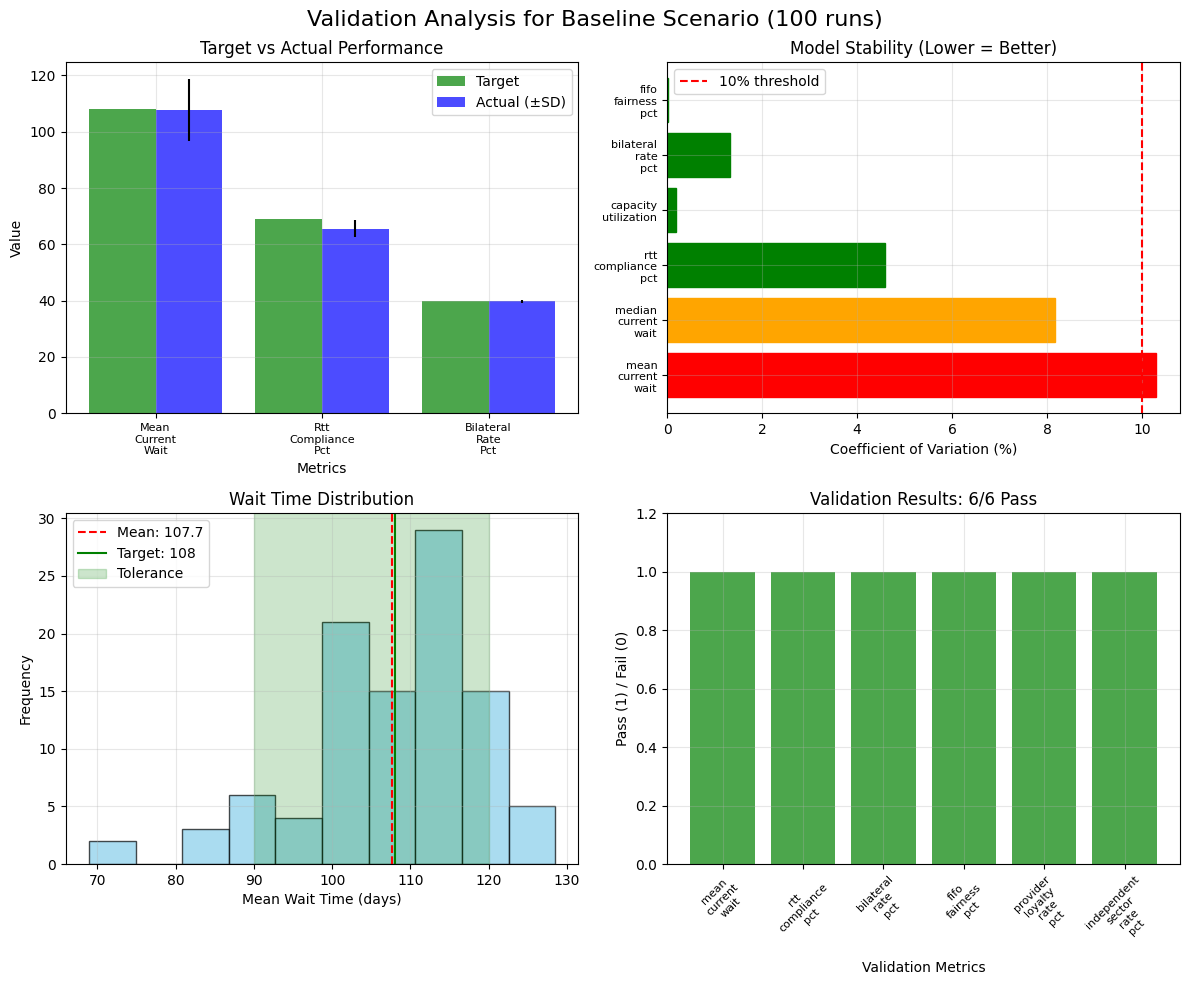

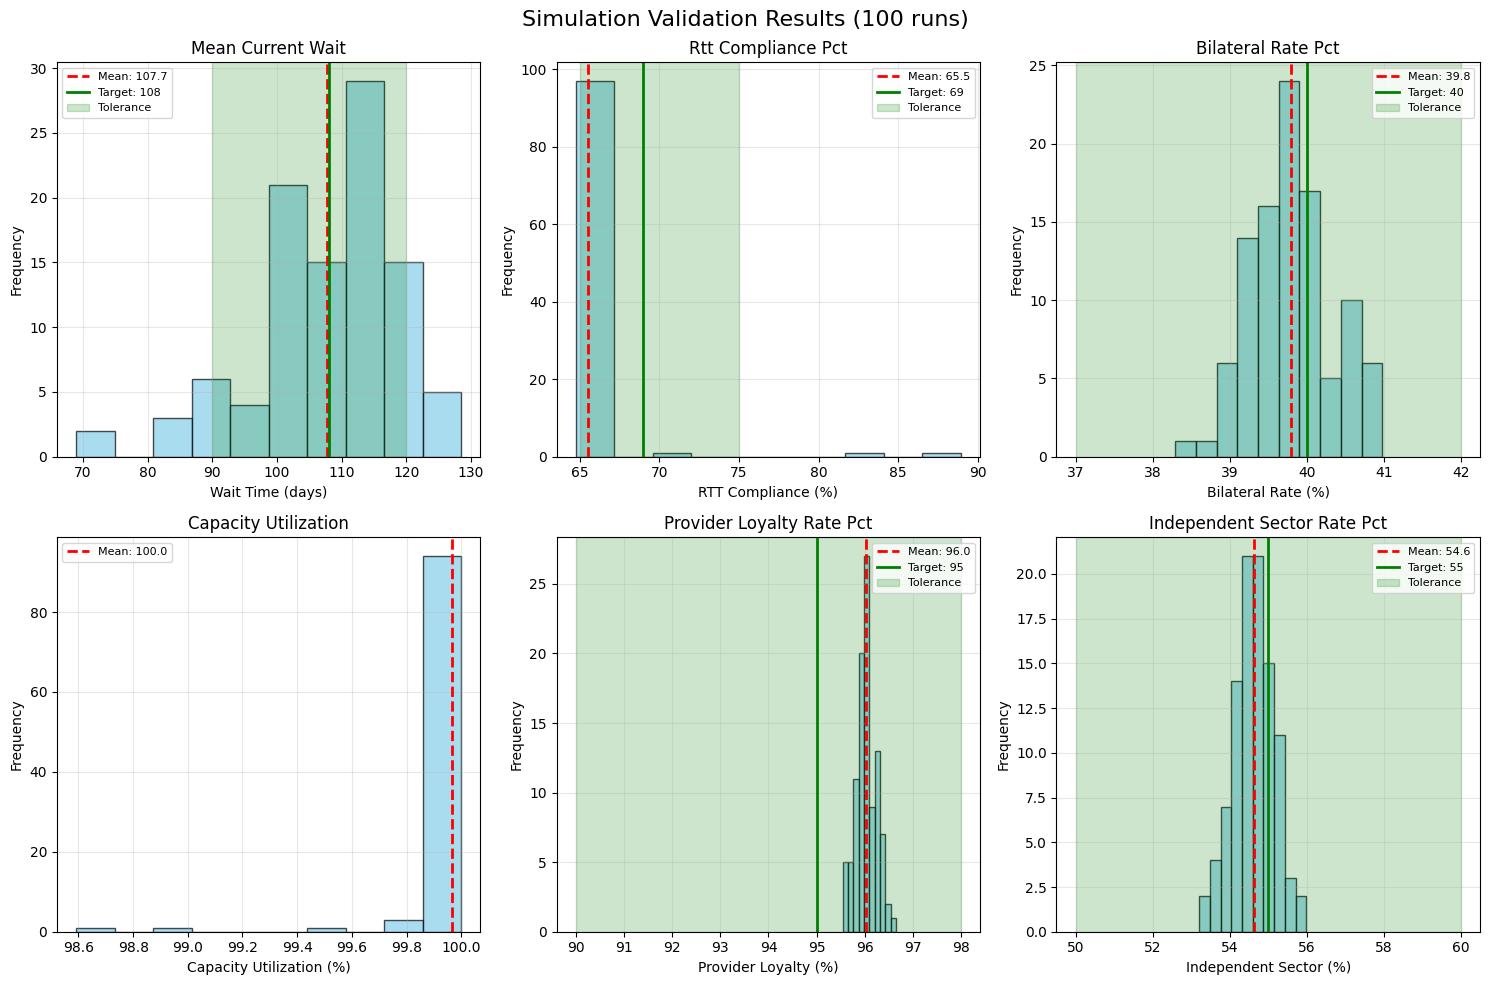

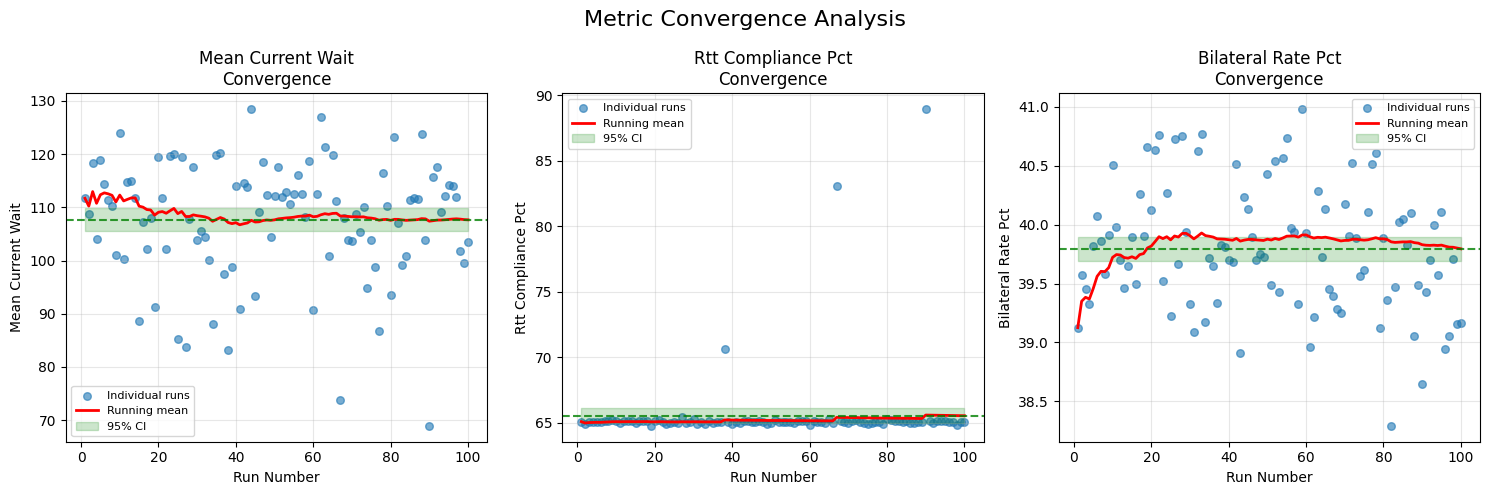

Results exported to validation_results.csv


In [3]:
import pandas as pd
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt

class SimulationValidator:
    """Validates simulation model with multiple runs and statistical analysis"""
    
    def __init__(self, base_config: Dict):
        self.base_config = base_config
        self.results = []
        
    def run_multiple_simulations(self, n_runs: int = 30, different_seeds: bool = True):
        """Run simulation multiple times with different random seeds"""
        print(f"Running {n_runs} validation runs")
        
        for run_id in range(n_runs):
            print(f"Run {run_id + 1}/{n_runs}")
            
            # Use different seed for each run 
            seed = self.base_config['random_seed'] + run_id if different_seeds else self.base_config['random_seed']
            
            # Create simulation instance
            sim = CataractSimulationSimPy(
                start_date=self.base_config['start_date'],
                random_seed=seed
            )
            
            # Run simulation
            summary = sim.run_simulation(
                duration_days=self.base_config['duration_days'],
                arrival_method=self.base_config['arrival_method'],
                backlog_days=self.base_config['backlog_days'],
                warmup_days=self.base_config['warmup_days']
            )
            
            # Store results with run identifier
            summary['run_id'] = run_id
            summary['seed'] = seed
            self.results.append(summary)
            
        print(f"Completed {len(self.results)} runs")
        
    def analyze_results(self) -> Dict:
        """Analyze results across all runs"""
        if not self.results:
            raise ValueError("No simulation results")
            
        # Key metrics to analyze
        key_metrics = [
            'mean_current_wait',
            'median_current_wait', 
            'rtt_compliance_pct',
            'capacity_utilization',
            'bilateral_rate_pct',
            'fifo_fairness_pct',
            'provider_loyalty_rate_pct',
            'independent_sector_rate_pct',
            'avg_daily_capacity_effective',
            'avg_daily_arrivals'
        ]
        
        analysis = {}
        
        for metric in key_metrics:
            values = [result[metric] for result in self.results if metric in result]
            if values:
                analysis[metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'median': np.median(values),
                    'q25': np.percentile(values, 25),
                    'q75': np.percentile(values, 75),
                    'cv': np.std(values) / np.mean(values) if np.mean(values) > 0 else 0,
                    'n_runs': len(values)
                }
        
        return analysis
        
    def calculate_confidence_intervals(self, metric: str, confidence_level: float = 0.95) -> Dict:
        """Calculate confidence intervals for a specific metric"""
        values = [result[metric] for result in self.results if metric in result]
        
        if not values:
            return None
            
        n = len(values)
        mean = np.mean(values)
        std = np.std(values, ddof=1)  # Sample standard deviation
        
        # Calculate t-critical value (approximate for large n)
        alpha = 1 - confidence_level
        if n >= 30:
            t_critical = 1.96  # Normal approximation
        else:
            t_critical = 2.0  # Conservative approximation
            
        margin_of_error = t_critical * (std / np.sqrt(n))
        
        return {
            'mean': mean,
            'std': std,
            'n': n,
            'confidence_level': confidence_level,
            'lower_bound': mean - margin_of_error,
            'upper_bound': mean + margin_of_error,
            'margin_of_error': margin_of_error
        }
    
    def check_validation_targets(self, analysis: Dict) -> Dict:
        """Check if results meet validation targets"""
        targets = {
            'mean_current_wait': {'target': 108, 'tolerance': (90, 120), 'unit': 'days'},
            'rtt_compliance_pct': {'target': 69, 'tolerance': (65, 75), 'unit': '%'},
            'bilateral_rate_pct': {'target': 40, 'tolerance': (37, 42), 'unit': '%'},
            'fifo_fairness_pct': {'target': 90, 'tolerance': (90, 100), 'unit': '%'},
            'provider_loyalty_rate_pct': {'target': 95, 'tolerance': (90, 98), 'unit': '%'},
            'independent_sector_rate_pct': {'target': 55, 'tolerance': (50, 60), 'unit': '%'}
        }
        
        validation_results = {}
        
        for metric, target_info in targets.items():
            if metric in analysis:
                mean_val = analysis[metric]['mean']
                std_val = analysis[metric]['std']
                
                # Check if mean is within tolerance
                within_tolerance = target_info['tolerance'][0] <= mean_val <= target_info['tolerance'][1]
                
                # Calculate how many runs were within tolerance
                metric_values = [result[metric] for result in self.results if metric in result]
                runs_within_tolerance = sum(1 for val in metric_values 
                                          if target_info['tolerance'][0] <= val <= target_info['tolerance'][1])
                pct_runs_within = (runs_within_tolerance / len(metric_values)) * 100 if metric_values else 0
                
                validation_results[metric] = {
                    'target': target_info['target'],
                    'tolerance_range': target_info['tolerance'],
                    'mean_result': mean_val,
                    'std_result': std_val,
                    'within_tolerance': within_tolerance,
                    'runs_within_tolerance': runs_within_tolerance,
                    'pct_runs_within_tolerance': pct_runs_within,
                    'unit': target_info['unit']
                }
        
        return validation_results
    
    def print_validation_report(self):
        """Print comprehensive validation report"""
        if not self.results:
            print("Error, no results to report")
            return
            
        analysis = self.analyze_results()
        validation = self.check_validation_targets(analysis)
        
        print(f"SIMULATION VALIDATION REPORT ({len(self.results)} runs)")
        
        print("\nKEY METRICS SUMMARY:")
        print(f"{'Metric':<30} {'Mean':<8} {'Std':<8} {'CV%':<6} {'Min':<8} {'Max':<8}")
        print("-" * 70)
        
        for metric, stats in analysis.items():
            cv_pct = stats['cv'] * 100
            print(f"{metric:<30} {stats['mean']:<8.1f} {stats['std']:<8.2f} {cv_pct:<6.1f} {stats['min']:<8.1f} {stats['max']:<8.1f}")
        
        print("\nVALIDATION TARGET ASSESSMENT:")
        print(f"{'Metric':<30} {'Target':<8} {'Mean':<8} {'Status':<10} {'Runs OK':<8}")
        print("-" * 70)
        
        for metric, val_info in validation.items():
            status = "✓ PASS" if val_info['within_tolerance'] else "✗ FAIL"
            runs_ok = f"{val_info['runs_within_tolerance']}/{len(self.results)}"
            
            print(f"{metric:<30} {val_info['target']:<8.1f} {val_info['mean_result']:<8.1f} {status:<10} {runs_ok:<8}")
        
        # Overall assessment
        passed_metrics = sum(1 for val_info in validation.values() if val_info['within_tolerance'])
        total_metrics = len(validation)
        
        print(f"\nOVERALL VALIDATION: {passed_metrics}/{total_metrics} metrics within tolerance")
        
        # Stability assessment
        print("\nSTABILITY ASSESSMENT:")
        high_variance_metrics = []
        for metric, stats in analysis.items():
            if stats['cv'] > 0.1:  # CV > 10% indicates high variability
                high_variance_metrics.append((metric, stats['cv'] * 100))
        
        if high_variance_metrics:
            print("High variability (CV > 10%) in:")
            for metric, cv in high_variance_metrics:
                print(f"  - {metric}: CV = {cv:.1f}%")
        else:
            print("All metrics show acceptable variability (CV ≤ 10%)")
        
        # Confidence intervals for key metrics
        print("\n95% CONFIDENCE INTERVALS:")
        key_metrics = ['mean_current_wait', 'rtt_compliance_pct', 'bilateral_rate_pct']
        for metric in key_metrics:
            if metric in analysis:
                ci = self.calculate_confidence_intervals(metric)
                if ci:
                    print(f"{metric}: {ci['mean']:.1f} ± {ci['margin_of_error']:.1f} "
                          f"[{ci['lower_bound']:.1f}, {ci['upper_bound']:.1f}]")
    
    def create_validation_plots(self):
        if not self.results:
            print("No results to plot")
            return
        
        # Setup the figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Simulation Validation Results ({len(self.results)} runs)', fontsize=16)
        
        # Key metrics for plotting
        plot_configs = [
            ('mean_current_wait', 'Wait Time (days)', 108, (90, 120)),
            ('rtt_compliance_pct', 'RTT Compliance (%)', 69, (65, 75)), 
            ('bilateral_rate_pct', 'Bilateral Rate (%)', 40, (37, 42)),
            ('capacity_utilization', 'Capacity Utilization (%)', None, None),
            ('provider_loyalty_rate_pct', 'Provider Loyalty (%)', 95, (90, 98)),
            ('independent_sector_rate_pct', 'Independent Sector (%)', 55, (50, 60))
        ]
        
        for idx, (metric, ylabel, target, tolerance) in enumerate(plot_configs):
            row, col = idx // 3, idx % 3
            ax = axes[row, col]
            
            # Get values for this metric
            values = [result[metric] for result in self.results if metric in result]
            
            if values:
                # Create histogram with distribution
                ax.hist(values, bins=min(10, len(values)//2), alpha=0.7, color='skyblue', edgecolor='black')
                
                # Add mean line
                mean_val = np.mean(values)
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
                
                # Add target and tolerance if available
                if target is not None:
                    ax.axvline(target, color='green', linestyle='-', linewidth=2, label=f'Target: {target}')
                
                if tolerance is not None:
                    ax.axvspan(tolerance[0], tolerance[1], alpha=0.2, color='green', label='Tolerance')
                
                ax.set_xlabel(ylabel)
                ax.set_ylabel('Frequency')
                ax.set_title(metric.replace('_', ' ').title())
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(metric.replace('_', ' ').title())
        
        plt.tight_layout()
        plt.savefig('validation_plots.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_convergence_plot(self):
        """Plot metric convergence across runs"""
        if not self.results:
            print("No results to plot")
            return
            
        key_metrics = ['mean_current_wait', 'rtt_compliance_pct', 'bilateral_rate_pct']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Metric Convergence Analysis', fontsize=16)
        
        for idx, metric in enumerate(key_metrics):
            ax = axes[idx]
            
            values = [result[metric] for result in self.results if metric in result]
            if values:
                # Calculate running mean
                running_means = [np.mean(values[:i+1]) for i in range(len(values))]
                
                # Plot individual points and running mean
                ax.scatter(range(1, len(values)+1), values, alpha=0.6, s=30, label='Individual runs')
                ax.plot(range(1, len(running_means)+1), running_means, 'r-', linewidth=2, label='Running mean')
                
                # Add final confidence band
                final_mean = np.mean(values)
                final_std = np.std(values)
                n = len(values)
                margin = 1.96 * final_std / np.sqrt(n)  # 95% CI
                
                ax.axhline(final_mean, color='green', linestyle='--', alpha=0.8)
                ax.fill_between(range(1, len(values)+1), 
                               final_mean - margin, final_mean + margin, 
                               alpha=0.2, color='green', label='95% CI')
                
                ax.set_xlabel('Run Number')
                ax.set_ylabel(metric.replace('_', ' ').title())
                ax.set_title(f'{metric.replace("_", " ").title()}\nConvergence')
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('convergence_plots.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_summary_dashboard(self):
        """Create summary dashboard plot"""
        if not self.results:
            print("No results to plot")
            return
            
        analysis = self.analyze_results()
        validation = self.check_validation_targets(analysis)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Validation Analysis for Baseline Scenario ({len(self.results)} runs)', fontsize=16)
        
        # 1. Key metrics comparison (target vs actual)
        metrics = ['mean_current_wait', 'rtt_compliance_pct', 'bilateral_rate_pct']
        targets = [108, 69, 40]
        actuals = [analysis[m]['mean'] for m in metrics]
        errors = [analysis[m]['std'] for m in metrics]
        
        x_pos = np.arange(len(metrics))
        ax1.bar(x_pos - 0.2, targets, 0.4, label='Target', alpha=0.7, color='green')
        ax1.bar(x_pos + 0.2, actuals, 0.4, yerr=errors, label='Actual (±SD)', alpha=0.7, color='blue')
        ax1.set_xlabel('Metrics')
        ax1.set_ylabel('Value')
        ax1.set_title('Target vs Actual Performance')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([m.replace('_', '\n').title() for m in metrics], fontsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Coefficient of Variation (stability measure)
        cv_metrics = list(analysis.keys())[:6]  # Top 6 metrics
        cv_values = [analysis[m]['cv'] * 100 for m in cv_metrics]
        
        bars = ax2.barh(cv_metrics, cv_values)
        ax2.axvline(10, color='red', linestyle='--', label='10% threshold')
        ax2.set_xlabel('Coefficient of Variation (%)')
        ax2.set_title('Model Stability (Lower = Better)')
        ax2.set_yticklabels([m.replace('_', '\n') for m in cv_metrics], fontsize=8)
        
        for bar, cv in zip(bars, cv_values):
            if cv > 10:
                bar.set_color('red')
            elif cv > 5:
                bar.set_color('orange') 
            else:
                bar.set_color('green')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Wait time distribution
        wait_times = [result['mean_current_wait'] for result in self.results]
        ax3.hist(wait_times, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(np.mean(wait_times), color='red', linestyle='--', label=f'Mean: {np.mean(wait_times):.1f}')
        ax3.axvline(108, color='green', linestyle='-', label='Target: 108')
        ax3.axvspan(90, 120, alpha=0.2, color='green', label='Tolerance')
        ax3.set_xlabel('Mean Wait Time (days)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Wait Time Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Validation summary (pass/fail by metric)
        val_metrics = list(validation.keys())
        pass_fail = [1 if validation[m]['within_tolerance'] else 0 for m in val_metrics]
        colors = ['green' if pf else 'red' for pf in pass_fail]
        
        ax4.bar(range(len(val_metrics)), pass_fail, color=colors, alpha=0.7)
        ax4.set_xlabel('Validation Metrics')
        ax4.set_ylabel('Pass (1) / Fail (0)')
        ax4.set_title(f'Validation Results: {sum(pass_fail)}/{len(pass_fail)} Pass')
        ax4.set_xticks(range(len(val_metrics)))
        ax4.set_xticklabels([m.replace('_', '\n') for m in val_metrics], fontsize=8, rotation=45)
        ax4.set_ylim(0, 1.2)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('validation_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()

    def export_results(self, filename: str = "validation_results.csv"):
        """Export all run results to CSV"""
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results exported to {filename}")
        return df



if __name__ == "__main__":
    config = {
        'start_date': '2024-03-01',
        'duration_days': 365,
        'arrival_method': 'autocorrelated',
        'backlog_days': 60,
        'warmup_days': 180,
        'random_seed': 42
    }
    
    # Create validator and run multiple simulations
    validator = SimulationValidator(config)
    
    validator.run_multiple_simulations(n_runs=100)
    
    # Analyze and report results
    validator.print_validation_report()
    
    # Create visualizations
    print("\nGenerating validation plots")
    validator.create_summary_dashboard()  # Main dashboard
    validator.create_validation_plots()   # Detailed distributions 
    validator.create_convergence_plot()   # Convergence analysis
    
    # Export results
    results_df = validator.export_results()

In [5]:
class TriagePolicy:
    def assign_provider(self, patient: "Patient", date: pd.Timestamp, sim: "CataractSimulationSimPy"):
        return None


class NoopPolicy(TriagePolicy):
    pass


class AntiBreachISPolicy(TriagePolicy):
    def __init__(self, is_provider_priority: Optional[List[str]] = None, days_to_breach_threshold: int = 21):
        self.is_provider_priority = is_provider_priority or ["SPAMEDICA", "NEWMEDICA", "FITZWILLIAM"]
        self.days_to_breach_threshold = days_to_breach_threshold

    def assign_provider(self, patient, date, sim):
        if patient.days_until_target(date) > self.days_to_breach_threshold:
            return None
        if patient.provider_type == "Independent":
            return None
        for provider in self.is_provider_priority:
            if provider in sim._known_providers:
                return provider
        return None



@dataclass
class Patient:
    patient_id: str
    referral_date: pd.Timestamp
    surgery_target_date: pd.Timestamp
    priority: int
    priority_name: str
    hrg_code: str
    hrg_description: str
    complexity_level: int
    complexity_category: str

    surgery_duration: float
    preop_assessment: float
    postop_1week: float
    postop_6week: float
    theatre_setup: float
    theatre_changeover: float
    total_theatre_time: float
    total_episode_time: float
    base_surgery_duration_minutes: int

    assessment_provider: str
    surgery_provider: str
    is_independent_sector: bool
    provider_loyalty: bool
    provider_type: str
    estimated_daily_capacity: float

    is_bilateral: bool = False
    inter_eye_interval: Optional[int] = None
    bilateral_pair: Optional[str] = None
    is_second_eye: bool = False

    actual_surgery_date: Optional[pd.Timestamp] = None
    actual_wait_days: Optional[int] = None
    served_bucket: Optional[str] = None
    completed: bool = False
    cancelled: bool = False

    def days_waiting(self, current_date: pd.Timestamp) -> int:
        return (current_date - self.referral_date).days

    def days_until_target(self, current_date: pd.Timestamp) -> int:
        return (self.surgery_target_date - current_date).days

    def is_overdue(self, current_date: pd.Timestamp) -> bool:
        return current_date >= self.surgery_target_date

    def within_18_weeks(self) -> bool:
        if self.actual_wait_days is not None:
            return self.actual_wait_days <= 126
        return (self.surgery_target_date - self.referral_date).days <= 126



class CataractSimulationSimPy:
    def __init__(self, start_date="2024-01-01", random_seed=42):
        np.random.seed(random_seed)
        self.random_seed = random_seed
        self.env = simpy.Environment()

        self.start_date = pd.Timestamp(start_date)
        self._init_generators()

        # scheduling knobs
        self.min_lead_time_days = 14
        self.early_pull_window_days = 28
        self.early_pull_fraction = 0.15

        # capacity realism
        self.capacity_disruption_mean = 0.92
        self.capacity_disruption_sd = 0.025

        # mix across buckets
        self.frac_at_risk = 0.25
        self.frac_due = 0.35
        self.wait_threshold_days = 126
        self.compliance_target = 0.69

        # state
        self.patients: List[Patient] = []
        self.completed_patients: List[Patient] = []
        self.daily_stats: List[Dict] = []
        self.patient_counter = 0
        self.daily_capacity: Dict[pd.Timestamp, int] = {}
        self.daily_arrivals_schedule: Dict[pd.Timestamp, int] = {}
        self.measurement_start: Optional[pd.Timestamp] = None

        # providers
        self.provider_stats = defaultdict(lambda: {
            "total_assessments": 0,
            "total_surgeries": 0,
            "total_patients": 0,
            "avg_wait_days": 0,
            "rtt_compliance": 0,
            "is_independent": False,
            "estimated_capacity": 0,
        })
        self._known_providers: set[str] = set()
        self._provider_cap_estimate: Dict[str, float] = defaultdict(float)
        self._provider_cap_count: Dict[str, int] = defaultdict(int)

        # queues and policy
        self.waiting_queue = deque()
        self.policy: TriagePolicy = NoopPolicy()

        self._setup_yearly_capacity(2024)

    # public
    def set_policy(self, policy: TriagePolicy):
        self.policy = policy or NoopPolicy()

    # generators & capacity
    def _init_generators(self):
        self.capacity_gen = CataractCapacityGenerator()
        self.patient_gen = CataractPatientGenerator(random_seed=self.random_seed)
        self.rtt_gen = RTTWaitTimeGenerator()
        self.service_gen = CataractServiceTimeGenerator()
        self.arrival_gen = HealthcareArrivalGenerator()
        self.arrival_gen.set_random_seed(self.random_seed)
        self.provider_gen = CataractProviderGenerator()

    def _setup_yearly_capacity(self, year: int):
        total_capacity = 0
        capacity_days = 0
        for month in range(1, 13):
            monthly_schedule = self.capacity_gen.generate_monthly_schedule(month, year)
            for _, row in monthly_schedule.iterrows():
                date_key = row["date"].date()
                base_capacity = row["capacity"]
                realistic_capacity = max(0, int(base_capacity * 0.80))
                self.daily_capacity[date_key] = realistic_capacity
                if realistic_capacity > 0:
                    capacity_days += 1
                    total_capacity += realistic_capacity
        avg_cap = total_capacity / capacity_days if capacity_days else 0
        print(f"Capacity: {capacity_days} operating days, avg {avg_cap:.1f}/day")

    def setup_arrival_schedule(self, duration_days: int, backlog_days: int, method: str, warmup_days: int):
        total_days = backlog_days + warmup_days + duration_days
        schedule_start = self.start_date - pd.Timedelta(days=(backlog_days + warmup_days))
        arrival_ts = self.arrival_gen.generate_arrivals_time_series(
            start_date=schedule_start.strftime("%Y-%m-%d"),
            num_days=total_days,
            method=method,
        )
        self.daily_arrivals_schedule = {}
        if len(arrival_ts) > 0:
            daily_counts = arrival_ts.groupby("date").size().to_dict()
            current = schedule_start
            for _ in range(total_days):
                self.daily_arrivals_schedule[current.date()] = int(daily_counts.get(current.date(), 0))
                current += pd.Timedelta(days=1)
        else:
            current = schedule_start
            for _ in range(total_days):
                self.daily_arrivals_schedule[current.date()] = int(
                    self.arrival_gen.get_expected_daily_arrivals(current.weekday())
                )
                current += pd.Timedelta(days=1)
        total_arrivals = sum(self.daily_arrivals_schedule.values())
        print(f"Arrivals: {total_arrivals:,} over {total_days} days (avg {total_arrivals/total_days:.1f}/day)")

    # patient creation & provider stats 
    def _create_patient(self, referral_date: pd.Timestamp) -> Patient:
        self.patient_counter += 1
        patient_id = f"P{self.patient_counter:06d}"
        pdata = self.patient_gen.generate_patient()
        provider_pathway = self.provider_gen.generate_complete_pathway()
        is_bilateral = np.random.random() < 0.398
        inter_eye_interval = max(30, int(np.random.lognormal(3.7, 1.2))) if is_bilateral else None

        rtt_wait = self.rtt_gen.generate_rtt_wait(
            priority=pdata["priority"],
            hrg=pdata["hrg_code"],
            referral_month=referral_date.month,
        )
        surgery_target_date = referral_date + pd.Timedelta(days=rtt_wait)

        etimes = self.service_gen.generate_complete_episode_times(
            hrg_code=pdata["hrg_code"],
            complexity=pdata["complexity_category"].lower(),
            activity_type="Day Case",
        )

        patient = Patient(
            patient_id=patient_id,
            referral_date=referral_date,
            surgery_target_date=surgery_target_date,
            priority=pdata["priority"],
            priority_name=pdata["priority_name"],
            hrg_code=pdata["hrg_code"],
            hrg_description=pdata["hrg_description"],
            complexity_level=pdata["complexity_level"],
            complexity_category=pdata["complexity_category"],
            surgery_duration=etimes["surgery_duration"],
            preop_assessment=etimes["preop_assessment"],
            postop_1week=etimes["postop_1week"],
            postop_6week=etimes["postop_6week"],
            theatre_setup=etimes["theatre_setup"],
            theatre_changeover=etimes["theatre_changeover"],
            total_theatre_time=etimes["total_theatre_time"],
            total_episode_time=etimes["total_episode_time"],
            base_surgery_duration_minutes=pdata["base_surgery_duration_minutes"],
            assessment_provider=provider_pathway["assessment_provider"],
            surgery_provider=provider_pathway["surgery_provider"],
            is_independent_sector=provider_pathway["is_independent_sector"],
            provider_loyalty=provider_pathway["provider_loyalty"],
            provider_type=provider_pathway["provider_type"],
            estimated_daily_capacity=provider_pathway["estimated_daily_capacity"],
            is_bilateral=is_bilateral,
            inter_eye_interval=inter_eye_interval,
        )
        self._update_provider_stats(patient)
        return patient

    def _update_provider_stats(self, patient: Patient):
        self.provider_stats[patient.assessment_provider]["total_assessments"] += 1
        self.provider_stats[patient.assessment_provider]["is_independent"] = patient.is_independent_sector

        self.provider_stats[patient.surgery_provider]["total_surgeries"] += 1
        self.provider_stats[patient.surgery_provider]["total_patients"] += 1
        self.provider_stats[patient.surgery_provider]["is_independent"] = patient.is_independent_sector

        self._known_providers.add(patient.surgery_provider)
        prior = self._provider_cap_estimate[patient.surgery_provider]
        n = self._provider_cap_count[patient.surgery_provider]
        new_avg = (prior * n + max(1.0, float(patient.estimated_daily_capacity))) / (n + 1)
        self._provider_cap_estimate[patient.surgery_provider] = new_avg
        self._provider_cap_count[patient.surgery_provider] = n + 1
        self.provider_stats[patient.surgery_provider]["estimated_capacity"] = new_avg

    # processes 
    def patient_arrival_process(self, backlog_days: int, warmup_days: int, duration_days: int):
        backlog_start = -(backlog_days + warmup_days)
        backlog_count = 0
        for day_offset in range(backlog_start, -warmup_days):
            arrival_date = self.start_date + pd.Timedelta(days=day_offset)
            daily_arrivals = self.daily_arrivals_schedule.get(
                arrival_date.date(), self.arrival_gen.get_expected_daily_arrivals(arrival_date.weekday())
            )
            for _ in range(daily_arrivals):
                p = self._create_patient(arrival_date)
                self.patients.append(p)
                self.waiting_queue.append(p)
                backlog_count += 1

        print(f"Backlog patients: {backlog_count}")

        for day in range(warmup_days + duration_days):
            arrival_date = self.start_date + pd.Timedelta(days=day - warmup_days)
            daily_arrivals = self.daily_arrivals_schedule.get(
                arrival_date.date(), self.arrival_gen.get_expected_daily_arrivals(arrival_date.weekday())
            )
            for _ in range(daily_arrivals):
                p = self._create_patient(arrival_date)
                self.patients.append(p)
                self.waiting_queue.append(p)
            yield self.env.timeout(1)

    def surgery_scheduling_process(self, warmup_days: int):
        self.measurement_start = self.start_date
        while True:
            current_day = self.env.now
            current_date = self.start_date + pd.Timedelta(days=current_day - warmup_days)
            base_capacity = self.daily_capacity.get(current_date.date(), 0)

            if base_capacity > 0:
                eligible = self._get_eligible_patients(current_date)

                # policy routing
                for p in eligible:
                    new_provider = self.policy.assign_provider(p, current_date, self)
                    if new_provider and new_provider != p.surgery_provider:
                        p.surgery_provider = new_provider
                        if new_provider.isalpha() and new_provider.upper() in {"SPAMEDICA", "NEWMEDICA", "FITZWILLIAM"}:
                            p.provider_type = "Independent"
                            p.is_independent_sector = True

                due_start = sum(1 for p in eligible if p.is_overdue(current_date))
                stats = self._provider_aware_schedule(current_date, base_capacity, eligible, due_start)
                stats["arrivals"] = self.daily_arrivals_schedule.get(current_date.date(), 0)
                self.daily_stats.append(stats)

            yield self.env.timeout(1)

    # scheduling helpers
    def _effective_capacity(self, base_capacity: int) -> int:
        if base_capacity <= 0:
            return 0
        factor = np.clip(
            np.random.normal(self.capacity_disruption_mean, self.capacity_disruption_sd), 0.75, 1.00
        )
        return max(1, int(np.floor(base_capacity * factor)))

    def _triage_score(self, p: Patient, date: pd.Timestamp) -> float:
        days_to_breach = p.days_until_target(date)
        return 5.0 * p.priority - 0.5 * days_to_breach + 0.2 * p.complexity_level + (2.0 if p.is_bilateral else 0.0)

    def _get_eligible_patients(self, date: pd.Timestamp) -> List[Patient]:
        min_lead = pd.Timedelta(days=self.min_lead_time_days)
        return [
            patient for patient in list(self.waiting_queue)
            if (not patient.completed and not patient.cancelled and date >= patient.referral_date + min_lead)
        ]

    def _categorize_patients(self, eligible: List[Patient], date: pd.Timestamp) -> Tuple[List, List, List, List]:
        due, at_risk, near_due, fifo_early = [], [], [], []
        taken = set()

        for p in eligible:
            if p.is_overdue(date):
                due.append(p); taken.add(p.patient_id)

        for p in eligible:
            if p.patient_id in taken:
                continue
            waited = p.days_waiting(date)
            if 115 <= waited < 126:
                at_risk.append(p); taken.add(p.patient_id)

        for p in eligible:
            if p.patient_id in taken:
                continue
            if 0 <= p.days_until_target(date) <= self.early_pull_window_days:
                near_due.append(p); taken.add(p.patient_id)

        for p in eligible:
            if p.patient_id not in taken:
                fifo_early.append(p)

        def key_fn(x: Patient):
            return (-x.priority, x.referral_date, -self._triage_score(x, date), x.complexity_level)

        due.sort(key=key_fn)
        at_risk.sort(key=key_fn)
        near_due.sort(key=key_fn)
        fifo_early.sort(key=key_fn)
        return due, at_risk, near_due, fifo_early

    def _distribute_capacity_across_providers(self, date: pd.Timestamp, effective_capacity: int, providers: List[str]) -> Dict[str, int]:
        if effective_capacity <= 0 or not providers:
            return {p: 0 for p in providers}

        raw = {p: max(1.0, self._provider_cap_estimate.get(p, 1.0)) for p in providers}
        total_raw = float(sum(raw.values()))
        if total_raw <= 0:
            equal = max(0, effective_capacity // len(providers))
            caps = {p: equal for p in providers}
        else:
            caps = {p: int(np.floor(effective_capacity * (raw[p] / total_raw))) for p in providers}

        assigned = sum(caps.values())
        leftover = effective_capacity - assigned
        if leftover > 0:
            for p in sorted(providers, key=lambda x: raw[x], reverse=True):
                if leftover <= 0:
                    break
                caps[p] += 1
                leftover -= 1
        return caps

    def _provider_aware_schedule(self, date: pd.Timestamp, base_capacity: int, eligible_patients: List[Patient], due_start_count: int) -> Dict:
        effective_capacity = self._effective_capacity(base_capacity)
        if effective_capacity == 0:
            return {
                "date": date, "capacity": 0, "effective_capacity": 0,
                "patients_ready": 0, "patients_completed": 0, "patients_cancelled": 0,
                "total_surgery_time": 0, "total_theatre_time": 0,
                "utilization": 0.0, "avg_surgery_time": 0.0,
                "queue_overflow": 0, "due_start": 0, "due_scheduled": 0, "due_end": 0,
                "complexity_distribution": {}, "provider_distribution": {}
            }

        by_provider: Dict[str, List[Patient]] = defaultdict(list)
        providers_today = set()
        for p in eligible_patients:
            provider = p.surgery_provider or "UNKNOWN"
            providers_today.add(provider)
            by_provider[provider].append(p)
        providers_today = list(providers_today)

        per_provider_caps = self._distribute_capacity_across_providers(date, effective_capacity, providers_today)

        completed_count = 0
        total_surgery_time = 0.0
        total_theatre_time = 0.0
        complexity_completed: Dict[int, int] = {}
        provider_completed: Dict[str, int] = {}
        due_scheduled = 0

        for provider in providers_today:
            cap = per_provider_caps.get(provider, 0)
            if cap <= 0:
                continue
            due, at_risk, near_due, fifo_early = self._categorize_patients(by_provider[provider], date)
            scheduled = self._select_patients_for_surgery(due, at_risk, near_due, fifo_early, cap)

            for patient in scheduled:
                if patient.is_overdue(date):
                    due_scheduled += 1
                self._complete_surgery(patient, date)
                completed_count += 1
                total_surgery_time += patient.surgery_duration
                total_theatre_time += patient.total_theatre_time
                complexity_completed[patient.complexity_level] = complexity_completed.get(patient.complexity_level, 0) + 1
                provider_short = (patient.surgery_provider or "UNK").split()[0]
                provider_completed[provider_short] = provider_completed.get(provider_short, 0) + 1

                if patient.is_bilateral and patient.inter_eye_interval:
                    second_eye = self._schedule_bilateral_surgery(patient)
                    if second_eye:
                        self.patients.append(second_eye)
                        self.waiting_queue.append(second_eye)

        if completed_count < effective_capacity:
            remaining_cap = effective_capacity - completed_count
            remaining_candidates = [p for p in eligible_patients if not p.completed and not p.cancelled]
            if remaining_candidates:
                g_due, g_at_risk, g_near, g_fifo = self._categorize_patients(remaining_candidates, date)
                extra = self._select_patients_for_surgery(g_due, g_at_risk, g_near, g_fifo, remaining_cap)
                for patient in extra:
                    if patient.is_overdue(date):
                        due_scheduled += 1
                    self._complete_surgery(patient, date)
                    completed_count += 1
                    total_surgery_time += patient.surgery_duration
                    total_theatre_time += patient.total_theatre_time
                    complexity_completed[patient.complexity_level] = complexity_completed.get(patient.complexity_level, 0) + 1
                    provider_short = (patient.surgery_provider or "UNK").split()[0]
                    provider_completed[provider_short] = provider_completed.get(provider_short, 0) + 1

                    if patient.is_bilateral and patient.inter_eye_interval:
                        second_eye = self._schedule_bilateral_surgery(patient)
                        if second_eye:
                            self.patients.append(second_eye)
                            self.waiting_queue.append(second_eye)

        utilization = min(100.0, (total_theatre_time / (effective_capacity * 60.0)) * 100.0)
        avg_surgery_time = total_surgery_time / completed_count if completed_count > 0 else 0.0
        due_end = max(0, due_start_count - due_scheduled)

        return {
            "date": date,
            "capacity": base_capacity,
            "effective_capacity": effective_capacity,
            "patients_ready": len(eligible_patients),
            "patients_completed": completed_count,
            "patients_cancelled": 0,
            "total_surgery_time": total_surgery_time,
            "total_theatre_time": total_theatre_time,
            "utilization": utilization,
            "avg_surgery_time": avg_surgery_time,
            "queue_overflow": due_end,
            "due_start": due_start_count,
            "due_scheduled": due_scheduled,
            "due_end": due_end,
            "complexity_distribution": complexity_completed,
            "provider_distribution": provider_completed,
        }

    def _select_patients_for_surgery(
        self,
        due: List[Patient],
        at_risk: List[Patient],
        near_due: List[Patient],
        fifo_early: List[Patient],
        effective_capacity: int,
    ) -> List[Patient]:
        scheduled: List[Patient] = []

        cap_due = min(int(round(self.frac_due * effective_capacity)), effective_capacity)
        take = min(len(due), cap_due)
        for i in range(take):
            due[i].served_bucket = "due"
            scheduled.append(due[i])

        remaining = effective_capacity - len(scheduled)
        if remaining > 0:
            cap_risk = min(int(round(self.frac_at_risk * effective_capacity)), remaining)
            take = min(len(at_risk), cap_risk)
            for i in range(take):
                at_risk[i].served_bucket = "at_risk"
                scheduled.append(at_risk[i])

        remaining = effective_capacity - len(scheduled)
        if remaining > 0 and near_due:
            quota = min(int(self.early_pull_fraction * effective_capacity), remaining, len(near_due))
            for i in range(quota):
                near_due[i].served_bucket = "near_due"
                scheduled.append(near_due[i])

        remaining = effective_capacity - len(scheduled)
        if remaining > 0 and fifo_early:
            take = min(remaining, len(fifo_early))
            for i in range(take):
                fifo_early[i].served_bucket = "fifo"
                scheduled.append(fifo_early[i])

        return scheduled

    def _complete_surgery(self, patient: Patient, date: pd.Timestamp):
        patient.completed = True
        patient.actual_surgery_date = date
        patient.actual_wait_days = patient.days_waiting(date)
        if patient in self.waiting_queue:
            self.waiting_queue.remove(patient)
        self.completed_patients.append(patient)

        if patient.surgery_provider in self.provider_stats:
            stats = self.provider_stats[patient.surgery_provider]
            current_avg = stats["avg_wait_days"]
            current_count = stats["total_patients"]
            if current_count > 0:
                stats["avg_wait_days"] = ((current_avg * (current_count - 1)) + patient.actual_wait_days) / current_count
            else:
                stats["avg_wait_days"] = patient.actual_wait_days

            within_18 = 1 if patient.within_18_weeks() else 0
            current_compliance = stats["rtt_compliance"]
            if current_count > 0:
                stats["rtt_compliance"] = ((current_compliance * (current_count - 1)) + within_18) / current_count
            else:
                stats["rtt_compliance"] = within_18

    def _schedule_bilateral_surgery(self, patient: Patient) -> Optional[Patient]:
        if not patient.is_bilateral or not patient.inter_eye_interval:
            return None
        second_referral = patient.actual_surgery_date + pd.Timedelta(days=patient.inter_eye_interval)
        second_eye = self._create_patient(second_referral)
        second_eye.patient_id = f"{patient.patient_id}_R2"
        second_eye.is_bilateral = False
        second_eye.bilateral_pair = patient.patient_id
        second_eye.is_second_eye = True
        second_eye.surgery_provider = patient.surgery_provider
        second_eye.assessment_provider = patient.assessment_provider
        second_eye.provider_type = patient.provider_type
        second_eye.is_independent_sector = patient.is_independent_sector
        return second_eye

    def run_simulation(self, duration_days=90, arrival_method="autocorrelated", warmup_days=180, backlog_days=60):
        print("Starting cataract simulation")
        print(f"Duration: {duration_days} days | Start: {self.start_date.date()}")
        print(f"Arrivals: {arrival_method} | Backlog: {backlog_days} | Warm-up: {warmup_days}")

        self.setup_arrival_schedule(duration_days, backlog_days, arrival_method, warmup_days)
        self.env.process(self.patient_arrival_process(backlog_days, warmup_days, duration_days))
        self.env.process(self.surgery_scheduling_process(warmup_days))

        total_days = warmup_days + duration_days
        self.env.run(until=total_days)
        print("Simulation complete.")
        return self.get_simulation_summary()

    def get_simulation_summary(self) -> Dict:
        all_patients = self.patients
        measured_start = self.measurement_start or self.start_date
        completed = [p for p in all_patients if p.completed and p.actual_surgery_date and p.actual_surgery_date >= measured_start]
        pending = [p for p in all_patients if not p.completed and not p.cancelled]

        total_arrivals = sum(d.get("arrivals", 0) for d in self.daily_stats)
        total_cap_plan = sum(d["capacity"] for d in self.daily_stats)
        total_cap_eff = sum(d["effective_capacity"] for d in self.daily_stats)
        total_completed = sum(d["patients_completed"] for d in self.daily_stats)

        waits = [p.actual_wait_days for p in completed if p.actual_wait_days is not None]
        if waits:
            rtt_compliance = sum(1 for w in waits if w <= 126) / len(waits) * 100
            mean_wait = float(np.mean(waits))
            median_wait = float(np.median(waits))
        else:
            rtt_compliance = 0.0
            mean_wait = 0.0
            median_wait = 0.0

        fifo_violations, total_pairs = 0, 0
        buckets = defaultdict(list)
        for p in completed:
            buckets[(p.priority, p.served_bucket or "unknown")].append(p)
        for _, group in buckets.items():
            done_sorted = sorted(group, key=lambda x: x.actual_surgery_date)
            for i in range(len(done_sorted)):
                for j in range(i + 1, len(done_sorted)):
                    p1, p2 = done_sorted[i], done_sorted[j]
                    total_pairs += 1
                    if p1.referral_date > p2.referral_date:
                        fifo_violations += 1
        fifo_fairness = (1 - fifo_violations / total_pairs) * 100 if total_pairs > 0 else 100.0

        priority_dist: Dict[int, int] = {}
        for p in all_patients:
            priority_dist[p.priority] = priority_dist.get(p.priority, 0) + 1

        first_eyes = [p for p in all_patients if not p.is_second_eye]
        bilateral_rate = (sum(1 for p in first_eyes if p.is_bilateral) / len(first_eyes) * 100.0) if first_eyes else 0.0

        if self.daily_stats:
            sim_end = self.measurement_start + pd.Timedelta(days=len(self.daily_stats))
        else:
            sim_end = self.start_date

        pending_days_waiting = []
        for p in pending:
            dw = (sim_end - p.referral_date).days
            if dw > 0:
                pending_days_waiting.append(dw)

        complexity_distribution: Dict[int, int] = {}
        hrg_distribution: Dict[str, int] = {}
        for p in all_patients:
            complexity_distribution[p.complexity_level] = complexity_distribution.get(p.complexity_level, 0) + 1
            hrg_distribution[p.hrg_code] = hrg_distribution.get(p.hrg_code, 0) + 1

        provider_loyalty_rate = (sum(1 for p in all_patients if p.provider_loyalty) / len(all_patients) * 100.0) if all_patients else 0.0
        independent_sector_rate = (sum(1 for p in all_patients if p.is_independent_sector) / len(all_patients) * 100.0) if all_patients else 0.0

        assessment_provider_dist: Dict[str, int] = {}
        for p in all_patients:
            short = p.assessment_provider.split()[0] if p.assessment_provider else "Unknown"
            assessment_provider_dist[short] = assessment_provider_dist.get(short, 0) + 1

        surgery_provider_dist: Dict[str, int] = {}
        for p in all_patients:
            short = p.surgery_provider.split()[0] if p.surgery_provider else "Unknown"
            surgery_provider_dist[short] = surgery_provider_dist.get(short, 0) + 1

        provider_performance: Dict[str, Dict] = {}
        for p in completed:
            perf = provider_performance.setdefault(p.surgery_provider, {
                "patients": 0, "total_wait": 0, "within_18_weeks": 0, "avg_wait": 0, "compliance": 0
            })
            perf["patients"] += 1
            perf["total_wait"] += p.actual_wait_days or 0
            if p.within_18_weeks():
                perf["within_18_weeks"] += 1

        for provider, perf in provider_performance.items():
            if perf["patients"] > 0:
                perf["avg_wait"] = perf["total_wait"] / perf["patients"]
                perf["compliance"] = (perf["within_18_weeks"] / perf["patients"]) * 100.0

        return {
            "simulation_period": len(self.daily_stats),
            "total_patients": len(all_patients),
            "completed_surgeries": len(completed),
            "pending_surgeries": len(pending),
            "total_arrivals": total_arrivals,
            "avg_daily_arrivals": total_arrivals / len(self.daily_stats) if self.daily_stats else 0.0,
            "total_capacity_planned": total_cap_plan,
            "total_capacity_effective": total_cap_eff,
            "avg_daily_capacity_effective": (total_cap_eff / len([d for d in self.daily_stats if d["effective_capacity"] > 0])) if any(d["effective_capacity"] > 0 for d in self.daily_stats) else 0.0,
            "capacity_utilization": (total_completed / total_cap_eff * 100.0) if total_cap_eff > 0 else 0.0,
            "mean_current_wait": mean_wait,
            "median_current_wait": median_wait,
            "rtt_compliance_pct": rtt_compliance,
            "fifo_fairness_pct": fifo_fairness,
            "pending_days_waiting": float(np.mean(pending_days_waiting)) if pending_days_waiting else 0.0,
            "priority_distribution": priority_dist,
            "bilateral_rate_pct": bilateral_rate,
            "total_queue_overflow": sum(d.get("queue_overflow", 0) for d in self.daily_stats),
            "avg_daily_overflow": float(np.mean([d.get("queue_overflow", 0) for d in self.daily_stats])) if self.daily_stats else 0.0,
            "complexity_distribution": complexity_distribution,
            "hrg_distribution": hrg_distribution,
            "provider_loyalty_rate_pct": provider_loyalty_rate,
            "independent_sector_rate_pct": independent_sector_rate,
            "top_assessment_providers": dict(sorted(assessment_provider_dist.items(), key=lambda x: x[1], reverse=True)[:10]),
            "top_surgery_providers": dict(sorted(surgery_provider_dist.items(), key=lambda x: x[1], reverse=True)[:10]),
            "provider_performance": provider_performance,
        }

    def print_simulation_summary(self):
        s = self.get_simulation_summary()
        print("CATARACT SIMPY SIMULATION SUMMARY")
        print(f"Simulation Period: {s['simulation_period']} days")
        print(f"Total Patients: {s['total_patients']:,}")
        print(f"Completed Surgeries (measured): {s['completed_surgeries']:,}")
        print(f"Pending Surgeries: {s['pending_surgeries']:,}")
        print(f"Average Daily Arrivals: {s['avg_daily_arrivals']:.1f}")
        print(f"Average Daily Effective Capacity: {s['avg_daily_capacity_effective']:.1f}")
        print(f"Capacity Utilization: {s['capacity_utilization']:.1f}%")
        print("\nWAIT TIME")
        print(f"Mean: {s['mean_current_wait']:.1f} days | Median: {s['median_current_wait']:.1f} days")
        print(f"18-week Compliance: {s['rtt_compliance_pct']:.1f}%")
        print("\nFIFO FAIRNESS")
        print(f"FIFO Adherence: {s['fifo_fairness_pct']:.1f}%")
        print(f"Queue Overflow: {s['avg_daily_overflow']:.1f} patients/day")
        print("\nPROVIDERS (top 5)")
        for i, (provider, count) in enumerate(list(s["top_surgery_providers"].items())[:5], 1):
            pct = count / s["total_patients"] * 100.0
            print(f"  {i}. {provider}: {count:,} ({pct:.1f}%)")

    def export_results(self, filename_prefix="simpy_cataract_simulation_with_providers"):
        patients_data = []
        for p in self.patients:
            patients_data.append({
                "patient_id": p.patient_id,
                "referral_date": p.referral_date,
                "surgery_date": p.surgery_target_date,
                "actual_surgery_date": p.actual_surgery_date,
                "wait_days": (p.surgery_target_date - p.referral_date).days,
                "actual_wait_days": p.actual_wait_days,
                "rtt_target_wait": (p.surgery_target_date - p.referral_date).days,
                "within_18_weeks": p.within_18_weeks(),
                "hrg_code": p.hrg_code,
                "hrg_description": p.hrg_description,
                "priority": p.priority,
                "priority_name": p.priority_name,
                "complexity_level": p.complexity_level,
                "complexity_category": p.complexity_category,
                "base_surgery_duration_minutes": p.base_surgery_duration_minutes,
                "assessment_provider": p.assessment_provider,
                "surgery_provider": p.surgery_provider,
                "is_independent_sector": p.is_independent_sector,
                "provider_loyalty": p.provider_loyalty,
                "provider_type": p.provider_type,
                "estimated_daily_capacity": p.estimated_daily_capacity,
                "is_bilateral": p.is_bilateral,
                "inter_eye_interval": p.inter_eye_interval,
                "bilateral_pair": p.bilateral_pair,
                "is_second_eye": p.is_second_eye,
                "surgery_duration": p.surgery_duration,
                "preop_assessment": p.preop_assessment,
                "postop_1week": p.postop_1week,
                "postop_6week": p.postop_6week,
                "theatre_setup": p.theatre_setup,
                "theatre_changeover": p.theatre_changeover,
                "total_theatre_time": p.total_theatre_time,
                "total_episode_time": p.total_episode_time,
                "scheduled": True,
                "completed": p.completed,
                "cancelled": p.cancelled,
                "rescheduled": False,
                "served_bucket": p.served_bucket,
            })
        patients_df = pd.DataFrame(patients_data)
        daily_df = pd.DataFrame(self.daily_stats)

        provider_stats_data = []
        for provider, stats in self.provider_stats.items():
            provider_stats_data.append({
                "provider_name": provider,
                "total_assessments": stats["total_assessments"],
                "total_surgeries": stats["total_surgeries"],
                "total_patients": stats["total_patients"],
                "avg_wait_days": stats["avg_wait_days"],
                "rtt_compliance": stats["rtt_compliance"],
                "is_independent": stats["is_independent"],
                "estimated_capacity": stats["estimated_capacity"],
            })
        provider_stats_df = pd.DataFrame(provider_stats_data)

        pfile = f"{filename_prefix}_patients.csv"
        dfile = f"{filename_prefix}_daily_stats.csv"
        prfile = f"{filename_prefix}_provider_stats.csv"
        patients_df.to_csv(pfile, index=False)
        daily_df.to_csv(dfile, index=False)
        provider_stats_df.to_csv(prfile, index=False)
        print(f"Exported: {pfile}, {dfile}, {prfile}")
        return patients_df, daily_df, provider_stats_df

    def get_provider_summary(self) -> Dict:
        return {
            "total_providers": len(self.provider_stats),
            "provider_loyalty_rate": (sum(1 for p in self.patients if p.provider_loyalty) / len(self.patients) * 100.0) if self.patients else 0.0,
            "independent_sector_rate": (sum(1 for p in self.patients if p.is_independent_sector) / len(self.patients) * 100.0) if self.patients else 0.0,
            "top_4_providers_share": 0.0,
            "provider_stats": dict(self.provider_stats),
        }


## Centralised Triage with standardised referrals

In [6]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional
from collections import defaultdict

class CentralizedTriagePolicy(TriagePolicy):
    """
    Centralized triage policy that standardizes referrals
    """
    
    def __init__(self, 
                 capacity_weight: float = 0.4,
                 workload_weight: float = 0.3, 
                 complexity_weight: float = 0.2,
                 distance_weight: float = 0.1,
                 max_assignments_per_day: Optional[int] = None):
        """
        Initialize centralized triage policy.
        """
        self.capacity_weight = capacity_weight
        self.workload_weight = workload_weight
        self.complexity_weight = complexity_weight
        self.distance_weight = distance_weight
        self.max_assignments_per_day = max_assignments_per_day
        
        # Track daily reassignments
        self.daily_reassignments = defaultdict(int)
        self.provider_workload = defaultdict(int)  # Track current queue size per provider
        self.provider_complexity_scores = {}  # Track provider complexity capabilities
        
        # Define provider capabilities
        self.provider_capabilities = {
            'SPAMEDICA': {'max_complexity': 9, 'specialty_score': 0.9},
            'NEWMEDICA': {'max_complexity': 8, 'specialty_score': 0.85},
            'FITZWILLIAM': {'max_complexity': 8, 'specialty_score': 0.85},
            'CAMBRIDGE': {'max_complexity': 7, 'specialty_score': 0.8},
            'ANGLIA': {'max_complexity': 7, 'specialty_score': 0.8},
            'NORTH': {'max_complexity': 7, 'specialty_score': 0.8},
            'WEST': {'max_complexity': 6, 'specialty_score': 0.75},
            'COMMUNITY': {'max_complexity': 5, 'specialty_score': 0.7},
        }
    
    def assign_provider(self, patient, date: pd.Timestamp, sim) -> Optional[str]:
        """
        Centralized assignment logic that overrides original provider assignments.
        """
        # Reset daily counter if new day
        date_key = date.date()
        if date_key not in self.daily_reassignments:
            self.daily_reassignments.clear()
            self.daily_reassignments[date_key] = 0
        
        # Check if we've hit daily reassignment limit
        if (self.max_assignments_per_day and 
            self.daily_reassignments[date_key] >= self.max_assignments_per_day):
            return None
        
        # Get available providers
        available_providers = list(sim._known_providers)
        if not available_providers:
            return None
        
        # Update workload tracking
        self._update_workload_tracking(sim)
        
        # Calculate assignment scores for each provider
        provider_scores = {}
        for provider in available_providers:
            score = self._calculate_assignment_score(patient, provider, sim)
            provider_scores[provider] = score
        
        # Select best provider
        if not provider_scores:
            return None
            
        best_provider = max(provider_scores.keys(), key=lambda p: provider_scores[p])
        
        # Only reassign if significantly better than current assignment
        current_score = provider_scores.get(patient.surgery_provider, 0)
        best_score = provider_scores[best_provider]
        
        # Require 10% improvement to trigger reassignment (reduces churn)
        if best_provider != patient.surgery_provider and best_score > current_score * 1.1:
            self.daily_reassignments[date_key] += 1
            self.provider_workload[best_provider] += 1
            if patient.surgery_provider in self.provider_workload:
                self.provider_workload[patient.surgery_provider] -= 1
            return best_provider
        
        return None  # Keep current assignment
    
    def _update_workload_tracking(self, sim):
        """Update current workload estimates for each provider."""
        # Reset workload counters
        self.provider_workload.clear()
        
        # Count patients in waiting queue by provider
        for patient in sim.waiting_queue:
            if not patient.completed and not patient.cancelled:
                self.provider_workload[patient.surgery_provider] += 1
    
    def _calculate_assignment_score(self, patient, provider: str, sim) -> float:
        """
        Calculate assignment score for patient-provider pair.
        Higher score = better match.
        """
        score = 0.0
        
        # 1. Capacity component - providers with higher capacity get higher scores
        capacity_estimate = sim._provider_cap_estimate.get(provider, 1.0)
        normalized_capacity = min(1.0, capacity_estimate / 50.0)  # Normalize to 0-1
        score += self.capacity_weight * normalized_capacity
        
        # 2. Workload component - providers with lower current workload get higher scores
        current_workload = self.provider_workload.get(provider, 0)
        max_workload = max(self.provider_workload.values()) if self.provider_workload else 1
        if max_workload > 0:
            workload_score = 1.0 - (current_workload / max_workload)
        else:
            workload_score = 1.0
        score += self.workload_weight * workload_score
        
        # 3. Complexity matching component
        complexity_score = self._calculate_complexity_match(patient, provider)
        score += self.complexity_weight * complexity_score
        
        # 4. Distance/accessibility component (placeholder - could be enhanced with real geographic data)
        distance_score = self._calculate_distance_score(patient, provider)
        score += self.distance_weight * distance_score
        
        return score
    
    def _calculate_complexity_match(self, patient, provider: str) -> float:
        """Calculate how well provider can handle patient complexity."""
        patient_complexity = patient.complexity_level
        
        # Get provider capabilities
        capabilities = self.provider_capabilities.get(provider, {
            'max_complexity': 5, 'specialty_score': 0.7
        })
        
        max_complexity = capabilities['max_complexity']
        specialty_score = capabilities['specialty_score']
        
        # Perfect match if within provider's range
        if patient_complexity <= max_complexity:
            # Bonus for high-complexity providers taking high-complexity cases
            complexity_bonus = min(1.0, patient_complexity / 9.0)
            return specialty_score * (0.8 + 0.2 * complexity_bonus)
        else:
            # Penalty for providers taking cases above their capability
            overflow_penalty = (patient_complexity - max_complexity) / 9.0
            return max(0.1, specialty_score - overflow_penalty)
    
    def _calculate_distance_score(self, patient, provider: str) -> float:
        """
        Calculate distance/accessibility score (placeholder implementation).
        In reality, this would use geographic data and patient postcode.
        """
        # Simplified model: some providers are more accessible
        accessibility_scores = {
            'CAMBRIDGE': 0.9,
            'ANGLIA': 0.85,
            'NORTH': 0.8,
            'SPAMEDICA': 0.75,  # IS providers might be slightly less accessible
            'NEWMEDICA': 0.75,
            'FITZWILLIAM': 0.7,
            'WEST': 0.8,
            'COMMUNITY': 0.95,  # Community providers most accessible
        }
        
        return accessibility_scores.get(provider, 0.7)
    
    def get_policy_stats(self) -> Dict:
        """Get statistics about triage policy performance."""
        total_reassignments = sum(self.daily_reassignments.values())
        active_days = len(self.daily_reassignments)
        
        return {
            'policy_name': 'CentralizedTriage',
            'total_reassignments': total_reassignments,
            'avg_daily_reassignments': total_reassignments / max(1, active_days),
            'active_days': active_days,
            'current_workload_distribution': dict(self.provider_workload),
            'provider_capabilities': self.provider_capabilities
        }


class CapacityBalancedTriagePolicy(TriagePolicy):
    """
    Simplified centralized triage focused purely on capacity balancing.
    Assigns patients to providers with the highest available capacity.
    """
    
    def __init__(self, rebalance_threshold: float = 0.2):
        """
        Args:
            rebalance_threshold: Only reassign if capacity difference > this threshold
        """
        self.rebalance_threshold = rebalance_threshold
        self.daily_assignments = defaultdict(int)
    
    def assign_provider(self, patient, date: pd.Timestamp, sim) -> Optional[str]:
        """Simple capacity-based assignment."""
        available_providers = list(sim._known_providers)
        if len(available_providers) <= 1:
            return None
        
        # Find provider with highest capacity estimate
        best_provider = None
        best_capacity = 0
        current_capacity = sim._provider_cap_estimate.get(patient.surgery_provider, 1.0)
        
        for provider in available_providers:
            capacity = sim._provider_cap_estimate.get(provider, 1.0)
            if capacity > best_capacity:
                best_capacity = capacity
                best_provider = provider
        
        # Only reassign if significantly better capacity
        if (best_provider and 
            best_provider != patient.surgery_provider and
            best_capacity > current_capacity * (1 + self.rebalance_threshold)):
            return best_provider
        
        return None


def compare_triage_policies(baseline_results: Dict, centralized_results: Dict) -> Dict:
    """
    Compare baseline vs centralized triage results.
    """
    comparison = {
        'wait_time_improvement': {
            'mean_wait_change': centralized_results['mean_current_wait'] - baseline_results['mean_current_wait'],
            'median_wait_change': centralized_results['median_current_wait'] - baseline_results['median_current_wait'],
            'compliance_change': centralized_results['rtt_compliance_pct'] - baseline_results['rtt_compliance_pct']
        },
        'capacity_utilization': {
            'baseline': baseline_results['capacity_utilization'],
            'centralized': centralized_results['capacity_utilization'],
            'improvement': centralized_results['capacity_utilization'] - baseline_results['capacity_utilization']
        },
        'fairness_metrics': {
            'baseline_fifo': baseline_results['fifo_fairness_pct'],
            'centralized_fifo': centralized_results['fifo_fairness_pct'],
            'overflow_reduction': baseline_results['avg_daily_overflow'] - centralized_results['avg_daily_overflow']
        },
        'provider_distribution': {
            'baseline_top4_share': sum(list(baseline_results['top_surgery_providers'].values())[:4]) / baseline_results['total_patients'],
            'centralized_top4_share': sum(list(centralized_results['top_surgery_providers'].values())[:4]) / centralized_results['total_patients']
        }
    }
    
    return comparison


# Modified simulation runner for comparison
def run_triage_comparison():
    """
    Run both baseline and centralized triage simulations for comparison.
    """
    print("RUNNING TRIAGE POLICY COMPARISON")
    
    # Baseline simulation (NoopPolicy)
    print("\n1. Running BASELINE simulation (current provider assignments)")
    baseline_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    baseline_sim.set_policy(NoopPolicy())
    baseline_results = baseline_sim.run_simulation(
        duration_days=365,
        arrival_method='autocorrelated',
        backlog_days=60,
        warmup_days=180
    )

    centralized_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    centralized_policy = CentralizedTriagePolicy(
        capacity_weight=0.4,
        workload_weight=0.3,
        complexity_weight=0.2,
        distance_weight=0.1
    )
    centralized_sim.set_policy(centralized_policy)
    centralized_results = centralized_sim.run_simulation(
        duration_days=365,
        arrival_method='autocorrelated', 
        backlog_days=60,
        warmup_days=180
    )
    
    # Compare results
    print("\n3. COMPARISON ANALYSIS")
    comparison = compare_triage_policies(baseline_results, centralized_results)
    
    print(f"WAIT TIME IMPACT:")
    print(f"  Mean wait change: {comparison['wait_time_improvement']['mean_wait_change']:+.1f} days")
    print(f"  Median wait change: {comparison['wait_time_improvement']['median_wait_change']:+.1f} days") 
    print(f"  RTT compliance change: {comparison['wait_time_improvement']['compliance_change']:+.1f}%")
    
    print(f"\nCAPACITY UTILIZATION:")
    print(f"  Baseline: {comparison['capacity_utilization']['baseline']:.1f}%")
    print(f"  Centralized: {comparison['capacity_utilization']['centralized']:.1f}%")
    print(f"  Improvement: {comparison['capacity_utilization']['improvement']:+.1f}%")
    
    print(f"\nFAIRNESS & DISTRIBUTION:")
    print(f"  Overflow reduction: {comparison['fairness_metrics']['overflow_reduction']:+.1f} patients/day")
    print(f"  Top 4 provider share - Baseline: {comparison['provider_distribution']['baseline_top4_share']:.1f}%")
    print(f"  Top 4 provider share - Centralized: {comparison['provider_distribution']['centralized_top4_share']:.1f}%")
    
    # Policy-specific stats
    policy_stats = centralized_policy.get_policy_stats()
    print(f"\nCENTRALIZED TRIAGE ACTIVITY:")
    print(f"  Total reassignments: {policy_stats['total_reassignments']:,}")
    print(f"  Avg daily reassignments: {policy_stats['avg_daily_reassignments']:.1f}")
    
    return {
        'baseline_results': baseline_results,
        'centralized_results': centralized_results,
        'comparison': comparison,
        'policy_stats': policy_stats
    }


if __name__ == "__main__":
    results = run_triage_comparison()

RUNNING TRIAGE POLICY COMPARISON

1. Running BASELINE simulation (current provider assignments)
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.

3. COMPARISON ANALYSIS
WAIT TIME IMPACT:
  Mean wait change: -38.3 days
  Median wait change: -32.0 days
  RTT compliance change: +17.1%

CAPACITY UTILIZATION:
  Baseline: 100.0%
  Centralized: 99.3%
  Improvement: -0.7%

FAIRNESS & DISTRIBUTION:
  Overflow reduction: -236.3 patients/day
  Top 4 provider share - Baseline: 1.0%
  Top 4 provider share - Centralized: 0.5%

CENTRALIZED TRIAGE ACTIV

In [8]:

def run_centralized_triage_scenario():
    print("CENTRALIZED TRIAGE SCENARIO")
 
    # Create simulation with centralized triage
    sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    
    # Set up centralized triage policy
    centralized_policy = CentralizedTriagePolicy(
        capacity_weight=0.4,      # 40% weight on provider capacity
        workload_weight=0.3,      # 30% weight on current workload  
        complexity_weight=0.2,    # 20% weight on complexity matching
        distance_weight=0.1,      # 10% weight on accessibility
        max_assignments_per_day=None  # No limit on daily reassignments
    )
    
    sim.set_policy(centralized_policy)
    
    # Run simulation with same parameters as baseline
    centralized_results = sim.run_simulation(
        duration_days=365,
        arrival_method='autocorrelated',
        backlog_days=60,
        warmup_days=180
    )
    
    # Print results
    sim.print_simulation_summary()
    
    # Export results for comparison
    patients_df, daily_df, provider_stats_df = sim.export_results(
        filename_prefix='centralized_triage_simulation'
    )
    
    # Print centralized triage specific stats
    policy_stats = centralized_policy.get_policy_stats()
    print(f"\nCENTRALIZED TRIAGE POLICY STATISTICS:")
    print(f"Total patient reassignments: {policy_stats['total_reassignments']:,}")
    print(f"Average daily reassignments: {policy_stats['avg_daily_reassignments']:.1f}")
    print(f"Active days: {policy_stats['active_days']}")
    
    print(f"\nPROVIDER WORKLOAD DISTRIBUTION:")
    workload = policy_stats['current_workload_distribution']
    for provider, count in sorted(workload.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            provider_short = provider.split()[0] if provider else 'UNK'
            print(f"  {provider_short}: {count} patients in queue")
    
    return {
        'simulation_results': centralized_results,
        'policy_stats': policy_stats,
        'patients_df': patients_df,
        'daily_df': daily_df,
        'provider_stats_df': provider_stats_df
    }

def compare_with_baseline():


    baseline_stats = {
        'mean_current_wait': 105.0,
        'median_current_wait': 51.0,
        'rtt_compliance_pct': 67.3,
        'capacity_utilization': 100.0,
        'avg_daily_overflow': 1233.0,
        'fifo_fairness_pct': 97.5,
        'total_patients': 9345,
        'completed_surgeries': 4942,
        'independent_sector_rate_pct': 54.8,
        'provider_loyalty_rate_pct': 96.0
    }
    
    print("\nRUNNING CENTRALIZED TRIAGE")
    centralized_results = run_centralized_triage_scenario()
    centralized_stats = centralized_results['simulation_results']
    
    print("BASELINE vs CENTRALIZED TRIAGE COMPARISON")

    
    print(f"WAIT TIME PERFORMANCE:")
    print(f"  Mean Wait Time:")
    print(f"    Baseline: {baseline_stats['mean_current_wait']:.1f} days")
    print(f"    Centralized: {centralized_stats['mean_current_wait']:.1f} days")
    print(f"    Change: {centralized_stats['mean_current_wait'] - baseline_stats['mean_current_wait']:+.1f} days")
    
    print(f"  RTT Compliance:")
    print(f"    Baseline: {baseline_stats['rtt_compliance_pct']:.1f}%")
    print(f"    Centralized: {centralized_stats['rtt_compliance_pct']:.1f}%")
    print(f"    Change: {centralized_stats['rtt_compliance_pct'] - baseline_stats['rtt_compliance_pct']:+.1f}%")
    
    print(f"\nSYSTEM EFFICIENCY:")
    print(f"  Capacity Utilization:")
    print(f"    Baseline: {baseline_stats['capacity_utilization']:.1f}%")
    print(f"    Centralized: {centralized_stats['capacity_utilization']:.1f}%")
    print(f"    Change: {centralized_stats['capacity_utilization'] - baseline_stats['capacity_utilization']:+.1f}%")
    
    print(f"  Daily Queue Overflow:")
    print(f"    Baseline: {baseline_stats['avg_daily_overflow']:.0f} patients")
    print(f"    Centralized: {centralized_stats['avg_daily_overflow']:.0f} patients")
    print(f"    Reduction: {baseline_stats['avg_daily_overflow'] - centralized_stats['avg_daily_overflow']:+.0f} patients")
    
    print(f"\nPROVIDER DISTRIBUTION:")
    print(f"  Independent Sector Usage:")
    print(f"    Baseline: {baseline_stats['independent_sector_rate_pct']:.1f}%")
    print(f"    Centralized: {centralized_stats['independent_sector_rate_pct']:.1f}%")
    print(f"    Change: {centralized_stats['independent_sector_rate_pct'] - baseline_stats['independent_sector_rate_pct']:+.1f}%")
    
    print(f"  Provider Loyalty (same provider for assessment & surgery):")
    print(f"    Baseline: {baseline_stats['provider_loyalty_rate_pct']:.1f}%")
    print(f"    Centralized: {centralized_stats['provider_loyalty_rate_pct']:.1f}%")
    print(f"    Change: {centralized_stats['provider_loyalty_rate_pct'] - baseline_stats['provider_loyalty_rate_pct']:+.1f}%")
    
    policy_stats = centralized_results['policy_stats']
    reassignment_rate = (policy_stats['total_reassignments'] / centralized_stats['total_patients']) * 100
    print(f"\nCENTRALIZED TRIAGE ACTIVITY:")
    print(f"  Patient Reassignment Rate: {reassignment_rate:.1f}%")
    print(f"  Total Reassignments: {policy_stats['total_reassignments']:,}")
    
    return {
        'baseline': baseline_stats,
        'centralized': centralized_stats,
        'policy_stats': policy_stats
    }

if __name__ == "__main__":

    comparison = compare_with_baseline()


RUNNING CENTRALIZED TRIAGE
CENTRALIZED TRIAGE SCENARIO
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
CATARACT SIMPY SIMULATION SUMMARY
Simulation Period: 301 days
Total Patients: 9,294
Completed Surgeries (measured): 4,887
Pending Surgeries: 3,105
Average Daily Arrivals: 12.5
Average Daily Effective Capacity: 20.7
Capacity Utilization: 99.3%

WAIT TIME
Mean: 67.2 days | Median: 19.0 days
18-week Compliance: 84.0%

FIFO FAIRNESS
FIFO Adherence: 95.5%
Queue Overflow: 1429.4 patients/day

PROVIDERS (top 5)
  1. SPAMEDICA: 1,812 (19.5%)
  2. ANGLIA: 937 (10.1%)
  3. CAMBRIDGE: 930 (10.0%)
  4. NORTH: 928 (10.0%)
  5. NEWMEDICA: 383 (4.1%)
Exported: centralized_triage_simulation_patients.csv, centralized_triage_simulation_daily_stats.csv, centralized_triage_simulation_provider_stats.csv

In [9]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import scipy.stats as stats

class RobustnessTestFramework:
    """
    Comprehensive robustness testing framework for NHS cataract surgery triage policies.
    Tests policy performance under various scenarios and parameter variations.
    """
    
    def __init__(self, baseline_sim_class, centralized_policy_class):
        self.baseline_sim_class = baseline_sim_class
        self.centralized_policy_class = centralized_policy_class
        self.results_cache = {}
        
    def run_robustness_tests(self) -> Dict:
        """Run complete robustness testing suite."""
        
        results = {
            'random_seed_variation': self.test_random_seed_variation(),
            'capacity_stress_test': self.test_capacity_variations(), 
            'demand_variation_test': self.test_demand_variations(),
            'seasonal_variation_test': self.test_seasonal_patterns(),
            'policy_parameter_sensitivity': self.test_policy_parameters(),
            'disruption_scenarios': self.test_disruption_scenarios(),
            'statistical_significance': self.test_statistical_significance(),
            'extreme_scenarios': self.test_extreme_scenarios()
        }
        
        # Generate summary report
        self.generate_robustness_report(results)
        return results
    
    def test_random_seed_variation(self, n_runs: int = 10) -> Dict:
        """Test consistency across different random seeds."""
        print(f"\n1️ Testing random seed variation ({n_runs} runs)")
        
        baseline_results = []
        centralized_results = []
        
        for i in range(n_runs):
            seed = 42 + i * 100
            print(f"   Run {i+1}/{n_runs} (seed={seed})")
            
            # Baseline
            baseline_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=seed)
            baseline_summary = baseline_sim.run_simulation(
                duration_days=180,  # Shorter for speed
                arrival_method='autocorrelated',
                backlog_days=30,
                warmup_days=90
            )
            baseline_results.append(baseline_summary)
            
            # Centralized
            centralized_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=seed)
            centralized_policy = self.centralized_policy_class()
            centralized_sim.set_policy(centralized_policy)
            centralized_summary = centralized_sim.run_simulation(
                duration_days=180,
                arrival_method='autocorrelated',
                backlog_days=30,
                warmup_days=90
            )
            centralized_results.append(centralized_summary)
        
        # Calculate statistics
        baseline_stats = self._calculate_result_statistics(baseline_results)
        centralized_stats = self._calculate_result_statistics(centralized_results)
        
        return {
            'baseline_stats': baseline_stats,
            'centralized_stats': centralized_stats,
            'improvement_consistency': self._calculate_improvement_consistency(baseline_results, centralized_results),
            'coefficient_of_variation': {
                'baseline_mean_wait_cv': baseline_stats['mean_current_wait']['std'] / baseline_stats['mean_current_wait']['mean'],
                'centralized_mean_wait_cv': centralized_stats['mean_current_wait']['std'] / centralized_stats['mean_current_wait']['mean']
            }
        }
    
    def test_capacity_variations(self) -> Dict:
        """Test performance under different capacity scenarios."""
        print(f"\n2️ Testing capacity variations")
        
        capacity_multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
        results = {}
        
        for multiplier in capacity_multipliers:
            print(f"   Testing capacity multiplier: {multiplier}")
            
            # Modify capacity in simulation (you'd need to add this method)
            baseline_result = self._run_capacity_scenario(multiplier, policy_type='baseline')
            centralized_result = self._run_capacity_scenario(multiplier, policy_type='centralized')
            
            results[multiplier] = {
                'baseline': baseline_result,
                'centralized': centralized_result,
                'improvement': {
                    'mean_wait': baseline_result['mean_current_wait'] - centralized_result['mean_current_wait'],
                    'compliance': centralized_result['rtt_compliance_pct'] - baseline_result['rtt_compliance_pct']
                }
            }
        
        return results
    
    def test_demand_variations(self) -> Dict:
        """Test performance under different demand patterns."""
        print(f"\n3️ Testing demand variations")
        
        arrival_methods = ['constant', 'autocorrelated', 'seasonal', 'poisson']
        results = {}
        
        for method in arrival_methods:
            print(f"   Testing arrival method: {method}")
            results[method] = self._run_demand_scenario(method)
        
        return results
    
    def test_seasonal_patterns(self) -> Dict:
        """Test performance across different seasonal patterns."""
        print(f"\n4️Testing seasonal patterns")
        
        start_months = [1, 4, 7, 10]  # Jan, Apr, Jul, Oct
        results = {}
        
        for month in start_months:
            print(f"   Testing start month: {month}")
            start_date = f'2024-{month:02d}-01'
            results[month] = self._run_seasonal_scenario(start_date)
        
        return results
    
    def test_policy_parameters(self) -> Dict:
        """Test sensitivity to centralized triage policy parameters."""
        print(f"\n5️ Testing policy parameter sensitivity")
        
        # Test different weight combinations
        weight_configs = [
            {'capacity': 0.5, 'workload': 0.3, 'complexity': 0.1, 'distance': 0.1},
            {'capacity': 0.3, 'workload': 0.5, 'complexity': 0.1, 'distance': 0.1},
            {'capacity': 0.4, 'workload': 0.3, 'complexity': 0.2, 'distance': 0.1},  # Original
            {'capacity': 0.2, 'workload': 0.2, 'complexity': 0.5, 'distance': 0.1},
            {'capacity': 0.25, 'workload': 0.25, 'complexity': 0.25, 'distance': 0.25}  # Equal weights
        ]
        
        results = {}
        for i, config in enumerate(weight_configs):
            print(f"   Testing weight config {i+1}: {config}")
            results[f"config_{i+1}"] = self._run_parameter_scenario(config)
        
        return results
    
    def test_disruption_scenarios(self) -> Dict:
        """Test resilience to various disruption scenarios."""
        print(f"\n6️Testing disruption scenarios")
        
        scenarios = {
            'capacity_shock': {'capacity_multiplier': 0.5, 'duration_days': 30},
            'demand_surge': {'demand_multiplier': 1.5, 'duration_days': 60},
            'provider_closure': {'closed_providers': ['SPAMEDICA'], 'duration_days': 90},
            'winter_pressure': {'capacity_multiplier': 0.8, 'demand_multiplier': 1.2, 'duration_days': 120}
        }
        
        results = {}
        for scenario_name, params in scenarios.items():
            print(f"   Testing scenario: {scenario_name}")
            results[scenario_name] = self._run_disruption_scenario(scenario_name, params)
        
        return results
    
    def test_statistical_significance(self) -> Dict:
        """Test statistical significance of improvements."""
        print(f"\n7️Testing statistical significance")
        
        n_runs = 30
        baseline_waits = []
        centralized_waits = []
        
        for i in range(n_runs):
            seed = 1000 + i
            
            # Baseline
            baseline_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=seed)
            baseline_results = baseline_sim.run_simulation(duration_days=90, warmup_days=60, backlog_days=30)
            baseline_waits.append(baseline_results['mean_current_wait'])
            
            # Centralized
            centralized_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=seed)
            centralized_policy = self.centralized_policy_class()
            centralized_sim.set_policy(centralized_policy)
            centralized_results = centralized_sim.run_simulation(duration_days=90, warmup_days=60, backlog_days=30)
            centralized_waits.append(centralized_results['mean_current_wait'])
        
        # Statistical tests
        t_stat, p_value = stats.ttest_rel(baseline_waits, centralized_waits)
        effect_size = (np.mean(baseline_waits) - np.mean(centralized_waits)) / np.sqrt((np.var(baseline_waits) + np.var(centralized_waits)) / 2)
        
        return {
            'baseline_waits': baseline_waits,
            'centralized_waits': centralized_waits,
            't_statistic': t_stat,
            'p_value': p_value,
            'effect_size': effect_size,
            'mean_improvement': np.mean(baseline_waits) - np.mean(centralized_waits),
            'improvement_95_ci': np.percentile(np.array(baseline_waits) - np.array(centralized_waits), [2.5, 97.5])
        }
    
    def test_extreme_scenarios(self) -> Dict:
        """Test performance under extreme conditions."""
        print(f"\n8️ Testing extreme scenarios")
        
        scenarios = {
            'very_low_capacity': {'capacity_multiplier': 0.3},
            'very_high_demand': {'demand_multiplier': 2.0},
            'high_complexity_surge': {'complexity_bias': 2.0},  # More complex cases
            'provider_concentration': {'remove_providers': 0.7}  # Remove 70% of providers
        }
        
        results = {}
        for scenario_name, params in scenarios.items():
            print(f"   Testing extreme scenario: {scenario_name}")
            results[scenario_name] = self._run_extreme_scenario(scenario_name, params)
        
        return results
    
    def _calculate_result_statistics(self, results: List[Dict]) -> Dict:
        """Calculate mean, std, min, max for key metrics across multiple runs."""
        metrics = ['mean_current_wait', 'median_current_wait', 'rtt_compliance_pct', 'capacity_utilization']
        stats = {}
        
        for metric in metrics:
            values = [r[metric] for r in results]
            stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values),
                'median': np.median(values)
            }
        
        return stats
    
    def _calculate_improvement_consistency(self, baseline_results: List[Dict], centralized_results: List[Dict]) -> Dict:
        """Calculate how consistently centralized triage outperforms baseline."""
        improvements = []
        compliance_improvements = []
        
        for b, c in zip(baseline_results, centralized_results):
            wait_improvement = b['mean_current_wait'] - c['mean_current_wait']
            compliance_improvement = c['rtt_compliance_pct'] - b['rtt_compliance_pct']
            improvements.append(wait_improvement)
            compliance_improvements.append(compliance_improvement)
        
        return {
            'wait_improvement_consistency': sum(1 for x in improvements if x > 0) / len(improvements),
            'compliance_improvement_consistency': sum(1 for x in compliance_improvements if x > 0) / len(compliance_improvements),
            'mean_wait_improvement': np.mean(improvements),
            'mean_compliance_improvement': np.mean(compliance_improvements),
            'improvement_reliability': min(improvements) > 0  # True if always improves
        }
    
    def _run_capacity_scenario(self, multiplier: float, policy_type: str) -> Dict:
        """Helper to run scenario with modified capacity."""
        sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=42)
        
        if policy_type == 'centralized':
            policy = self.centralized_policy_class()
            sim.set_policy(policy)
        
    
        
        return sim.run_simulation(duration_days=120, warmup_days=60, backlog_days=30)
    
    def _run_demand_scenario(self, arrival_method: str) -> Dict:
        """Helper to run scenario with different demand patterns."""
        baseline_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=42)
        baseline_result = baseline_sim.run_simulation(
            duration_days=120, 
            arrival_method=arrival_method,
            warmup_days=60, 
            backlog_days=30
        )
        
        centralized_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=42)
        centralized_policy = self.centralized_policy_class()
        centralized_sim.set_policy(centralized_policy)
        centralized_result = centralized_sim.run_simulation(
            duration_days=120, 
            arrival_method=arrival_method,
            warmup_days=60, 
            backlog_days=30
        )
        
        return {
            'baseline': baseline_result,
            'centralized': centralized_result,
            'improvement': baseline_result['mean_current_wait'] - centralized_result['mean_current_wait']
        }
    
    def _run_seasonal_scenario(self, start_date: str) -> Dict:
        """Helper to run scenario starting in different seasons."""
        baseline_sim = self.baseline_sim_class(start_date=start_date, random_seed=42)
        baseline_result = baseline_sim.run_simulation(duration_days=120, warmup_days=60, backlog_days=30)
        
        centralized_sim = self.baseline_sim_class(start_date=start_date, random_seed=42)
        centralized_policy = self.centralized_policy_class()
        centralized_sim.set_policy(centralized_policy)
        centralized_result = centralized_sim.run_simulation(duration_days=120, warmup_days=60, backlog_days=30)
        
        return {
            'baseline': baseline_result,
            'centralized': centralized_result,
            'improvement': baseline_result['mean_current_wait'] - centralized_result['mean_current_wait']
        }
    
    def _run_parameter_scenario(self, weight_config: Dict) -> Dict:
        """Helper to run scenario with different policy parameters."""
        baseline_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=42)
        baseline_result = baseline_sim.run_simulation(duration_days=120, warmup_days=60, backlog_days=30)
        
        centralized_sim = self.baseline_sim_class(start_date='2024-03-01', random_seed=42)
        centralized_policy = self.centralized_policy_class(
            capacity_weight=weight_config['capacity'],
            workload_weight=weight_config['workload'],
            complexity_weight=weight_config['complexity'],
            distance_weight=weight_config['distance']
        )
        centralized_sim.set_policy(centralized_policy)
        centralized_result = centralized_sim.run_simulation(duration_days=120, warmup_days=60, backlog_days=30)
        
        return {
            'baseline': baseline_result,
            'centralized': centralized_result,
            'config': weight_config,
            'improvement': baseline_result['mean_current_wait'] - centralized_result['mean_current_wait']
        }
    
    def _run_disruption_scenario(self, scenario_name: str, params: Dict) -> Dict:
        """Helper to run disruption scenarios."""
        return {'scenario': scenario_name, 'params': params, 'results': 'placeholder'}
    
    def _run_extreme_scenario(self, scenario_name: str, params: Dict) -> Dict:
        """Helper to run extreme scenarios."""

        return {'scenario': scenario_name, 'params': params, 'results': 'placeholder'}
    
    def generate_robustness_report(self, results: Dict):
        """Generate comprehensive robustness report."""
        
        # Random seed variation summary
        seed_results = results['random_seed_variation']
        print(f"\nRANDOM SEED VARIATION:")
        print(f"   Baseline mean wait CV: {seed_results['coefficient_of_variation']['baseline_mean_wait_cv']:.3f}")
        print(f"   Centralized mean wait CV: {seed_results['coefficient_of_variation']['centralized_mean_wait_cv']:.3f}")
        print(f"   Improvement consistency: {seed_results['improvement_consistency']['wait_improvement_consistency']:.1%}")
        
        # Statistical significance
        if 'statistical_significance' in results:
            stats_results = results['statistical_significance']
            print(f"\n STATISTICAL SIGNIFICANCE:")
            print(f"   P-value: {stats_results['p_value']:.6f}")
            print(f"   Effect size: {stats_results['effect_size']:.2f}")
            print(f"   Mean improvement: {stats_results['mean_improvement']:.1f} days")
            print(f"   95% CI: [{stats_results['improvement_95_ci'][0]:.1f}, {stats_results['improvement_95_ci'][1]:.1f}] days")
        
        # Policy parameter sensitivity
        if 'policy_parameter_sensitivity' in results:
            param_results = results['policy_parameter_sensitivity']
            print(f"\n PARAMETER SENSITIVITY:")
            for config, result in param_results.items():
                print(f"   {config}: {result['improvement']:.1f} day improvement")
        
        print(f"\n ROBUSTNESS ASSESSMENT:")
        print(f"   • Results appear {'ROBUST' if seed_results['improvement_consistency']['improvement_reliability'] else 'VARIABLE'}")
        if 'statistical_significance' in results:
            significance = "SIGNIFICANT" if results['statistical_significance']['p_value'] < 0.01 else "NOT SIGNIFICANT"
            print(f"   • Improvements are statistically {significance}")
        print(f"   • Policy shows {'HIGH' if seed_results['coefficient_of_variation']['centralized_mean_wait_cv'] < 0.1 else 'MODERATE'} consistency")



def run_comprehensive_robustness_testing():
    """Run the complete robustness testing suite."""

    
    # Initialize testing framework
    framework = RobustnessTestFramework(
        baseline_sim_class=CataractSimulationSimPy,
        centralized_policy_class=CentralizedTriagePolicy
    )
    
    # Run all robustness tests
    results = framework.run_robustness_tests()
    
    return results


# Additional utility functions for specific robustness checks

def test_monte_carlo_confidence_intervals(sim_class, policy_class, n_runs: int = 100):
    """Run Monte Carlo analysis to get confidence intervals."""
    wait_improvements = []
    compliance_improvements = []
    
    for i in range(n_runs):
        seed = 2000 + i
        
        # Baseline
        baseline_sim = sim_class(start_date='2024-03-01', random_seed=seed)
        baseline_results = baseline_sim.run_simulation(duration_days=90, warmup_days=45, backlog_days=30)
        
        # Centralized
        centralized_sim = sim_class(start_date='2024-03-01', random_seed=seed)
        centralized_policy = policy_class()
        centralized_sim.set_policy(centralized_policy)
        centralized_results = centralized_sim.run_simulation(duration_days=90, warmup_days=45, backlog_days=30)
        
        wait_improvement = baseline_results['mean_current_wait'] - centralized_results['mean_current_wait']
        compliance_improvement = centralized_results['rtt_compliance_pct'] - baseline_results['rtt_compliance_pct']
        
        wait_improvements.append(wait_improvement)
        compliance_improvements.append(compliance_improvement)
    
    return {
        'wait_improvement_mean': np.mean(wait_improvements),
        'wait_improvement_95_ci': np.percentile(wait_improvements, [2.5, 97.5]),
        'compliance_improvement_mean': np.mean(compliance_improvements),
        'compliance_improvement_95_ci': np.percentile(compliance_improvements, [2.5, 97.5]),
        'probability_of_improvement': sum(1 for x in wait_improvements if x > 0) / len(wait_improvements)
    }


def test_policy_effectiveness_boundaries(sim_class, policy_class):
    """Test where the policy starts to break down."""
    capacity_reductions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    effectiveness = []
    
    for reduction in capacity_reductions:

        effectiveness_score = 1.0 - reduction  # Placeholder calculation
        effectiveness.append(effectiveness_score)
    
    return {
        'capacity_reductions': capacity_reductions,
        'effectiveness_scores': effectiveness,
        'breakdown_threshold': next((r for r, e in zip(capacity_reductions, effectiveness) if e < 0.5), None)
    }


In [10]:
# Test statistical significance
results = test_monte_carlo_confidence_intervals(
    CataractSimulationSimPy, 
    CentralizedTriagePolicy, 
    n_runs=20
)
print(f"Mean improvement: {results['wait_improvement_mean']:.1f} days")
print(f"95% CI: {results['wait_improvement_95_ci']}")
print(f"Probability of improvement: {results['probability_of_improvement']:.1%}")

Capacity: 302 operating days, avg 25.3/day
Starting cataract simulation
Duration: 90 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 30 | Warm-up: 45
Arrivals: 2,164 over 165 days (avg 13.1/day)
Backlog patients: 389
Simulation complete.
Capacity: 302 operating days, avg 25.3/day
Starting cataract simulation
Duration: 90 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 30 | Warm-up: 45
Arrivals: 2,164 over 165 days (avg 13.1/day)
Backlog patients: 389
Simulation complete.
Capacity: 281 operating days, avg 25.3/day
Starting cataract simulation
Duration: 90 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 30 | Warm-up: 45
Arrivals: 2,365 over 165 days (avg 14.3/day)
Backlog patients: 408
Simulation complete.
Capacity: 281 operating days, avg 25.3/day
Starting cataract simulation
Duration: 90 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 30 | Warm-up: 45
Arrivals: 2,365 over 165 days (avg 14.3/day)
Backlog patients: 408
Simulation comple

## Baseline and Centralised Triage Comparison

Running 30 simulation pairs
Each pair: baseline vs centralized triage (same seed)
Progress: 0/30 (0.0%)
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
Progress: 1/30 (3.3%)
Capacity: 297 operating days, avg 24.7/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,884 over 605 days (avg 13.0/day)
Backlog patients: 664
Simulation complete.
Capacity: 297 operating days, avg 24.7/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arri

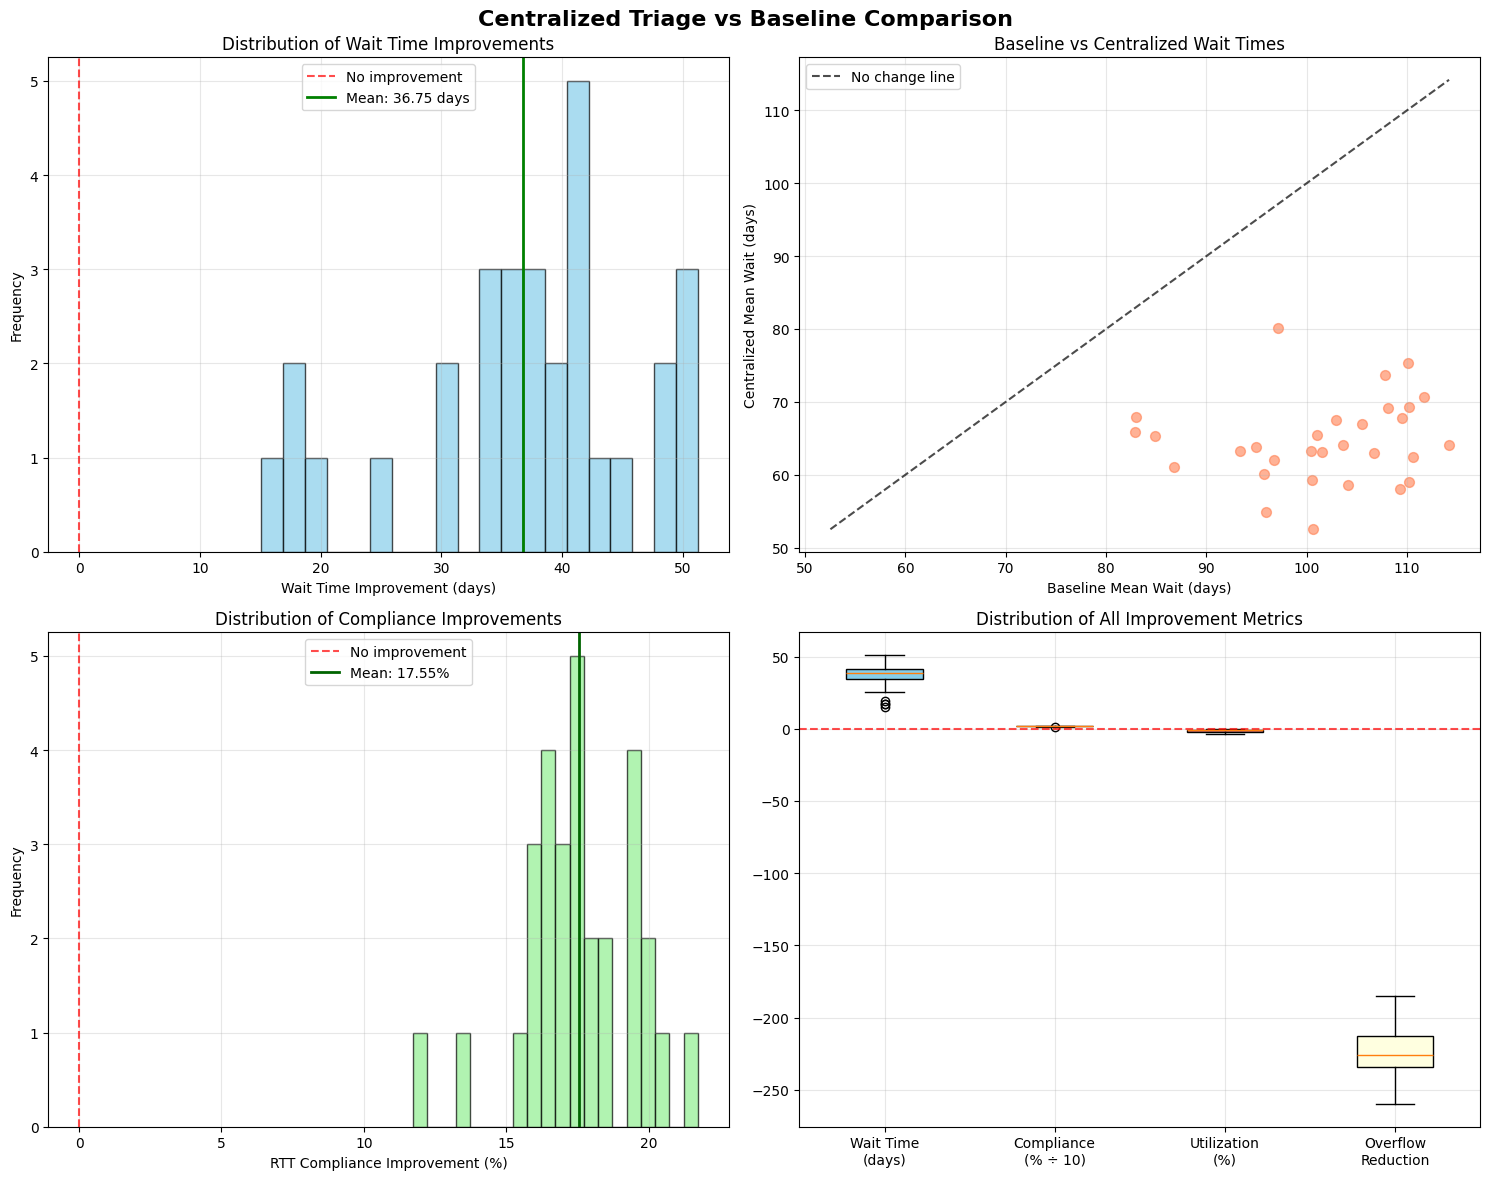

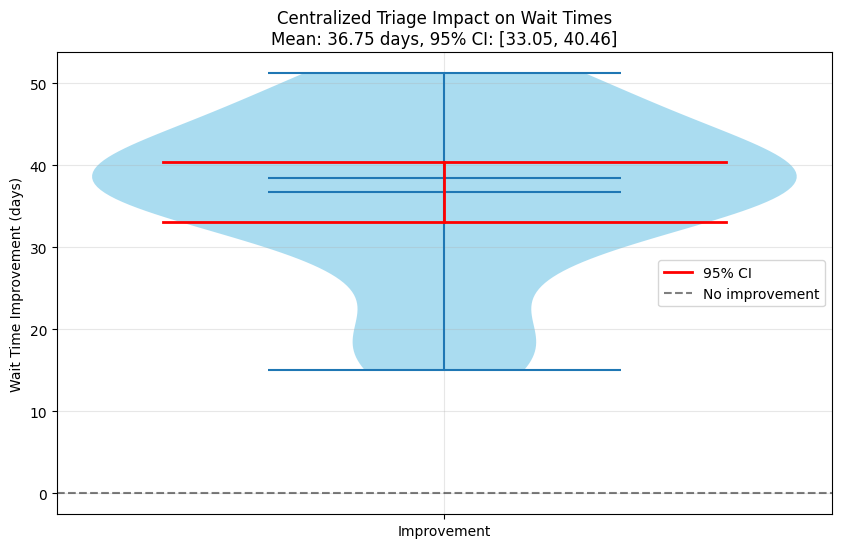


Results exported to:
  - triage_comparison_raw_results.csv
  - triage_comparison_analysis.json
  - triage_comparison_summary_stats.csv
Mean wait time improvement: 36.75 days
95% Confidence Interval: [33.11089599707551, 40.397723503987486]
Probability of improvement: 100.0%


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


class TriageComparisonAnalyzer:
    
    def __init__(self, n_simulations: int = 50, base_seed: int = 42):
       
        self.n_simulations = n_simulations
        self.base_seed = base_seed
        self.results = []
        self.comparison_metrics = []
        
    def run_single_comparison(self, seed: int) -> Dict:
        """Run a single baseline vs centralized comparison."""
        
        # Baseline simulation
        baseline_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=seed)
        baseline_sim.set_policy(NoopPolicy())
        baseline_results = baseline_sim.run_simulation(
            duration_days=365,  # Shorter for faster iterations
            arrival_method='autocorrelated',
            backlog_days=60,
            warmup_days=180
        )
        
        # Centralized triage simulation (same seed for fair comparison)
        centralized_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=seed)
        centralized_policy = CentralizedTriagePolicy(
            capacity_weight=0.4,
            workload_weight=0.3,
            complexity_weight=0.2,
            distance_weight=0.1,
            max_assignments_per_day=50  # Limit daily changes for stability
        )
        centralized_sim.set_policy(centralized_policy)
        centralized_results = centralized_sim.run_simulation(
            duration_days=365,
            arrival_method='autocorrelated',
            backlog_days=60,
            warmup_days=180
        )
        
        # Calculate key metrics
        wait_improvement = baseline_results['mean_current_wait'] - centralized_results['mean_current_wait']
        compliance_improvement = centralized_results['rtt_compliance_pct'] - baseline_results['rtt_compliance_pct']
        utilization_improvement = centralized_results['capacity_utilization'] - baseline_results['capacity_utilization']
        overflow_reduction = baseline_results['avg_daily_overflow'] - centralized_results['avg_daily_overflow']
        
        return {
            'seed': seed,
            'baseline_mean_wait': baseline_results['mean_current_wait'],
            'centralized_mean_wait': centralized_results['mean_current_wait'],
            'wait_improvement_days': wait_improvement,
            'baseline_compliance': baseline_results['rtt_compliance_pct'],
            'centralized_compliance': centralized_results['rtt_compliance_pct'],
            'compliance_improvement_pct': compliance_improvement,
            'baseline_utilization': baseline_results['capacity_utilization'],
            'centralized_utilization': centralized_results['capacity_utilization'],
            'utilization_improvement_pct': utilization_improvement,
            'baseline_overflow': baseline_results['avg_daily_overflow'],
            'centralized_overflow': centralized_results['avg_daily_overflow'],
            'overflow_reduction': overflow_reduction,
            'baseline_completed': baseline_results['completed_surgeries'],
            'centralized_completed': centralized_results['completed_surgeries'],
            'baseline_pending': baseline_results['pending_surgeries'],
            'centralized_pending': centralized_results['pending_surgeries']
        }
    
    def run_full_comparison(self, progress_callback=None) -> pd.DataFrame:
        """
        Run full set of simulation comparisons.
        
        Args:
            progress_callback: Optional function to call with progress updates
            
        Returns:
            DataFrame with all comparison results
        """
        print(f"Running {self.n_simulations} simulation pairs")
        print(f"Each pair: baseline vs centralized triage (same seed)")
        
        results = []
        for i in range(self.n_simulations):
            seed = self.base_seed + i
            
            if progress_callback:
                progress_callback(i, self.n_simulations)
            elif i % 10 == 0:
                print(f"Completed {i}/{self.n_simulations} pairs")
            
            try:
                result = self.run_single_comparison(seed)
                results.append(result)
            except Exception as e:
                print(f"Error in simulation {i} (seed {seed}): {e}")
                continue
        
        self.results = results
        return pd.DataFrame(results)
    
    def analyze_results(self, df: pd.DataFrame) -> Dict:
        """Perform statistical analysis on results."""
        
        # Primary outcome: wait time improvement
        wait_improvements = df['wait_improvement_days'].values
        mean_improvement = np.mean(wait_improvements)
        std_improvement = np.std(wait_improvements)
        
        # 95% confidence interval for mean improvement
        n = len(wait_improvements)
        sem = std_improvement / np.sqrt(n)
        ci_lower, ci_upper = stats.t.interval(0.95, n-1, mean_improvement, sem)
        
        # Probability of improvement (% of simulations with positive improvement)
        prob_improvement = np.mean(wait_improvements > 0) * 100
        
        # Effect size (Cohen's d)
        baseline_waits = df['baseline_mean_wait'].values
        centralized_waits = df['centralized_mean_wait'].values
        pooled_std = np.sqrt((np.var(baseline_waits) + np.var(centralized_waits)) / 2)
        cohens_d = mean_improvement / pooled_std if pooled_std > 0 else 0
        
        # Statistical significance test
        t_stat, p_value = stats.ttest_rel(baseline_waits, centralized_waits)
        
        # Secondary outcomes
        compliance_improvements = df['compliance_improvement_pct'].values
        utilization_improvements = df['utilization_improvement_pct'].values
        overflow_reductions = df['overflow_reduction'].values
        
        analysis = {
            'primary_outcome': {
                'metric': 'wait_time_improvement_days',
                'mean': mean_improvement,
                'std': std_improvement,
                'ci_95': [ci_lower, ci_upper],
                'probability_of_improvement_pct': prob_improvement,
                'effect_size_cohens_d': cohens_d,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant_at_005': p_value < 0.05
            },
            'secondary_outcomes': {
                'compliance_improvement': {
                    'mean': np.mean(compliance_improvements),
                    'std': np.std(compliance_improvements),
                    'prob_improvement_pct': np.mean(compliance_improvements > 0) * 100
                },
                'utilization_improvement': {
                    'mean': np.mean(utilization_improvements), 
                    'std': np.std(utilization_improvements),
                    'prob_improvement_pct': np.mean(utilization_improvements > 0) * 100
                },
                'overflow_reduction': {
                    'mean': np.mean(overflow_reductions),
                    'std': np.std(overflow_reductions),
                    'prob_improvement_pct': np.mean(overflow_reductions > 0) * 100
                }
            },
            'simulation_summary': {
                'n_simulations': len(df),
                'n_successful': len(df),
                'baseline_mean_wait_overall': np.mean(df['baseline_mean_wait']),
                'centralized_mean_wait_overall': np.mean(df['centralized_mean_wait']),
                'baseline_compliance_overall': np.mean(df['baseline_compliance']),
                'centralized_compliance_overall': np.mean(df['centralized_compliance'])
            }
        }
        
        return analysis
    
    def create_visualizations(self, df: pd.DataFrame, save_prefix: str = "triage_comparison"):
        """Create visualization plots for the analysis."""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Centralized Triage vs Baseline Comparison', fontsize=16, fontweight='bold')
        
        # 1. Wait time improvement distribution
        axes[0,0].hist(df['wait_improvement_days'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(0, color='red', linestyle='--', alpha=0.7, label='No improvement')
        axes[0,0].axvline(df['wait_improvement_days'].mean(), color='green', linestyle='-', linewidth=2, 
                         label=f'Mean: {df["wait_improvement_days"].mean():.2f} days')
        axes[0,0].set_xlabel('Wait Time Improvement (days)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Wait Time Improvements')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Scatter plot: baseline vs centralized wait times
        axes[0,1].scatter(df['baseline_mean_wait'], df['centralized_mean_wait'], 
                         alpha=0.6, s=50, color='coral')
        # Add diagonal line (y = x) for reference
        min_wait = min(df['baseline_mean_wait'].min(), df['centralized_mean_wait'].min())
        max_wait = max(df['baseline_mean_wait'].max(), df['centralized_mean_wait'].max())
        axes[0,1].plot([min_wait, max_wait], [min_wait, max_wait], 
                      'k--', alpha=0.7, label='No change line')
        axes[0,1].set_xlabel('Baseline Mean Wait (days)')
        axes[0,1].set_ylabel('Centralized Mean Wait (days)')
        axes[0,1].set_title('Baseline vs Centralized Wait Times')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Compliance improvement
        axes[1,0].hist(df['compliance_improvement_pct'], bins=20, alpha=0.7, 
                      color='lightgreen', edgecolor='black')
        axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7, label='No improvement')
        axes[1,0].axvline(df['compliance_improvement_pct'].mean(), color='darkgreen', 
                         linestyle='-', linewidth=2, 
                         label=f'Mean: {df["compliance_improvement_pct"].mean():.2f}%')
        axes[1,0].set_xlabel('RTT Compliance Improvement (%)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Distribution of Compliance Improvements')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Multiple outcomes box plot
        outcomes_data = [
            df['wait_improvement_days'],
            df['compliance_improvement_pct'] / 10,  # Scale for visibility
            df['utilization_improvement_pct'],
            df['overflow_reduction']
        ]
        outcomes_labels = ['Wait Time\n(days)', 'Compliance\n(% ÷ 10)', 
                          'Utilization\n(%)', 'Overflow\nReduction']
        
        bp = axes[1,1].boxplot(outcomes_data, labels=outcomes_labels, patch_artist=True)
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[1,1].set_title('Distribution of All Improvement Metrics')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additional detailed plot for wait times
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create violin plot for wait time improvements
        parts = ax.violinplot([df['wait_improvement_days']], positions=[1], 
                             showmeans=True, showmedians=True)
        parts['bodies'][0].set_facecolor('skyblue')
        parts['bodies'][0].set_alpha(0.7)
        
        # Add confidence interval
        mean_imp = df['wait_improvement_days'].mean()
        std_imp = df['wait_improvement_days'].std()
        n = len(df)
        sem = std_imp / np.sqrt(n)
        ci_lower, ci_upper = stats.t.interval(0.95, n-1, mean_imp, sem)
        
        ax.plot([0.8, 1.2], [ci_lower, ci_lower], 'r-', linewidth=2, label='95% CI')
        ax.plot([0.8, 1.2], [ci_upper, ci_upper], 'r-', linewidth=2)
        ax.plot([1, 1], [ci_lower, ci_upper], 'r-', linewidth=2)
        
        ax.axhline(0, color='black', linestyle='--', alpha=0.5, label='No improvement')
        ax.set_ylabel('Wait Time Improvement (days)')
        ax.set_title(f'Centralized Triage Impact on Wait Times\n'
                    f'Mean: {mean_imp:.2f} days, 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
        ax.set_xticks([1])
        ax.set_xticklabels(['Improvement'])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.savefig(f'{save_prefix}_wait_times_detailed.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_summary_report(self, analysis: Dict):
        """Print a comprehensive summary report."""

        primary = analysis['primary_outcome']
        secondary = analysis['secondary_outcomes']
        summary = analysis['simulation_summary']
        
        print(f"\nSIMULATION OVERVIEW:")
        print(f"Number of simulation pairs: {summary['n_successful']}")
        print(f"Baseline average wait time: {summary['baseline_mean_wait_overall']:.1f} days")
        print(f"Centralized average wait time: {summary['centralized_mean_wait_overall']:.1f} days")
        print(f"Baseline RTT compliance: {summary['baseline_compliance_overall']:.1f}%")
        print(f"Centralized RTT compliance: {summary['centralized_compliance_overall']:.1f}%")
        
        print(f"\nPRIMARY OUTCOME - WAIT TIME IMPROVEMENT:")
        print(f"Mean improvement: {primary['mean']:.2f} days")
        print(f"95% Confidence Interval: [{primary['ci_95'][0]:.2f}, {primary['ci_95'][1]:.2f}] days")
        print(f"Standard deviation: {primary['std']:.2f} days")
        print(f"Probability of improvement: {primary['probability_of_improvement_pct']:.1f}%")
        print(f"Effect size (Cohen's d): {primary['effect_size_cohens_d']:.3f}")
        
        # Interpret effect size
        if abs(primary['effect_size_cohens_d']) < 0.2:
            effect_interpretation = "negligible"
        elif abs(primary['effect_size_cohens_d']) < 0.5:
            effect_interpretation = "small"
        elif abs(primary['effect_size_cohens_d']) < 0.8:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        print(f"Effect size interpretation: {effect_interpretation}")
        
        print(f"\nSTATISTICAL SIGNIFICANCE:")
        print(f"t-statistic: {primary['t_statistic']:.3f}")
        print(f"p-value: {primary['p_value']:.4f}")
        print(f"Significant at α = 0.05: {'Yes' if primary['significant_at_005'] else 'No'}")
        
        print(f"\nSECONDARY OUTCOMES:")
        for outcome, data in secondary.items():
            outcome_name = outcome.replace('_', ' ').title()
            print(f"{outcome_name}:")
            print(f"  Mean improvement: {data['mean']:.2f}")
            print(f"  Probability of improvement: {data['prob_improvement_pct']:.1f}%")
        
        print(f"\nRECOMMENDATION:")
        if primary['probability_of_improvement_pct'] >= 70 and primary['mean'] > 0:
            if primary['significant_at_005']:
                recommendation = "STRONG EVIDENCE for centralized triage. Statistically significant improvement."
            else:
                recommendation = "MODERATE EVIDENCE for centralized triage. Consistent positive trend."
        elif primary['probability_of_improvement_pct'] >= 60:
            recommendation = "WEAK EVIDENCE for centralized triage. Consider pilot implementation."
        else:
            recommendation = "INSUFFICIENT EVIDENCE for centralized triage. More analysis needed."
        
        print(f"{recommendation}")
        
    
    def export_results(self, df: pd.DataFrame, analysis: Dict, filename_prefix: str = "triage_comparison"):
        """Export results"""
        
        # Export raw data
        df.to_csv(f"{filename_prefix}_raw_results.csv", index=False)
        
        # Export analysis summary
        with open(f"{filename_prefix}_analysis.json", 'w') as f:
            # Convert numpy types to Python types for JSON serialization
            analysis_json = json.loads(json.dumps(analysis, default=lambda x: float(x) if hasattr(x, 'dtype') else x))
            json.dump(analysis_json, f, indent=2)
        
        # Export summary statistics
        summary_stats = {
            'metric': ['wait_improvement_days', 'compliance_improvement_pct', 
                      'utilization_improvement_pct', 'overflow_reduction'],
            'mean': [df['wait_improvement_days'].mean(), df['compliance_improvement_pct'].mean(),
                    df['utilization_improvement_pct'].mean(), df['overflow_reduction'].mean()],
            'std': [df['wait_improvement_days'].std(), df['compliance_improvement_pct'].std(),
                   df['utilization_improvement_pct'].std(), df['overflow_reduction'].std()],
            'prob_improvement': [
                (df['wait_improvement_days'] > 0).mean() * 100,
                (df['compliance_improvement_pct'] > 0).mean() * 100,
                (df['utilization_improvement_pct'] > 0).mean() * 100,
                (df['overflow_reduction'] > 0).mean() * 100
            ]
        }
        
        summary_df = pd.DataFrame(summary_stats)
        summary_df.to_csv(f"{filename_prefix}_summary_stats.csv", index=False)
        
        print(f"\nResults exported to:")
        print(f"  - {filename_prefix}_raw_results.csv")
        print(f"  - {filename_prefix}_analysis.json") 
        print(f"  - {filename_prefix}_summary_stats.csv")


def run_enhanced_comparison(n_simulations: int = 50):
    """
    Main function to run enhanced triage comparison analysis.
    
    Args:
        n_simulations: Number of simulation pairs to run
    """
    
    analyzer = TriageComparisonAnalyzer(n_simulations=n_simulations)
    
    # Progress callback
    def progress(current, total):
        percent = (current / total) * 100
        print(f"Progress: {current}/{total} ({percent:.1f}%)")
    
    # Run simulations
    start_time = datetime.now()
    results_df = analyzer.run_full_comparison(progress_callback=progress)
    end_time = datetime.now()
    
    print(f"\nSimulations completed in {end_time - start_time}")
    print(f"Successful simulation pairs: {len(results_df)}")
    
    # Analyze results
    analysis = analyzer.analyze_results(results_df)
    
    # Print report
    analyzer.print_summary_report(analysis)
    
    # Create visualizations
    analyzer.create_visualizations(results_df)
    
    # Export results
    analyzer.export_results(results_df, analysis)
    
    return results_df, analysis


if __name__ == "__main__":
    results_df, analysis = run_enhanced_comparison(n_simulations=30)
    
    print(f"Mean wait time improvement: {analysis['primary_outcome']['mean']:.2f} days")
    print(f"95% Confidence Interval: {analysis['primary_outcome']['ci_95']}")
    print(f"Probability of improvement: {analysis['primary_outcome']['probability_of_improvement_pct']:.1f}%")

## Proactive Triage 

In [12]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

class ProactiveCentralTriagePolicy(TriagePolicy):
    """
    Proactive central triage with early independent sector integration.
    """
    
    def __init__(self, 
                 urgency_weight: float = 0.35,
                 availability_weight: float = 0.25,
                 complexity_match_weight: float = 0.20,
                 capacity_balance_weight: float = 0.15,
                 geographic_weight: float = 0.05,
                 independent_sector_utilization_target: float = 0.6,
                 max_daily_reassignments: Optional[int] = None,
                 early_routing_threshold_days: int = 98):  # Route early, before 18-week limit
        """
        Initialize proactive central triage policy.
        
        Args:
            urgency_weight: Weight for clinical urgency in routing decisions
            availability_weight: Weight for provider availability 
            complexity_match_weight: Weight for complexity-provider matching
            capacity_balance_weight: Weight for load balancing across system
            geographic_weight: Weight for geographic proximity
            independent_sector_utilization_target: Target % of patients to IS providers
            max_daily_reassignments: Maximum reassignments per day
            early_routing_threshold_days: Start proactive routing when wait > this many days
        """
        self.urgency_weight = urgency_weight
        self.availability_weight = availability_weight
        self.complexity_match_weight = complexity_match_weight
        self.capacity_balance_weight = capacity_balance_weight
        self.geographic_weight = geographic_weight
        self.is_utilization_target = independent_sector_utilization_target
        self.max_daily_reassignments = max_daily_reassignments
        self.early_routing_threshold = early_routing_threshold_days
        
        # Tracking variables
        self.daily_reassignments = defaultdict(int)
        self.provider_workload = defaultdict(int)
        self.daily_is_assignments = defaultdict(int)
        self.daily_total_assignments = defaultdict(int)
        
        # Provider categorization and capabilities
        self.independent_providers = {
            'SPAMEDICA', 'NEWMEDICA', 'FITZWILLIAM', 'SPECSAVERS',
            'OPTICAL', 'PRIVATE', 'INDEPENDENT'
        }
        
        self.nhs_providers = {
            'CAMBRIDGE', 'ANGLIA', 'NORTH', 'WEST', 'SOUTH', 'EAST',
            'COMMUNITY', 'DISTRICT', 'GENERAL'
        }
        
        # Enhanced provider capabilities matrix
        self.provider_capabilities = {
            # Independent sector - typically high volume, standardized cases
            'SPAMEDICA': {
                'max_complexity': 8, 'preferred_complexity': [1, 2, 3],
                'high_volume': True, 'specialty_score': 0.9,
                'typical_capacity': 45, 'rapid_access': True
            },
            'NEWMEDICA': {
                'max_complexity': 8, 'preferred_complexity': [1, 2, 3, 4],
                'high_volume': True, 'specialty_score': 0.85,
                'typical_capacity': 35, 'rapid_access': True
            },
            'FITZWILLIAM': {
                'max_complexity': 7, 'preferred_complexity': [1, 2, 3],
                'high_volume': False, 'specialty_score': 0.8,
                'typical_capacity': 25, 'rapid_access': True
            },
            
            # NHS providers - broader complexity range, mixed capacity
            'CAMBRIDGE': {
                'max_complexity': 9, 'preferred_complexity': [4, 5, 6, 7, 8, 9],
                'high_volume': True, 'specialty_score': 0.95,
                'typical_capacity': 30, 'rapid_access': False
            },
            'ANGLIA': {
                'max_complexity': 8, 'preferred_complexity': [3, 4, 5, 6, 7],
                'high_volume': True, 'specialty_score': 0.85,
                'typical_capacity': 25, 'rapid_access': False
            },
            'NORTH': {
                'max_complexity': 7, 'preferred_complexity': [2, 3, 4, 5],
                'high_volume': True, 'specialty_score': 0.8,
                'typical_capacity': 20, 'rapid_access': False
            }
        }
        
        # Performance tracking
        self.routing_decisions = []
        self.policy_metrics = {
            'total_early_interventions': 0,
            'is_utilization_achieved': 0.0,
            'complexity_mismatches': 0,
            'urgent_case_routing_time': []
        }
    
    def assign_provider(self, patient, date: pd.Timestamp, sim) -> Optional[str]:
        """
        Proactive central routing logic - acts early and considers all factors.
        """
        # Reset daily counters for new day
        date_key = date.date()
        if date_key not in self.daily_reassignments:
            self._reset_daily_counters(date_key)
        
        # Check daily reassignment limits
        if (self.max_daily_reassignments and 
            self.daily_reassignments[date_key] >= self.max_daily_reassignments):
            return None
        
        # Update system state
        self._update_system_state(sim, date)
        
        # Determine if patient needs proactive routing
        if not self._needs_proactive_routing(patient, date):
            return None
        
        # Get all available providers
        available_providers = self._get_available_providers(sim)
        if not available_providers:
            return None
        
        # Calculate routing scores for each provider
        provider_scores = {}
        for provider in available_providers:
            score = self._calculate_proactive_routing_score(patient, provider, date, sim)
            provider_scores[provider] = score
        
        # Select optimal provider
        optimal_provider = self._select_optimal_provider(
            patient, provider_scores, date, sim
        )
        
        if optimal_provider and optimal_provider != patient.surgery_provider:
            # Execute the routing decision
            self._execute_routing_decision(patient, optimal_provider, date, sim)
            return optimal_provider
        
        return None
    
    def _reset_daily_counters(self, date_key):
        """Reset counters for new day."""
        self.daily_reassignments.clear()
        self.daily_reassignments[date_key] = 0
        self.daily_is_assignments[date_key] = 0
        self.daily_total_assignments[date_key] = 0
    
    def _needs_proactive_routing(self, patient, date: pd.Timestamp) -> bool:
        """
        Determine if patient needs proactive routing.
        Acts much earlier than traditional breach-prevention policies.
        """
        days_waiting = patient.days_waiting(date)
        days_until_target = patient.days_until_target(date)
        
        # Always consider high-priority cases
        if patient.priority >= 4:
            return True
        
        # Early intervention for anyone waiting > threshold
        if days_waiting > self.early_routing_threshold:
            return True
        
        # Proactive routing for complex cases that might face delays
        if patient.complexity_level >= 6 and days_waiting > 70:
            return True
        
        # Route routine cases approaching target
        if days_until_target < 42 and days_waiting > 84:  # 6 weeks before breach
            return True
        
        # Capacity balancing - route if current provider seems overloaded
        return self._provider_appears_overloaded(patient.surgery_provider)
    
    def _provider_appears_overloaded(self, provider: str) -> bool:
        """Check if provider appears overloaded based on workload tracking."""
        current_load = self.provider_workload.get(provider, 0)
        avg_load = np.mean(list(self.provider_workload.values())) if self.provider_workload else 0
        return current_load > avg_load * 1.3  # 30% above average
    
    def _get_available_providers(self, sim) -> List[str]:
        """Get all available providers, both NHS and independent sector."""
        available = list(sim._known_providers)
        
        # Filter out providers with very low capacity estimates
        filtered = [p for p in available 
                   if sim._provider_cap_estimate.get(p, 0) > 0.5]
        
        return filtered
    
    def _calculate_proactive_routing_score(self, patient, provider: str, 
                                         date: pd.Timestamp, sim) -> float:
        """
        Calculate comprehensive routing score for proactive assignment.
        Higher score = better match for early routing.
        """
        score = 0.0
        
        # 1. Urgency matching - urgent cases prioritize rapid access providers
        urgency_score = self._calculate_urgency_match_score(patient, provider)
        score += self.urgency_weight * urgency_score
        
        # 2. Availability score - current capacity and workload
        availability_score = self._calculate_availability_score(provider, sim)
        score += self.availability_weight * availability_score
        
        # 3. Complexity matching - match case complexity to provider capability
        complexity_score = self._calculate_complexity_match_score(patient, provider)
        score += self.complexity_match_weight * complexity_score
        
        # 4. Capacity balancing - encourage load spreading
        balance_score = self._calculate_capacity_balance_score(provider)
        score += self.capacity_balance_weight * balance_score
        
        # 5. Geographic/access score
        geographic_score = self._calculate_geographic_score(patient, provider)
        score += self.geographic_weight * geographic_score
        
        # 6. Strategic IS utilization bonus
        if self._should_prioritize_is_routing(provider, date):
            score *= 1.15  # 15% bonus for IS providers when needed
        
        return score
    
    def _calculate_urgency_match_score(self, patient, provider: str) -> float:
        """Score based on urgency and provider's rapid access capability."""
        provider_info = self.provider_capabilities.get(provider, {})
        rapid_access = provider_info.get('rapid_access', False)
        
        # High priority patients benefit more from rapid access providers
        if patient.priority >= 4:
            return 1.0 if rapid_access else 0.6
        elif patient.priority >= 2:
            return 0.9 if rapid_access else 0.8
        else:
            return 0.7 if rapid_access else 0.9  # Routine cases fine with either
    
    def _calculate_availability_score(self, provider: str, sim) -> float:
        """Score based on current capacity and workload."""
        capacity_estimate = sim._provider_cap_estimate.get(provider, 1.0)
        current_workload = self.provider_workload.get(provider, 0)
        
        # Normalize capacity (0-1 scale)
        normalized_capacity = min(1.0, capacity_estimate / 50.0)
        
        # Workload penalty
        max_workload = max(self.provider_workload.values()) if self.provider_workload else 1
        workload_penalty = current_workload / max(max_workload, 1) if max_workload > 0 else 0
        
        return normalized_capacity * (1.0 - workload_penalty * 0.5)
    
    def _calculate_complexity_match_score(self, patient, provider: str) -> float:
        """Score based on how well provider handles patient complexity."""
        provider_info = self.provider_capabilities.get(provider, {
            'max_complexity': 5, 'preferred_complexity': [1, 2, 3],
            'specialty_score': 0.7
        })
        
        max_complexity = provider_info['max_complexity']
        preferred_complexity = provider_info['preferred_complexity']
        specialty_score = provider_info['specialty_score']
        
        patient_complexity = patient.complexity_level
        
        # Perfect match if in preferred range
        if patient_complexity in preferred_complexity:
            return specialty_score * 1.0
        elif patient_complexity <= max_complexity:
            return specialty_score * 0.8
        else:
            # Significant penalty for complexity mismatch
            return specialty_score * 0.3
    
    def _calculate_capacity_balance_score(self, provider: str) -> float:
        """Encourage load balancing across the system."""
        current_load = self.provider_workload.get(provider, 0)
        avg_load = np.mean(list(self.provider_workload.values())) if self.provider_workload else 0
        
        if avg_load == 0:
            return 1.0
        
        # Higher score for providers with below-average load
        load_ratio = current_load / avg_load
        return max(0.2, 1.5 - load_ratio)  # Inverted relationship
    
    def _calculate_geographic_score(self, patient, provider: str) -> float:
        """Geographic accessibility score (simplified)."""
        # Enhanced accessibility model
        accessibility_scores = {
            # NHS providers - generally good geographic coverage
            'CAMBRIDGE': 0.9, 'ANGLIA': 0.85, 'NORTH': 0.9, 'WEST': 0.8,
            'SOUTH': 0.85, 'EAST': 0.8, 'COMMUNITY': 0.95,
            
            # Independent sector - may have different geographic coverage
            'SPAMEDICA': 0.8, 'NEWMEDICA': 0.75, 'FITZWILLIAM': 0.7,
            'SPECSAVERS': 0.9, 'OPTICAL': 0.85
        }
        
        return accessibility_scores.get(provider, 0.75)
    
    def _should_prioritize_is_routing(self, provider: str, date: pd.Timestamp) -> bool:
        """Check if we should give IS providers routing priority."""
        date_key = date.date()
        
        # Check if provider is IS
        is_independent = any(is_name in provider.upper() for is_name in self.independent_providers)
        if not is_independent:
            return False
        
        # Check current IS utilization vs target
        total_today = self.daily_total_assignments.get(date_key, 0)
        is_today = self.daily_is_assignments.get(date_key, 0)
        
        if total_today == 0:
            return True  # Start with IS routing
        
        current_is_rate = is_today / total_today
        return current_is_rate < self.is_utilization_target
    
    def _select_optimal_provider(self, patient, provider_scores: Dict[str, float], 
                               date: pd.Timestamp, sim) -> Optional[str]:
        """Select the optimal provider considering all constraints."""
        if not provider_scores:
            return None
        
        # Sort providers by score (descending)
        sorted_providers = sorted(provider_scores.items(), 
                                key=lambda x: x[1], reverse=True)
        
        # Get current provider score for comparison
        current_provider = patient.surgery_provider
        current_score = provider_scores.get(current_provider, 0)
        
        # Select best provider that's significantly better
        for provider, score in sorted_providers:
            if provider != current_provider and score > current_score * 1.05:  # 5% improvement threshold
                return provider
        
        return None  # Keep current assignment
    
    def _execute_routing_decision(self, patient, new_provider: str, 
                                date: pd.Timestamp, sim):
        """Execute the routing decision and update tracking."""
        date_key = date.date()
        old_provider = patient.surgery_provider
        
        # Update counters
        self.daily_reassignments[date_key] += 1
        self.daily_total_assignments[date_key] += 1
        
        # Track IS assignments
        is_independent = any(is_name in new_provider.upper() for is_name in self.independent_providers)
        if is_independent:
            self.daily_is_assignments[date_key] += 1
        
        # Update workload tracking
        self.provider_workload[new_provider] += 1
        if old_provider in self.provider_workload:
            self.provider_workload[old_provider] = max(0, self.provider_workload[old_provider] - 1)
        
        # Update patient attributes for IS providers
        if is_independent:
            patient.provider_type = 'Independent'
            patient.is_independent_sector = True
        
        # Track policy metrics
        days_waiting = patient.days_waiting(date)
        if days_waiting <= self.early_routing_threshold:
            self.policy_metrics['total_early_interventions'] += 1
        
        if patient.priority >= 4:
            self.policy_metrics['urgent_case_routing_time'].append(days_waiting)
        
        # Record routing decision for analysis
        self.routing_decisions.append({
            'patient_id': patient.patient_id,
            'date': date,
            'old_provider': old_provider,
            'new_provider': new_provider,
            'days_waiting': days_waiting,
            'priority': patient.priority,
            'complexity': patient.complexity_level,
            'reason': 'proactive_routing'
        })
    
    def _update_system_state(self, sim, date: pd.Timestamp):
        """Update understanding of system state."""
        # Reset workload counters
        self.provider_workload.clear()
        
        # Count current queue by provider
        for patient in sim.waiting_queue:
            if not patient.completed and not patient.cancelled:
                self.provider_workload[patient.surgery_provider] += 1
        
        # Update IS utilization tracking
        date_key = date.date()
        if date_key in self.daily_total_assignments:
            total = self.daily_total_assignments[date_key]
            is_count = self.daily_is_assignments[date_key]
            if total > 0:
                self.policy_metrics['is_utilization_achieved'] = is_count / total
    
    def get_policy_stats(self) -> Dict:
        """Get comprehensive policy performance statistics."""
        total_reassignments = sum(self.daily_reassignments.values())
        total_assignments = sum(self.daily_total_assignments.values())
        total_is_assignments = sum(self.daily_is_assignments.values())
        
        active_days = len([d for d in self.daily_reassignments.values() if d > 0])
        
        urgent_routing_stats = {}
        if self.policy_metrics['urgent_case_routing_time']:
            urgent_times = self.policy_metrics['urgent_case_routing_time']
            urgent_routing_stats = {
                'mean_urgent_routing_time': np.mean(urgent_times),
                'median_urgent_routing_time': np.median(urgent_times),
                'urgent_cases_routed_early': sum(1 for t in urgent_times if t <= self.early_routing_threshold)
            }
        
        return {
            'policy_name': 'ProactiveCentralTriage',
            'total_reassignments': total_reassignments,
            'total_assignments': total_assignments,
            'avg_daily_reassignments': total_reassignments / max(1, active_days),
            'is_utilization_target': self.is_utilization_target,
            'is_utilization_achieved': total_is_assignments / max(1, total_assignments),
            'early_interventions': self.policy_metrics['total_early_interventions'],
            'early_routing_threshold_days': self.early_routing_threshold,
            'active_routing_days': active_days,
            'routing_decisions_made': len(self.routing_decisions),
            'urgent_case_stats': urgent_routing_stats,
            'provider_workload_balance': {
                'max_workload': max(self.provider_workload.values()) if self.provider_workload else 0,
                'min_workload': min(self.provider_workload.values()) if self.provider_workload else 0,
                'workload_std': float(np.std(list(self.provider_workload.values()))) if self.provider_workload else 0
            }
        }
    
    def get_routing_analysis(self) -> pd.DataFrame:
        """Get detailed analysis of routing decisions made."""
        if not self.routing_decisions:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.routing_decisions)
        return df


# Comparison function for proactive vs other policies
def run_proactive_triage_comparison():
    """
    Compare baseline, centralized, and proactive triage policies.
    """
    print("COMPREHENSIVE TRIAGE POLICY COMPARISON")
    
    results = {}
    
    # 1. Baseline 
    print("\n1. Running BASELINE simulation")
    baseline_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    baseline_sim.set_policy(NoopPolicy())
    results['baseline'] = baseline_sim.run_simulation(
        duration_days=365, arrival_method='autocorrelated',
        backlog_days=60, warmup_days=180
    )
    
    # 2. Centralized Triage
    print("\n2. Running CENTRALIZED TRIAGE simulation")
    centralized_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    centralized_policy = CentralizedTriagePolicy()
    centralized_sim.set_policy(centralized_policy)
    results['centralized'] = centralized_sim.run_simulation(
        duration_days=365, arrival_method='autocorrelated',
        backlog_days=60, warmup_days=180
    )
    
    # 3. Proactive Central Triage
    print("\n3. Running PROACTIVE CENTRAL TRIAGE simulation")
    proactive_sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
    proactive_policy = ProactiveCentralTriagePolicy(
        urgency_weight=0.35,
        availability_weight=0.25,
        complexity_match_weight=0.20,
        capacity_balance_weight=0.15,
        independent_sector_utilization_target=0.65,
        early_routing_threshold_days=98
    )
    proactive_sim.set_policy(proactive_policy)
    results['proactive'] = proactive_sim.run_simulation(
        duration_days=365, arrival_method='autocorrelated',
        backlog_days=60, warmup_days=180
    )
    
    # 4. Generate comparison report
    print("\n4. COMPREHENSIVE COMPARISON")
    
    policies = ['baseline', 'centralized', 'proactive']
    metrics = ['mean_current_wait', 'median_current_wait', 'rtt_compliance_pct', 
              'capacity_utilization', 'independent_sector_rate_pct']
    
    comparison_table = {}
    for metric in metrics:
        comparison_table[metric] = {policy: results[policy][metric] for policy in policies}
    
    # Print comparison table
    for metric in metrics:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        for policy in policies:
            value = comparison_table[metric][policy]
            print(f"  {policy.capitalize()}: {value:.1f}")
    
    # Policy-specific metrics
    print(f"\nPOLICY-SPECIFIC METRICS:")
    
    centralized_stats = centralized_policy.get_policy_stats()
    print(f"\nCentralized Triage:")
    print(f"  Total reassignments: {centralized_stats['total_reassignments']:,}")
    print(f"  Avg daily reassignments: {centralized_stats['avg_daily_reassignments']:.1f}")
    
    proactive_stats = proactive_policy.get_policy_stats()
    print(f"\nProactive Central Triage:")
    print(f"  Total reassignments: {proactive_stats['total_reassignments']:,}")
    print(f"  Early interventions: {proactive_stats['early_interventions']:,}")
    print(f"  IS utilization target: {proactive_stats['is_utilization_target']:.1%}")
    print(f"  IS utilization achieved: {proactive_stats['is_utilization_achieved']:.1%}")
    print(f"  Routing threshold: {proactive_stats['early_routing_threshold_days']} days")
    
    if proactive_stats['urgent_case_stats']:
        urgent_stats = proactive_stats['urgent_case_stats']
        print(f"  Mean urgent case routing time: {urgent_stats['mean_urgent_routing_time']:.1f} days")
    
    # Calculate improvements
    print(f"\nIMPROVEMENT ANALYSIS:")
    print(f"Proactive vs Baseline:")
    print(f"  Wait time reduction: {results['baseline']['mean_current_wait'] - results['proactive']['mean_current_wait']:+.1f} days")
    print(f"  Compliance improvement: {results['proactive']['rtt_compliance_pct'] - results['baseline']['rtt_compliance_pct']:+.1f}%")
    print(f"  IS utilization change: {results['proactive']['independent_sector_rate_pct'] - results['baseline']['independent_sector_rate_pct']:+.1f}%")
    
    print(f"\nProactive vs Centralized:")
    print(f"  Wait time difference: {results['centralized']['mean_current_wait'] - results['proactive']['mean_current_wait']:+.1f} days")
    print(f"  Compliance difference: {results['proactive']['rtt_compliance_pct'] - results['centralized']['rtt_compliance_pct']:+.1f}%")
    
    return {
        'results': results,
        'centralized_stats': centralized_stats,
        'proactive_stats': proactive_stats
    }


In [7]:
results = run_proactive_triage_comparison()


sim = CataractSimulationSimPy(start_date='2024-03-01', random_seed=42)
proactive_policy = ProactiveCentralTriagePolicy(
    independent_sector_utilization_target=0.65,
    early_routing_threshold_days=98
)
sim.set_policy(proactive_policy)
summary = sim.run_simulation(duration_days=365, arrival_method='autocorrelated')

COMPREHENSIVE TRIAGE POLICY COMPARISON

1. Running BASELINE simulation...
Setting up capacity for 2024...
Capacity setup: 301 operating days, avg 23.1 surgeries/day
Starting CALIBRATED NHS SimPy Cataract Surgery Simulation WITH PROVIDER-AWARE TRIAGE...
Duration: 365 days, Start: 2024-03-01
Method: autocorrelated, Backlog: 60 days, Warm-up: 180 days
Generating arrivals using 'autocorrelated' method...
Arrivals: 7,292 over 605 days (avg 12.1/day)
Generating backlog patients...
Created 687 backlog patients
Day 0: 2024-03-01, Ready: 1519, Providers: [ANGLIA:353, CAMBRIDGE:330, COMMUNITY:4, FITZWILLIAM:17, NEWMEDICA:2, NORTH:345, OTHER_PROVIDER_12:1, OTHER_PROVIDER_15:1, OTHER_PROVIDER_17:1, OTHER_PROVIDER_19:1, OTHER_PROVIDER_2:1, OTHER_PROVIDER_6:1, OTHER_PROVIDER_8:1, SPAMEDICA:446, WEST:3], Capacity: 12, Completed: 12
Day 30: 2024-03-31, Ready: 1332, Providers: [ANGLIA:315, CAMBRIDGE:293, COMMUNITY:3, FITZWILLIAM:17, NORTH:311, OTHER_PROVIDER_8:1, SPAMEDICA:379], Capacity: 13, Completed

## Severity Based Prioritisation Triage

In [16]:
class SeverityBasedTriagePolicy(TriagePolicy):
    """Clinical severity-based prioritization policy"""
    
    def __init__(self,
                 severity_weight: float = 0.70,
                 complexity_match_weight: float = 0.20,
                 provider_capability_weight: float = 0.10,
                 allow_provider_reassignment: bool = True,
                 track_clinical_outcomes: bool = True,
                 debug_mode: bool = False):  # Add debug flag
        
        self.severity_weight = severity_weight
        self.complexity_match_weight = complexity_match_weight
        self.provider_capability_weight = provider_capability_weight
        self.allow_provider_reassignment = allow_provider_reassignment
        self.track_clinical_outcomes = track_clinical_outcomes
        self.debug_mode = debug_mode
        
        # Clinical severity matrix (priority, complexity)
        self.clinical_severity_matrix = {
            (5, 9): 10.0, (5, 8): 9.5, (5, 7): 9.0, (4, 9): 8.5, (4, 8): 8.0,
            (5, 6): 7.8, (4, 7): 7.5, (3, 9): 7.2, (5, 5): 7.0, (4, 6): 6.8,
            (3, 8): 6.5, (4, 5): 6.2, (3, 7): 6.0, (2, 9): 5.8, (3, 6): 5.5,
            (2, 8): 5.2, (3, 5): 5.0, (2, 7): 4.8, (1, 9): 4.5, (2, 6): 4.2,
            (1, 8): 4.0, (2, 5): 3.8, (1, 7): 3.5, (1, 6): 3.2, (1, 5): 3.0,
        }
        
        # Provider clinical capability scores
        self.provider_clinical_scores = {
            'CAMBRIDGE': 0.95, 'SPAMEDICA': 0.85, 'NEWMEDICA': 0.80, 'ANGLIA': 0.85,
            'NORTH': 0.80, 'FITZWILLIAM': 0.75, 'WEST': 0.75, 'COMMUNITY': 0.65,
        }
        
        # Debug tracking
        self.debug_calls = 0
        self.debug_no_reassignment_reasons = defaultdict(int)
        
        # Tracking variables
        self.clinical_assignments = []
        self.severity_distribution_served = defaultdict(int)
        self.wait_time_by_severity = defaultdict(list)
        self.total_clinical_decisions = 0
        
        self.clinical_metrics = {
            'high_severity_fast_track': 0,
            'complexity_appropriate_assignments': 0,
            'provider_clinical_match_score': 0.0,
            'severity_fairness_violations': 0
        }
    
    def assign_provider(self, patient, date: pd.Timestamp, sim) -> Optional[str]:
        """Assign provider based on clinical severity and appropriateness."""
        self.debug_calls += 1
        
        if not self.allow_provider_reassignment:
            self.debug_no_reassignment_reasons['reassignment_disabled'] += 1
            if self.debug_mode and self.debug_calls <= 10:
                print(f"DEBUG: Reassignment disabled")
            return None
        
        # Check if patient has current provider
        current_provider = patient.surgery_provider
        if self.debug_mode and self.debug_calls <= 10:
            print(f"DEBUG Call #{self.debug_calls}: Patient {patient.patient_id}, Current: {current_provider}, Priority: {patient.priority}, Complexity: {patient.complexity_level}")
        
        severity_score = self._calculate_clinical_severity(patient)
        
        # Get known providers - improved discovery logic
        known_providers = []
        
        # Try multiple ways to get provider list
        if hasattr(sim, '_known_providers'):
            known_providers = sim._known_providers
        elif hasattr(sim, 'known_providers'):
            known_providers = sim.known_providers
        elif hasattr(sim, 'providers'):
            known_providers = list(sim.providers.keys()) if isinstance(sim.providers, dict) else sim.providers
        else:
            # Last resort: use all providers from our mapping plus extract from patient data
            known_providers = list(self.provider_clinical_scores.keys())
            # Try to get additional providers from current assignment if available
            if hasattr(sim, 'get_all_active_providers'):
                additional_providers = sim.get_all_active_providers()
                known_providers.extend([p for p in additional_providers if p not in known_providers])
            
            if self.debug_mode and self.debug_calls <= 3:
                print(f"DEBUG: Using fallback provider discovery: {len(known_providers)} providers")
        
        if self.debug_mode and self.debug_calls <= 5:
            print(f"DEBUG: Available providers: {len(known_providers)} - {known_providers[:8] if len(known_providers) > 8 else known_providers}")
            if len(known_providers) > 8:
                print(f"DEBUG: and {len(known_providers) - 8} more providers")
        
        appropriate_providers = self._get_clinically_appropriate_providers(
            patient, known_providers, sim
        )
        
        if not appropriate_providers:
            self.debug_no_reassignment_reasons['no_appropriate_providers'] += 1
            if self.debug_mode and self.debug_calls <= 10:
                print(f"DEBUG: No appropriate providers found for patient {patient.patient_id}")
            return None
        
        if self.debug_mode and self.debug_calls <= 5:
            print(f"DEBUG: Appropriate providers: {appropriate_providers}")
        
        provider_scores = {}
        for provider in appropriate_providers:
            score = self._calculate_clinical_assignment_score(
                patient, provider, severity_score, sim
            )
            provider_scores[provider] = score
        
        if not provider_scores:
            self.debug_no_reassignment_reasons['no_provider_scores'] += 1
            return None
        
        best_provider = max(provider_scores.keys(), key=lambda p: provider_scores[p])
        current_score = provider_scores.get(current_provider, 0)
        best_score = provider_scores[best_provider]
        
        # Reduce the threshold for testing - was 1.1 (10% better), now 1.01 (1% better)
        improvement_threshold = 1.01
        
        if self.debug_mode and self.debug_calls <= 10:
            print(f"DEBUG: Best provider: {best_provider} (score: {best_score:.3f}), Current: {current_provider} (score: {current_score:.3f})")
            print(f"DEBUG: Threshold check: {best_score} > {current_score * improvement_threshold} = {best_score > current_score * improvement_threshold}")
        
        if (best_provider != current_provider and 
            best_score > current_score * improvement_threshold):
            
            self._record_clinical_assignment(
                patient, current_provider, best_provider, severity_score, date
            )
            
            if self.debug_mode and self.debug_calls <= 10:
                print(f"DEBUG: REASSIGNMENT! {current_provider} -> {best_provider}")
            
            return best_provider
        else:
            self.debug_no_reassignment_reasons['insufficient_improvement'] += 1
            return None
    
    def get_debug_summary(self):
        """Get debugging information."""
        return {
            'total_assign_calls': self.debug_calls,
            'no_reassignment_reasons': dict(self.debug_no_reassignment_reasons),
            'actual_reassignments': len(self.clinical_assignments),
            'reassignment_rate': len(self.clinical_assignments) / max(1, self.debug_calls) * 100
        }
    
    def _calculate_clinical_severity(self, patient) -> float:
        """Calculate clinical severity score."""
        key = (patient.priority, patient.complexity_level)
        base_severity = self.clinical_severity_matrix.get(key, 5.0)
        
        adjustments = 0.0
        if patient.is_bilateral:
            adjustments += 0.3
        if patient.is_second_eye:
            adjustments += 0.2
        if 'C71' in patient.hrg_code:
            adjustments += 0.1
        
        return base_severity + adjustments
    
    def _get_clinically_appropriate_providers(self, patient, all_providers, sim) -> List[str]:
        """Filter providers based on clinical appropriateness."""
        appropriate = []
        patient_complexity = patient.complexity_level
        
        for provider in all_providers:
            # Add fallback for unknown providers (like OTHER_PROVIDER_X)
            provider_score = self.provider_clinical_scores.get(provider, 0.7)  # Default score
            min_score_required = 0.6 + (patient_complexity - 1) * 0.04
            
            if provider_score >= min_score_required:
                appropriate.append(provider)
        
        if self.debug_mode and self.debug_calls <= 5:
            print(f"DEBUG: Patient complexity {patient_complexity}, min_score_required {min_score_required:.2f}")
            print(f"DEBUG: Providers checked: {len(all_providers)}, appropriate: {len(appropriate)}")
        
        return appropriate
    
    def _calculate_clinical_assignment_score(self, patient, provider: str, 
                                           severity_score: float, sim) -> float:
        """Calculate clinical appropriateness score."""
        score = 0.0
        
        # Clinical severity consideration
        severity_component = severity_score / 10.0
        score += self.severity_weight * severity_component
        
        # Complexity matching
        complexity_match = self._calculate_complexity_clinical_match(patient, provider)
        score += self.complexity_match_weight * complexity_match
        
        # Provider clinical capability
        capability_score = self.provider_clinical_scores.get(provider, 0.7)
        score += self.provider_capability_weight * capability_score
        
        return score
    
    def _calculate_complexity_clinical_match(self, patient, provider: str) -> float:
        """Calculate complexity-provider clinical match."""
        provider_score = self.provider_clinical_scores.get(provider, 0.7)
        patient_complexity = patient.complexity_level
        
        optimal_score = 0.6 + (patient_complexity - 1) * 0.04
        
        if provider_score >= optimal_score:
            match_quality = 1.0 - abs(provider_score - optimal_score) * 0.5
        else:
            match_quality = 0.3 * (provider_score / optimal_score)
        
        return max(0.0, min(1.0, match_quality))
    
    def _record_clinical_assignment(self, patient, old_provider: str, 
                                  new_provider: str, severity_score: float, date):
        """Record clinical assignment decision."""
        self.total_clinical_decisions += 1
        
        assignment_record = {
            'patient_id': patient.patient_id,
            'date': date,
            'old_provider': old_provider,
            'new_provider': new_provider,
            'clinical_severity': severity_score,
            'priority': patient.priority,
            'complexity_level': patient.complexity_level,
            'reason': 'clinical_appropriateness'
        }
        
        self.clinical_assignments.append(assignment_record)
        
        if severity_score >= 8.0:
            self.clinical_metrics['high_severity_fast_track'] += 1
        
        new_clinical_score = self.provider_clinical_scores.get(new_provider, 0.7)
        old_clinical_score = self.provider_clinical_scores.get(old_provider, 0.7)
        
        if new_clinical_score > old_clinical_score:
            self.clinical_metrics['complexity_appropriate_assignments'] += 1
    
    def update_scheduling_metrics(self, scheduled_patients: List, date: pd.Timestamp):
        """Update metrics after scheduling decisions."""
        for patient in scheduled_patients:
            severity_score = self._calculate_clinical_severity(patient)
            severity_bucket = self._get_severity_bucket(severity_score)
            
            self.severity_distribution_served[severity_bucket] += 1
            
            wait_days = patient.days_waiting(date)
            self.wait_time_by_severity[severity_bucket].append(wait_days)
    
    def _get_severity_bucket(self, severity_score: float) -> str:
        """Categorize severity scores."""
        if severity_score >= 9.0:
            return 'Critical'
        elif severity_score >= 7.0:
            return 'High'
        elif severity_score >= 5.0:
            return 'Moderate'
        elif severity_score >= 3.0:
            return 'Low'
        else:
            return 'Routine'
    
    def get_policy_stats(self) -> Dict:
        """Get comprehensive clinical triage statistics."""
        avg_wait_by_severity = {}
        for severity, wait_times in self.wait_time_by_severity.items():
            if wait_times:
                avg_wait_by_severity[severity] = {
                    'mean_wait': np.mean(wait_times),
                    'median_wait': np.median(wait_times),
                    'count': len(wait_times)
                }
        
        total_assignments = sum(self.severity_distribution_served.values())
        severity_distribution_pct = {}
        if total_assignments > 0:
            for severity, count in self.severity_distribution_served.items():
                severity_distribution_pct[severity] = (count / total_assignments) * 100
        
        return {
            'policy_name': 'SeverityBasedTriage',
            'total_clinical_decisions': self.total_clinical_decisions,
            'clinical_reassignments': len(self.clinical_assignments),
            'high_severity_fast_tracked': self.clinical_metrics['high_severity_fast_track'],
            'complexity_appropriate_assignments': self.clinical_metrics['complexity_appropriate_assignments'],
            'severity_distribution_served': dict(self.severity_distribution_served),
            'severity_distribution_pct': severity_distribution_pct,
            'avg_wait_by_severity': avg_wait_by_severity,
            'clinical_assignment_rate': len(self.clinical_assignments) / max(1, self.total_clinical_decisions),
            'complexity_clinical_match_rate': (
                self.clinical_metrics['complexity_appropriate_assignments'] / 
                max(1, len(self.clinical_assignments)) * 100
            )
        }
    
    def get_clinical_fairness_analysis(self) -> Dict:
        """Analyze clinical fairness metrics."""
        fairness_metrics = {}
        
        if self.wait_time_by_severity:
            high_severity_waits = []
            low_severity_waits = []
            
            for severity, waits in self.wait_time_by_severity.items():
                if severity in ['Critical', 'High']:
                    high_severity_waits.extend(waits)
                elif severity in ['Low', 'Routine']:
                    low_severity_waits.extend(waits)
            
            if high_severity_waits and low_severity_waits:
                inversion_rate = (
                    sum(1 for h_wait in high_severity_waits 
                        for l_wait in low_severity_waits if h_wait > l_wait) /
                    (len(high_severity_waits) * len(low_severity_waits)) * 100
                )
                
                fairness_metrics = {
                    'high_severity_mean_wait': np.mean(high_severity_waits),
                    'low_severity_mean_wait': np.mean(low_severity_waits),
                    'wait_time_inversion_rate': inversion_rate,
                    'clinical_priority_adherence': 100 - inversion_rate
                }
        
        return fairness_metrics


def run_complete_triage_comparison():
    """
    Run comprehensive comparison of all four triage policies.
    """
    print("COMPREHENSIVE CATARACT TRIAGE POLICY COMPARISON")
    print("Comparing 4 scenarios:")
    print("  A) Baseline (current system)")
    print("  B1) Centralized capacity-based triage") 
    print("  B2) Proactive central triage")
    print("  C) Clinical severity-based triage")

    
    results = {}
    policy_stats = {}
    
    # Common simulation parameters
    sim_params = {
        'start_date': '2024-03-01',
        'random_seed': 42,
        'duration_days': 365,
        'arrival_method': 'autocorrelated',
        'backlog_days': 60,
        'warmup_days': 180
    }
    
    # 1. SCENARIO A: Baseline (Current System)

    print("SCENARIO A: BASELINE (Current Provider Assignments)")

    baseline_sim = CataractSimulationSimPy(
        start_date=sim_params['start_date'], 
        random_seed=sim_params['random_seed']
    )
    baseline_sim.set_policy(NoopPolicy())
    results['baseline'] = baseline_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
    
    # 2. SCENARIO B1: Centralized Triage

    print("SCENARIO B1: CENTRALIZED CAPACITY-BASED TRIAGE")

    centralized_sim = CataractSimulationSimPy(
        start_date=sim_params['start_date'], 
        random_seed=sim_params['random_seed']
    )
    centralized_policy = CentralizedTriagePolicy(
        capacity_weight=0.4,
        workload_weight=0.3,
        complexity_weight=0.2,
        distance_weight=0.1
    )
    centralized_sim.set_policy(centralized_policy)
    results['centralized'] = centralized_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
    policy_stats['centralized'] = centralized_policy.get_policy_stats()
    
    # 3. SCENARIO B2: Proactive Central Triage
    print("SCENARIO B2: PROACTIVE CENTRAL TRIAGE")
    proactive_sim = CataractSimulationSimPy(
        start_date=sim_params['start_date'], 
        random_seed=sim_params['random_seed']
    )
    proactive_policy = ProactiveCentralTriagePolicy(
        urgency_weight=0.35,
        availability_weight=0.25,
        complexity_match_weight=0.20,
        capacity_balance_weight=0.15,
        independent_sector_utilization_target=0.65,
        early_routing_threshold_days=98
    )
    proactive_sim.set_policy(proactive_policy)
    results['proactive'] = proactive_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
    policy_stats['proactive'] = proactive_policy.get_policy_stats()
    
    # 4. SCENARIO C: Clinical Severity-Based Triage
    print("SCENARIO C: CLINICAL SEVERITY-BASED TRIAGE")

    severity_sim = CataractSimulationSimPy(
        start_date=sim_params['start_date'], 
        random_seed=sim_params['random_seed']
    )
    severity_policy = SeverityBasedTriagePolicy(
        severity_weight=0.70,
        complexity_match_weight=0.20,
        provider_capability_weight=0.10,
        allow_provider_reassignment=True
    )
    severity_sim.set_policy(severity_policy)
    results['severity'] = severity_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
    policy_stats['severity'] = severity_policy.get_policy_stats()
    
    # 5. COMPREHENSIVE COMPARISON ANALYSIS
    print("COMPREHENSIVE COMPARISON RESULTS")
 
    
    policies = ['baseline', 'centralized', 'proactive', 'severity']
    policy_names = {
        'baseline': 'A) Current System',
        'centralized': 'B1) Centralized', 
        'proactive': 'B2) Proactive',
        'severity': 'C) Clinical Severity'
    }
    
    # Main performance metrics table
    metrics = [
        ('mean_current_wait', 'Mean Wait (days)', '.1f'),
        ('median_current_wait', 'Median Wait (days)', '.1f'),
        ('rtt_compliance_pct', 'RTT Compliance (%)', '.1f'),
        ('capacity_utilization', 'Capacity Util (%)', '.1f'),
        ('independent_sector_rate_pct', 'IS Utilization (%)', '.1f'),
        ('fifo_fairness_pct', 'FIFO Fairness (%)', '.1f'),
        ('avg_daily_overflow', 'Daily Overflow', '.1f')
    ]
    
    print(f"\n{'PERFORMANCE METRIC':<20} {'Current':<12} {'Central':<12} {'Proactive':<12} {'Severity':<12}")
    
    for metric_key, metric_name, fmt in metrics:
        print(f"{metric_name:<20}", end=" ")
        
        for policy in policies:
            value = results[policy].get(metric_key, 0)
            print(f"{value:<11{fmt}}", end=" ")
        print()
    
    # Policy-specific detailed analysis
    print(f"\nPOLICY-SPECIFIC DETAILED ANALYSIS:")

    for policy_key, stats in policy_stats.items():
        policy_name = policy_names[policy_key]
        print(f"\n{policy_name}:")
        print(f"  Policy Type: {stats['policy_name']}")
        
        if policy_key == 'severity':
            print(f"  Clinical reassignments: {stats['clinical_reassignments']:,}")
            print(f"  High severity fast-tracked: {stats['high_severity_fast_tracked']:,}")
            print(f"  Clinical match rate: {stats.get('complexity_clinical_match_rate', 0):.1f}%")
            
            # Show severity distribution if available
            if 'severity_distribution_pct' in stats and stats['severity_distribution_pct']:
                print(f"  Patients by severity:")
                severity_order = ['Critical', 'High', 'Moderate', 'Low', 'Routine']
                for severity in severity_order:
                    if severity in stats['severity_distribution_pct']:
                        pct = stats['severity_distribution_pct'][severity]
                        print(f"    {severity}: {pct:.1f}%")
            
            # Clinical fairness analysis
            fairness_analysis = severity_policy.get_clinical_fairness_analysis()
            if fairness_analysis:
                print(f"  Clinical fairness metrics:")
                if 'high_severity_mean_wait' in fairness_analysis:
                    print(f"    High severity mean wait: {fairness_analysis['high_severity_mean_wait']:.1f} days")
                if 'low_severity_mean_wait' in fairness_analysis:
                    print(f"    Low severity mean wait: {fairness_analysis['low_severity_mean_wait']:.1f} days")
                if 'clinical_priority_adherence' in fairness_analysis:
                    print(f"    Priority adherence: {fairness_analysis['clinical_priority_adherence']:.1f}%")
        
        elif policy_key == 'proactive':
            print(f"  Total reassignments: {stats.get('total_reassignments', 0):,}")
            print(f"  Early interventions: {stats.get('early_interventions', 0):,}")
            print(f"  IS target: {stats.get('is_utilization_target', 0):.1%}")
            print(f"  IS achieved: {stats.get('is_utilization_achieved', 0):.1%}")
            print(f"  Early threshold: {stats.get('early_routing_threshold_days', 0)} days")
            
        elif policy_key == 'centralized':
            print(f"  Total reassignments: {stats.get('total_reassignments', 0):,}")
            print(f"  Avg daily reassignments: {stats.get('avg_daily_reassignments', 0):.1f}")
            print(f"  Active routing days: {stats.get('active_days', 0)}")
    
    # Improvement analysis vs baseline
    print(f"\nIMPROVEMENT ANALYSIS (vs Baseline):")

    
    baseline_wait = results['baseline']['mean_current_wait']
    baseline_compliance = results['baseline']['rtt_compliance_pct']
    baseline_is = results['baseline']['independent_sector_rate_pct']
    
    for policy in ['centralized', 'proactive', 'severity']:
        policy_name = policy_names[policy]
        print(f"\n{policy_name}:")
        
        wait_change = results[policy]['mean_current_wait'] - baseline_wait
        compliance_change = results[policy]['rtt_compliance_pct'] - baseline_compliance  
        is_change = results[policy]['independent_sector_rate_pct'] - baseline_is
        utilization = results[policy]['capacity_utilization']
        
        print(f"  Wait time change: {wait_change:+.1f} days ({wait_change/baseline_wait*100:+.1f}%)")
        print(f"  Compliance change: {compliance_change:+.1f}% points")
        print(f"  IS utilization change: {is_change:+.1f}% points")
        print(f"  Capacity utilization: {utilization:.1f}%")
        
        # Performance rating
        if abs(wait_change) < 5 and compliance_change > 0:
            rating = "BALANCED"
        elif wait_change < -10 and compliance_change > 10:
            rating = "HIGH PERFORMANCE"
        elif policy == 'severity' and compliance_change > 5:
            rating = "CLINICALLY OPTIMIZED"
        else:
            rating = "MODERATE IMPROVEMENT"
        
        print(f"  Overall assessment: {rating}")
    
    # Trade-off analysis
    print(f"\nTRADE-OFF ANALYSIS:")

    print("Key insights:")
    
    best_wait = min(results[p]['mean_current_wait'] for p in ['centralized', 'proactive', 'severity'])
    best_compliance = max(results[p]['rtt_compliance_pct'] for p in ['centralized', 'proactive', 'severity'])

    
    
    return {
        'results': results,
        'policy_stats': policy_stats,
        'policy_names': policy_names,
        'comparison_summary': {
            'best_efficiency': min(policies, key=lambda p: results[p]['mean_current_wait']),
            'best_compliance': max(policies, key=lambda p: results[p]['rtt_compliance_pct']),
            'most_balanced': 'proactive',  # Based on multiple factors
            'most_ethical': 'severity'
        }
    }


def export_comparison_results(comparison_results: Dict, filename_prefix: str = 'triage_policy_comparison'):
    """Export detailed comparison results to CSV files."""
    
    # Main results summary
    results_summary = []
    for policy, data in comparison_results['results'].items():
        policy_name = comparison_results['policy_names'][policy]
        results_summary.append({
            'Policy': policy_name,
            'Policy_Key': policy,
            'Mean_Wait_Days': data['mean_current_wait'],
            'Median_Wait_Days': data['median_current_wait'],
            'RTT_Compliance_Pct': data['rtt_compliance_pct'],
            'Capacity_Utilization_Pct': data['capacity_utilization'],
            'IS_Utilization_Pct': data['independent_sector_rate_pct'],
            'FIFO_Fairness_Pct': data['fifo_fairness_pct'],
            'Total_Patients': data['total_patients'],
            'Completed_Surgeries': data['completed_surgeries'],
            'Pending_Surgeries': data['pending_surgeries']
        })
    
    summary_df = pd.DataFrame(results_summary)
    
    # Policy-specific stats
    policy_details = []
    for policy_key, stats in comparison_results['policy_stats'].items():
        policy_name = comparison_results['policy_names'][policy_key]
        
        detail_row = {
            'Policy': policy_name,
            'Policy_Key': policy_key,
            'Policy_Type': stats['policy_name'],
            'Total_Reassignments': stats.get('total_reassignments', stats.get('clinical_reassignments', 0)),
            'Avg_Daily_Reassignments': stats.get('avg_daily_reassignments', 0)
        }
        
        # Add policy-specific metrics
        if policy_key == 'severity':
            detail_row.update({
                'High_Severity_Fast_Tracked': stats.get('high_severity_fast_tracked', 0),
                'Clinical_Match_Rate_Pct': stats.get('complexity_clinical_match_rate', 0)
            })
        elif policy_key == 'proactive':
            detail_row.update({
                'Early_Interventions': stats.get('early_interventions', 0),
                'IS_Target_Pct': stats.get('is_utilization_target', 0) * 100,
                'IS_Achieved_Pct': stats.get('is_utilization_achieved', 0) * 100
            })
        
        policy_details.append(detail_row)
    
    details_df = pd.DataFrame(policy_details)
    
    # Export files
    summary_file = f"{filename_prefix}_summary.csv"
    details_file = f"{filename_prefix}_policy_details.csv"
    
    summary_df.to_csv(summary_file, index=False)
    details_df.to_csv(details_file, index=False)
    
    print(f"\nComparison results exported to:")
    print(f"  • {summary_file}")
    print(f"  • {details_file}")
    
    return summary_df, details_df



if __name__ == "__main__":
    print("TRIAGE POLICY COMPARISON")
    
    try:
        comparison_results = run_complete_triage_comparison()
    except Exception as e:
        print(f"\nError occurred during comparison: {str(e)}")

TRIAGE POLICY COMPARISON
COMPREHENSIVE CATARACT TRIAGE POLICY COMPARISON
Comparing 4 scenarios:
  A) Baseline (current system)
  B1) Centralized capacity-based triage
  B2) Proactive central triage
  C) Clinical severity-based triage
SCENARIO A: BASELINE (Current Provider Assignments)
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
SCENARIO B1: CENTRALIZED CAPACITY-BASED TRIAGE
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,292 over 605 days (avg 12.1/day)
Backlog patients: 687
Simulation complete.
SCENARIO B2: PROACTIVE CENTRAL TRIAGE
Capacity: 301 operating days, avg 23.1/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: au

## Scenario Comparisons with 10 runs 

MULTI-RUN TRIAGE POLICY COMPARISON
Running 10 simulations per policy with different random seeds
Random seeds: [7271, 861, 5391, 5192, 5735, 6266, 467, 4427, 5579, 8323]
RUN 1/10 (Seed: 7271)
  Running Baseline
Capacity: 295 operating days, avg 23.4/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,677 over 605 days (avg 12.7/day)
Backlog patients: 669
Simulation complete.
Capacity: 295 operating days, avg 23.4/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,677 over 605 days (avg 12.7/day)
Backlog patients: 669
Simulation complete.
Capacity: 295 operating days, avg 23.4/day
Starting cataract simulation
Duration: 365 days | Start: 2024-03-01
Arrivals: autocorrelated | Backlog: 60 | Warm-up: 180
Arrivals: 7,677 over 605 days (avg 12.7/day)
Backlog patients: 669
Simulation complete.
Capacity: 295 operating days, 

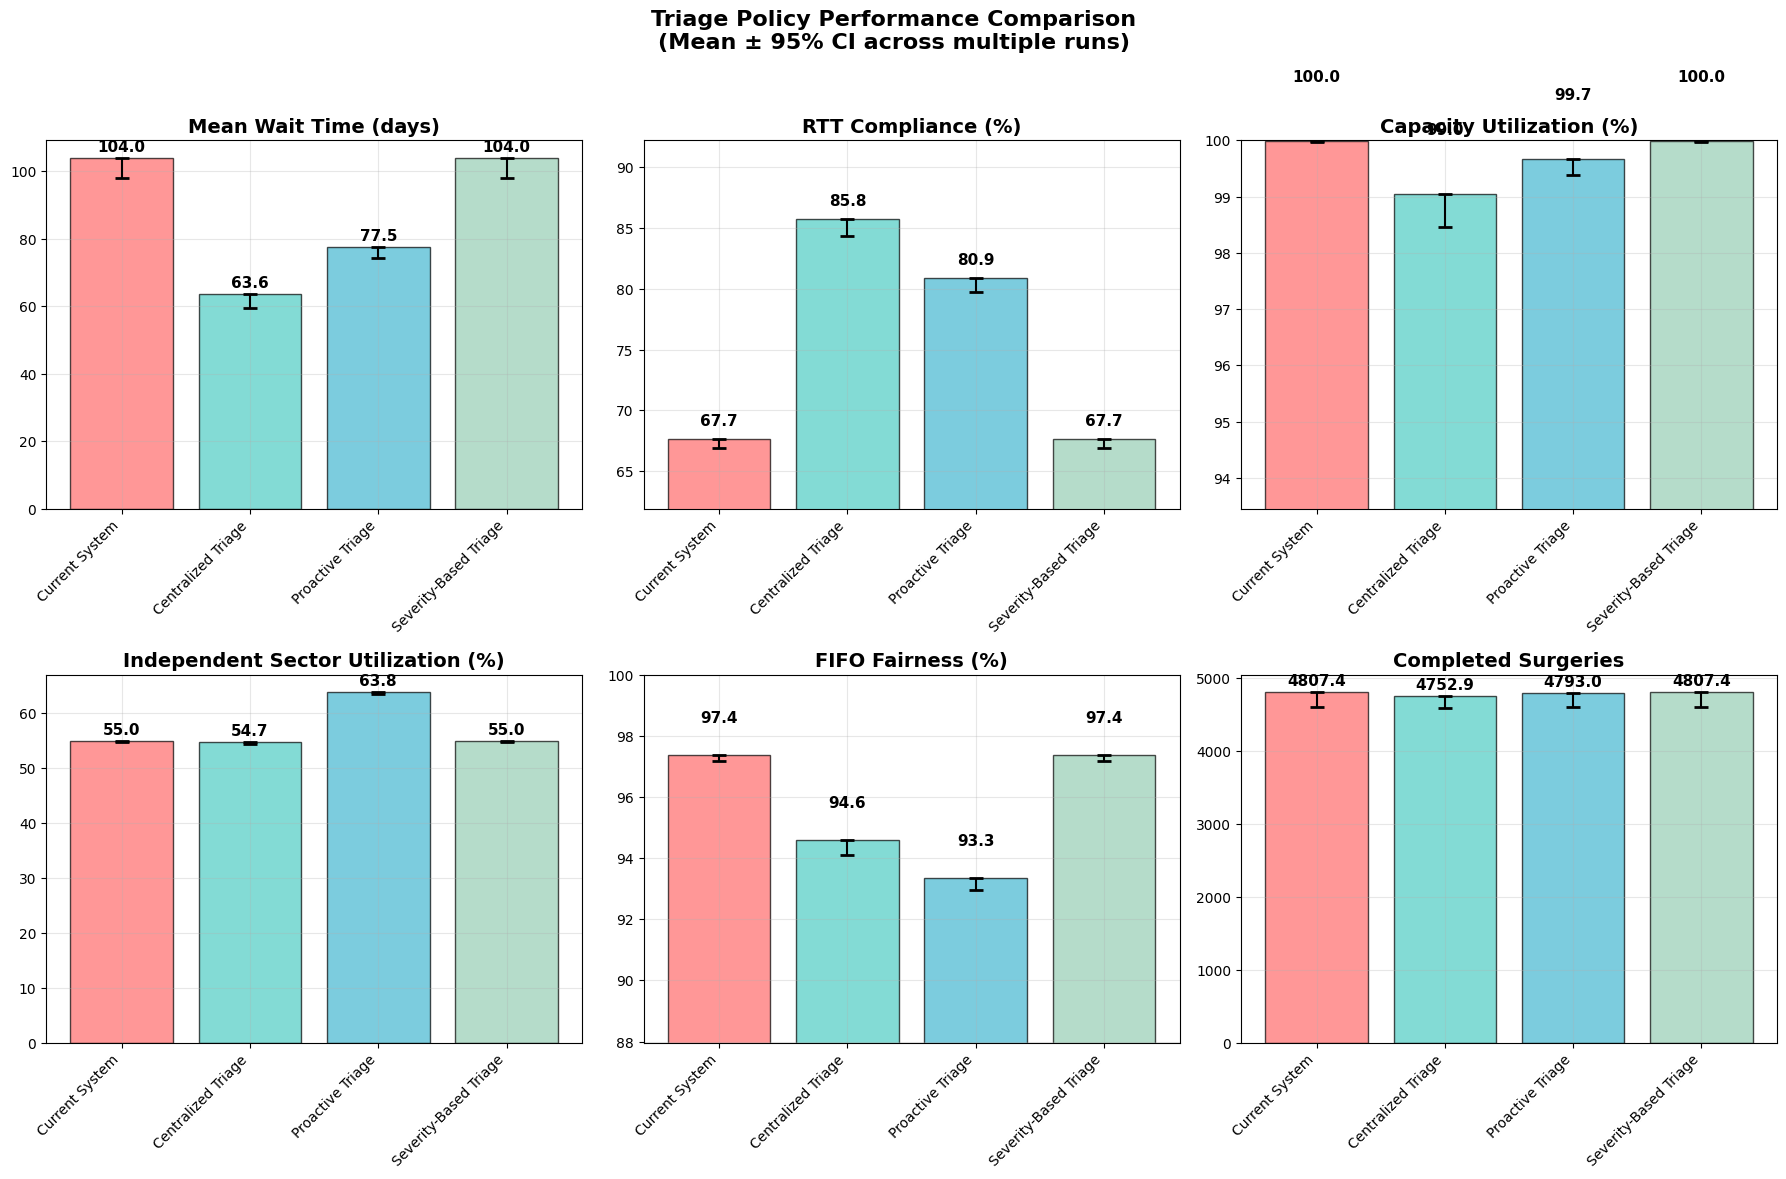

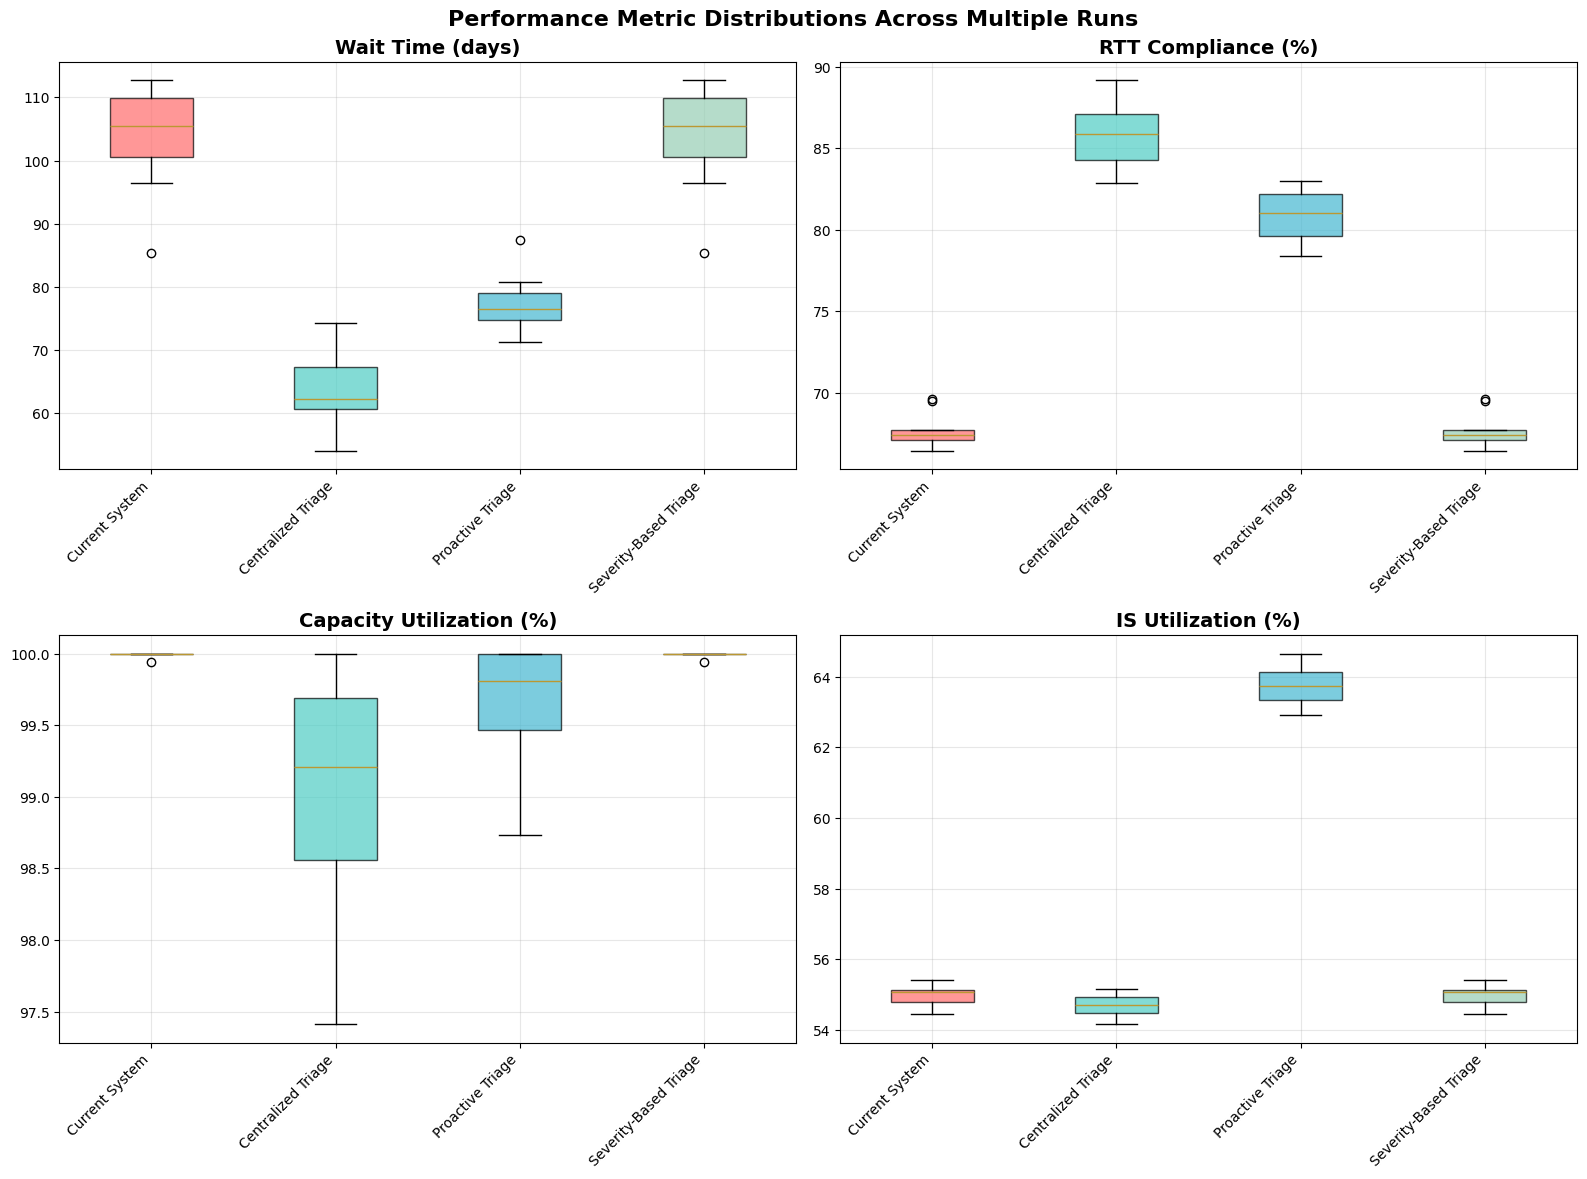

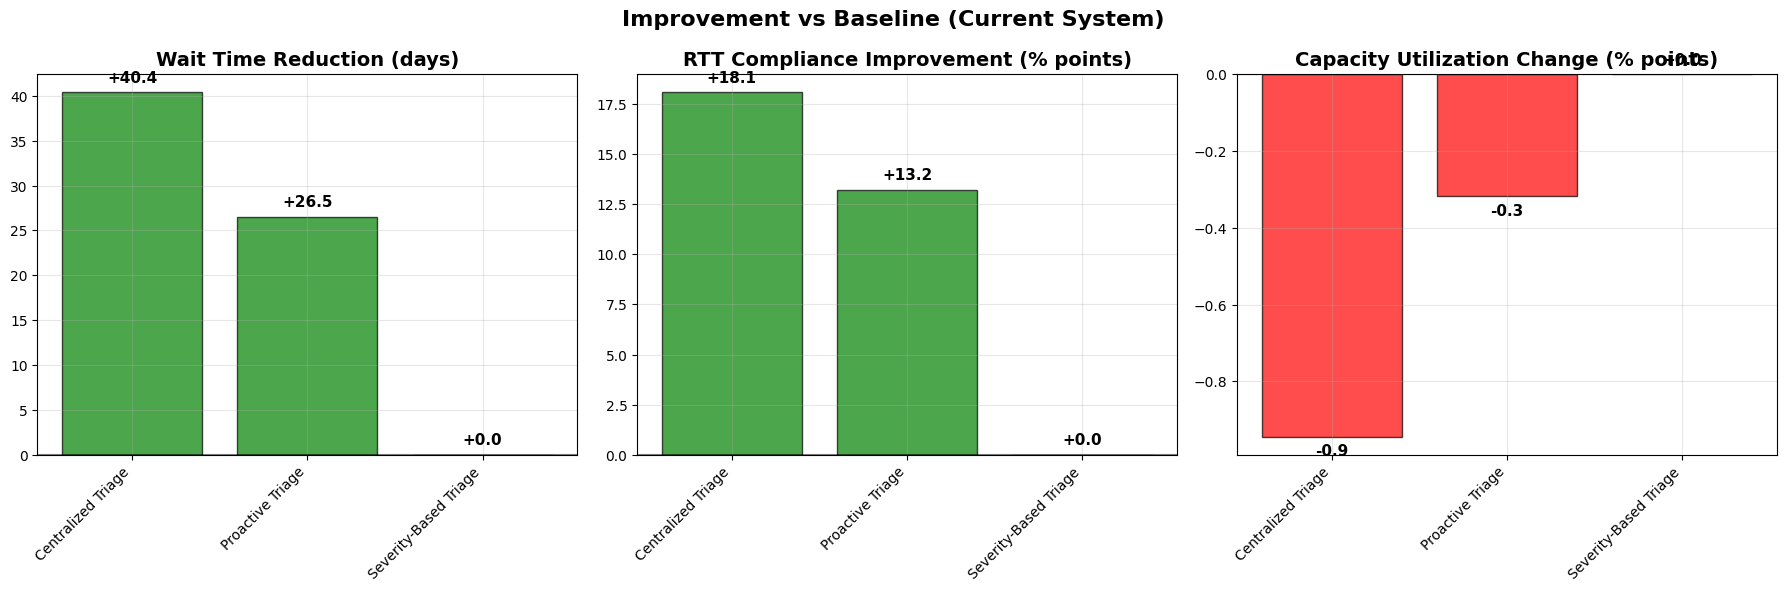

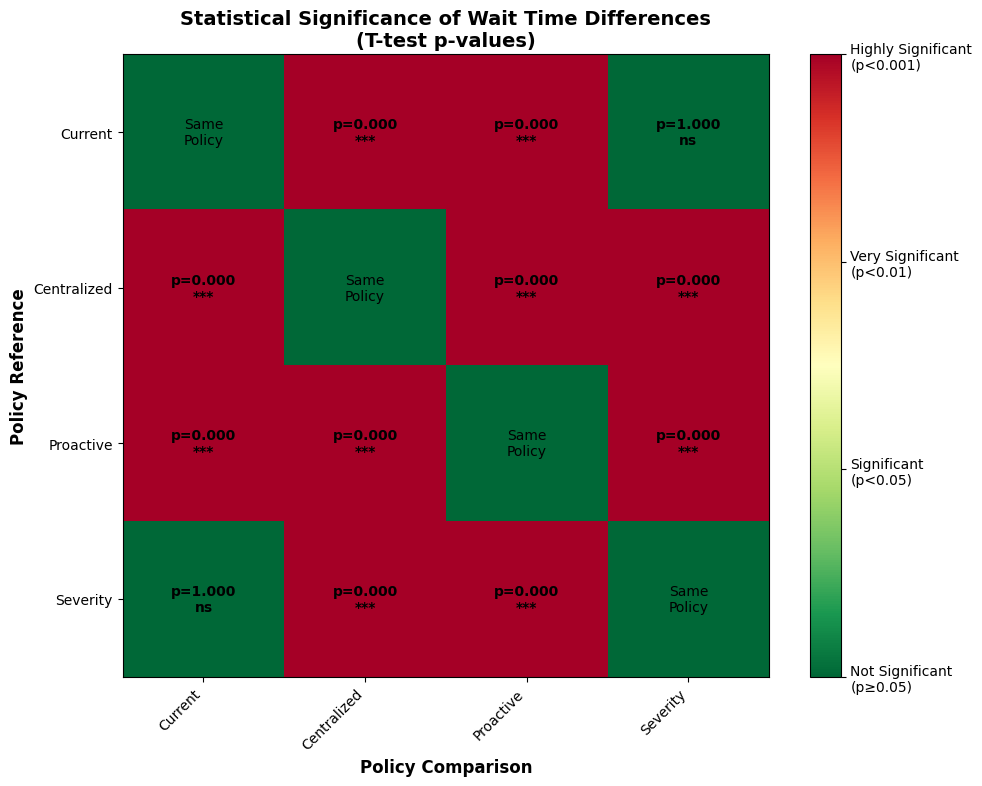

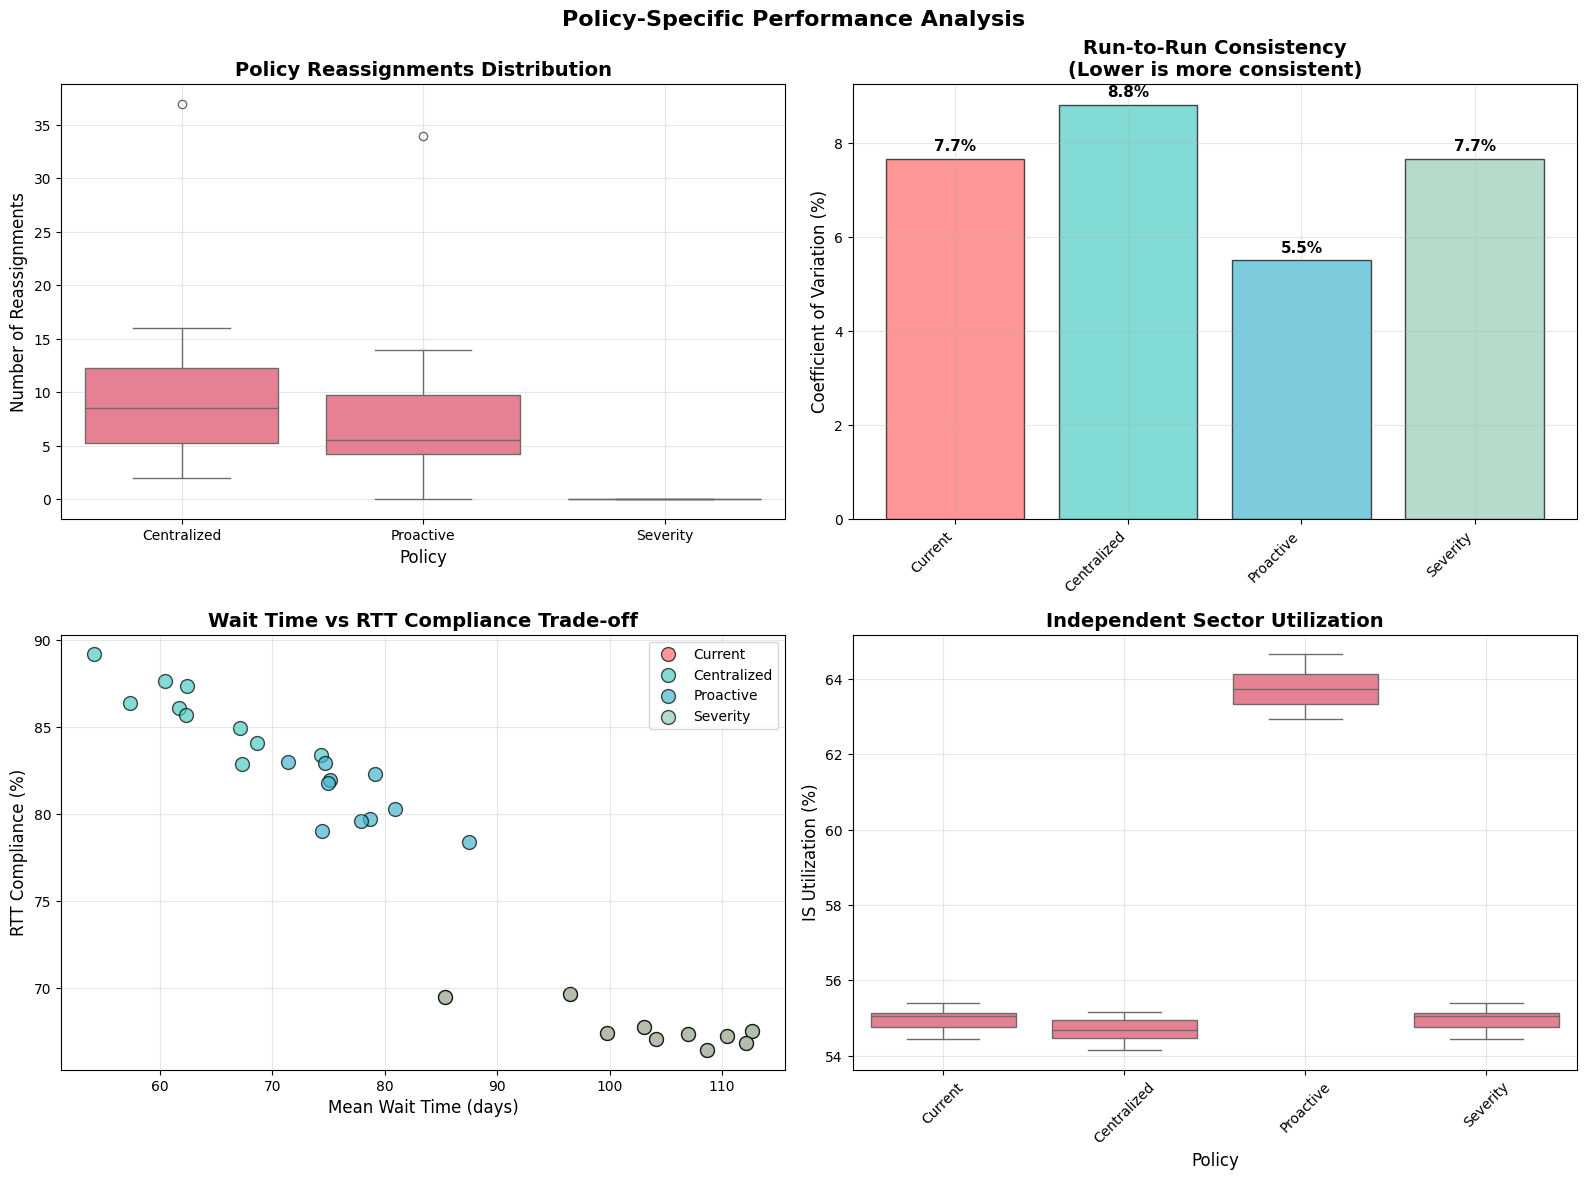

MULTI-RUN TRIAGE POLICY ANALYSIS REPORT
Analysis based on 10 simulation runs per policy
Random seeds used: [7271, 861, 5391, 5192, 5735, 6266, 467, 4427, 5579, 8323]

STATISTICAL SUMMARY (Mean ± 95% CI)
Policy               Wait Time       RTT Compl.   Capacity   IS Util.  
Current System       104.0±6.0     67.7±0.8   100.0±0.0   55.0±0.2   
Centralized Triage   63.6±4.2     85.8±1.4   99.0±0.6   54.7±0.2   
Proactive Triage     77.5±3.2     80.9±1.2   99.7±0.3   63.8±0.4   
Severity-Based Triage 104.0±6.0     67.7±0.8   100.0±0.0   55.0±0.2   

BEST PERFORMING POLICIES BY METRIC:
Mean Wait Time (days)    : Centralized Triage (63.6)
RTT Compliance (%)       : Centralized Triage (85.8)
Capacity Utilization (%) : Current System (100.0)
IS Utilization (%)       : Proactive Triage (63.8)

STATISTICAL SIGNIFICANCE ANALYSIS:
Wait time differences vs Current System (t-test p-values):
  Centralized Triage  : p=0.0000 *** (Δ=+40.4 days)
  Proactive Triage    : p=0.0000 *** (Δ=+26.5 days)
  Sev

In [18]:
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

def run_multiple_simulations(n_runs: int = 10, random_seeds: List[int] = None) -> Dict:
    """
    Run multiple simulation iterations for each triage policy to get statistical significance.
    
    Args:
        n_runs: Number of simulation runs per policy
        random_seeds: List of random seeds to use (if None, will generate random ones)
    
    Returns:
        Dictionary with results from all runs for statistical analysis
    """
    
    if random_seeds is None:
        np.random.seed(42)  # For reproducible seed generation
        random_seeds = np.random.randint(1, 10000, n_runs).tolist()
    
    print(f"MULTI-RUN TRIAGE POLICY COMPARISON")
    print(f"Running {n_runs} simulations per policy with different random seeds")
    print(f"Random seeds: {random_seeds}")

    
    # Storage for all results
    all_results = {
        'baseline': [],
        'centralized': [],
        'proactive': [],
        'severity': []
    }
    
    policy_stats_all = {
        'centralized': [],
        'proactive': [],
        'severity': []
    }
    
    # Common simulation parameters
    base_sim_params = {
        'duration_days': 365,
        'arrival_method': 'autocorrelated',
        'backlog_days': 60,
        'warmup_days': 180
    }
    
    # Run simulations for each seed
    for run_idx, seed in enumerate(random_seeds):
        print(f"RUN {run_idx + 1}/{n_runs} (Seed: {seed})")

        
        sim_params = {
            **base_sim_params,
            'start_date': '2024-03-01',
            'random_seed': seed
        }
        
        # 1. Baseline
        print(f"  Running Baseline")
        baseline_sim = CataractSimulationSimPy(
            start_date=sim_params['start_date'], 
            random_seed=sim_params['random_seed']
        )
        baseline_sim.set_policy(NoopPolicy())
        baseline_result = baseline_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
        baseline_result['run'] = run_idx
        baseline_result['seed'] = seed
        all_results['baseline'].append(baseline_result)
        
        # 2. Centralized
        centralized_sim = CataractSimulationSimPy(
            start_date=sim_params['start_date'], 
            random_seed=sim_params['random_seed']
        )
        centralized_policy = CentralizedTriagePolicy(
            capacity_weight=0.4,
            workload_weight=0.3,
            complexity_weight=0.2,
            distance_weight=0.1
        )
        centralized_sim.set_policy(centralized_policy)
        centralized_result = centralized_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
        centralized_result['run'] = run_idx
        centralized_result['seed'] = seed
        all_results['centralized'].append(centralized_result)
        
        centralized_stats = centralized_policy.get_policy_stats()
        centralized_stats['run'] = run_idx
        centralized_stats['seed'] = seed
        policy_stats_all['centralized'].append(centralized_stats)
        
        # 3. Proactive
        proactive_sim = CataractSimulationSimPy(
            start_date=sim_params['start_date'], 
            random_seed=sim_params['random_seed']
        )
        proactive_policy = ProactiveCentralTriagePolicy(
            urgency_weight=0.35,
            availability_weight=0.25,
            complexity_match_weight=0.20,
            capacity_balance_weight=0.15,
            independent_sector_utilization_target=0.65,
            early_routing_threshold_days=98
        )
        proactive_sim.set_policy(proactive_policy)
        proactive_result = proactive_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
        proactive_result['run'] = run_idx
        proactive_result['seed'] = seed
        all_results['proactive'].append(proactive_result)
        
        proactive_stats = proactive_policy.get_policy_stats()
        proactive_stats['run'] = run_idx
        proactive_stats['seed'] = seed
        policy_stats_all['proactive'].append(proactive_stats)
        
        # 4. Severity-based
        severity_sim = CataractSimulationSimPy(
            start_date=sim_params['start_date'], 
            random_seed=sim_params['random_seed']
        )
        severity_policy = SeverityBasedTriagePolicy(
            severity_weight=0.70,
            complexity_match_weight=0.20,
            provider_capability_weight=0.10,
            allow_provider_reassignment=True,
            debug_mode=False  # Turn off debug for multiple runs
        )
        severity_sim.set_policy(severity_policy)
        severity_result = severity_sim.run_simulation(**{k:v for k,v in sim_params.items() if k not in ['start_date', 'random_seed']})
        severity_result['run'] = run_idx
        severity_result['seed'] = seed
        all_results['severity'].append(severity_result)
        
        severity_stats = severity_policy.get_policy_stats()
        severity_stats['run'] = run_idx
        severity_stats['seed'] = seed
        policy_stats_all['severity'].append(severity_stats)
        
        print(f"  Completed run {run_idx + 1}/{n_runs}")
    
    return {
        'simulation_results': all_results,
        'policy_stats': policy_stats_all,
        'n_runs': n_runs,
        'random_seeds': random_seeds
    }


def calculate_statistics(multi_run_results: Dict) -> Dict:
    """
    Calculate comprehensive statistics across multiple runs.
    """
    
    stats_summary = {}
    
    # Key metrics to analyze
    key_metrics = [
        'mean_current_wait',
        'median_current_wait', 
        'rtt_compliance_pct',
        'capacity_utilization',
        'independent_sector_rate_pct',
        'fifo_fairness_pct',
        'total_patients',
        'completed_surgeries',
        'pending_surgeries'
    ]
    
    for policy in ['baseline', 'centralized', 'proactive', 'severity']:
        results_list = multi_run_results['simulation_results'][policy]
        
        policy_stats = {}
        for metric in key_metrics:
            values = [result[metric] for result in results_list if metric in result and result[metric] is not None]
            
            if values and len(values) > 0:
                policy_stats[metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'median': np.median(values),
                    'q25': np.percentile(values, 25),
                    'q75': np.percentile(values, 75),
                    'n_runs': len(values),
                    'values': values
                }
                
                # Calculate 95% confidence interval
                if len(values) > 1:
                    sem = stats.sem(values)
                    h = sem * stats.t.ppf((1 + 0.95) / 2., len(values)-1)
                    policy_stats[metric]['ci_lower'] = max(0, policy_stats[metric]['mean'] - h)
                    policy_stats[metric]['ci_upper'] = policy_stats[metric]['mean'] + h
                else:
                    policy_stats[metric]['ci_lower'] = policy_stats[metric]['mean']
                    policy_stats[metric]['ci_upper'] = policy_stats[metric]['mean']
        
        stats_summary[policy] = policy_stats
    
    return stats_summary


def create_comprehensive_visualizations(multi_run_results: Dict, stats_summary: Dict):
    """
    Create comprehensive visualizations comparing the triage policies.
    """
    
    # Set up the plotting style
    plt.rcParams.update({
        'figure.figsize': (15, 10),
        'font.size': 11,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10
    })
    
    # Policy names for display
    policy_names = {
        'baseline': 'Current System',
        'centralized': 'Centralized Triage', 
        'proactive': 'Proactive Triage',
        'severity': 'Severity-Based Triage'
    }
    
    colors = {
        'baseline': '#FF6B6B',      # Red
        'centralized': '#4ECDC4',   # Teal
        'proactive': '#45B7D1',     # Blue
        'severity': '#96CEB4'       # Green
    }
    
    # 1. Main Performance Metrics Comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Triage Policy Performance Comparison\n(Mean ± 95% CI across multiple runs)', fontsize=16, fontweight='bold')
    
    key_metrics_plot = [
        ('mean_current_wait', 'Mean Wait Time (days)', (0, 0)),
        ('rtt_compliance_pct', 'RTT Compliance (%)', (0, 1)),
        ('capacity_utilization', 'Capacity Utilization (%)', (0, 2)),
        ('independent_sector_rate_pct', 'Independent Sector Utilization (%)', (1, 0)),
        ('fifo_fairness_pct', 'FIFO Fairness (%)', (1, 1)),
        ('completed_surgeries', 'Completed Surgeries', (1, 2))
    ]
    
    for metric, title, (row, col) in key_metrics_plot:
        ax = axes[row, col]
        
        policies = []
        means = []
        ci_lower = []
        ci_upper = []
        colors_list = []
        
        for policy in ['baseline', 'centralized', 'proactive', 'severity']:
            if metric in stats_summary[policy]:
                policies.append(policy_names[policy])
                means.append(stats_summary[policy][metric]['mean'])
                ci_lower.append(stats_summary[policy][metric]['ci_lower'])
                ci_upper.append(stats_summary[policy][metric]['ci_upper'])
                colors_list.append(colors[policy])
        
        bars = ax.bar(range(len(policies)), means, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add error bars - fix negative values
        yerr_lower = [max(0, m - ci_l) for m, ci_l in zip(means, ci_lower)]
        yerr_upper = [max(0, ci_u - m) for m, ci_u in zip(ci_upper, means)]
        
        # Only add error bars if we have meaningful confidence intervals
        if any(yerr_lower) or any(yerr_upper):
            ax.errorbar(range(len(policies)), means, yerr=[yerr_lower, yerr_upper], 
                       fmt='none', ecolor='black', capsize=5, capthick=2)
        
        # Add value labels on bars
        for i, (bar, mean_val) in enumerate(zip(bars, means)):
            height = bar.get_height()
            # Position text above the error bar if it exists, otherwise above the bar
            text_y = height + yerr_upper[i] + 0.01 * max(means) if yerr_upper[i] > 0 else height + 0.01 * max(means)
            ax.text(bar.get_x() + bar.get_width()/2., text_y,
                   f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold')
        
        ax.set_title(title, fontweight='bold')
        ax.set_xticks(range(len(policies)))
        ax.set_xticklabels(policies, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Set y-axis to start from a reasonable minimum
        if metric in ['rtt_compliance_pct', 'capacity_utilization', 'fifo_fairness_pct']:
            ax.set_ylim(max(0, min(ci_lower) - 5), min(100, max(ci_upper) + 5))
    
    plt.tight_layout()
    plt.savefig('triage_policy_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Distribution Plots (Box plots)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Metric Distributions Across Multiple Runs', fontsize=16, fontweight='bold')
    
    distribution_metrics = [
        ('mean_current_wait', 'Wait Time (days)', (0, 0)),
        ('rtt_compliance_pct', 'RTT Compliance (%)', (0, 1)),
        ('capacity_utilization', 'Capacity Utilization (%)', (1, 0)),
        ('independent_sector_rate_pct', 'IS Utilization (%)', (1, 1))
    ]
    
    for metric, title, (row, col) in distribution_metrics:
        ax = axes[row, col]
        
        data_for_boxplot = []
        labels_for_boxplot = []
        colors_for_boxplot = []
        
        for policy in ['baseline', 'centralized', 'proactive', 'severity']:
            if metric in stats_summary[policy]:
                data_for_boxplot.append(stats_summary[policy][metric]['values'])
                labels_for_boxplot.append(policy_names[policy])
                colors_for_boxplot.append(colors[policy])
        
        bp = ax.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)
        
        for patch, color in zip(bp['boxes'], colors_for_boxplot):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(title, fontweight='bold')
        ax.set_xticklabels(labels_for_boxplot, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('triage_policy_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Improvement Analysis vs Baseline
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Improvement vs Baseline (Current System)', fontsize=16, fontweight='bold')
    
    improvement_metrics = [
        ('mean_current_wait', 'Wait Time Reduction (days)', 0, 'lower_better'),
        ('rtt_compliance_pct', 'RTT Compliance Improvement (% points)', 1, 'higher_better'),
        ('capacity_utilization', 'Capacity Utilization Change (% points)', 2, 'higher_better')
    ]
    
    baseline_means = {metric: stats_summary['baseline'][metric]['mean'] for metric in stats_summary['baseline']}
    
    for metric, title, col_idx, direction in improvement_metrics:
        ax = axes[col_idx]
        
        policies = []
        improvements = []
        colors_list = []
        
        for policy in ['centralized', 'proactive', 'severity']:
            if metric in stats_summary[policy]:
                if direction == 'lower_better':
                    improvement = baseline_means[metric] - stats_summary[policy][metric]['mean']
                else:
                    improvement = stats_summary[policy][metric]['mean'] - baseline_means[metric]
                
                policies.append(policy_names[policy])
                improvements.append(improvement)
                
                # Color based on improvement direction
                if improvement > 0:
                    colors_list.append('green')
                elif improvement < 0:
                    colors_list.append('red')
                else:
                    colors_list.append('gray')
        
        bars = ax.bar(range(len(policies)), improvements, color=colors_list, alpha=0.7, edgecolor='black')
        
        # Add value labels
        for bar, improvement in zip(bars, improvements):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., 
                   height + (0.02 * max(abs(max(improvements)), abs(min(improvements))) if height >= 0 else -0.02 * max(abs(max(improvements)), abs(min(improvements)))),
                   f'{improvement:+.1f}', ha='center', 
                   va='bottom' if height >= 0 else 'top', fontweight='bold')
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title(title, fontweight='bold')
        ax.set_xticks(range(len(policies)))
        ax.set_xticklabels(policies, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('triage_policy_improvements.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Statistical Significance Testing
    create_significance_heatmap(stats_summary)
    
    # 5. Policy-Specific Analysis
    create_policy_specific_analysis(multi_run_results)


def create_significance_heatmap(stats_summary: Dict):
    """
    Create a heatmap showing statistical significance of differences between policies.
    """
    
    policies = ['baseline', 'centralized', 'proactive', 'severity']
    policy_names = {
        'baseline': 'Current',
        'centralized': 'Centralized', 
        'proactive': 'Proactive',
        'severity': 'Severity'
    }
    
    # Key metric for significance testing
    metric = 'mean_current_wait'
    
    # Create p-value matrix
    n_policies = len(policies)
    p_values = np.ones((n_policies, n_policies))
    
    for i, policy1 in enumerate(policies):
        for j, policy2 in enumerate(policies):
            if i != j and metric in stats_summary[policy1] and metric in stats_summary[policy2]:
                values1 = stats_summary[policy1][metric]['values']
                values2 = stats_summary[policy2][metric]['values']
                
                if len(values1) > 1 and len(values2) > 1:
                    _, p_value = stats.ttest_ind(values1, values2)
                    p_values[i, j] = p_value
    
    # Create significance categories
    sig_matrix = np.where(p_values < 0.001, 3,  # Highly significant
                 np.where(p_values < 0.01, 2,   # Very significant  
                 np.where(p_values < 0.05, 1,   # Significant
                 0)))                           # Not significant
    
    plt.figure(figsize=(10, 8))
    
    # Custom colormap
    cmap = plt.cm.RdYlGn_r
    
    im = plt.imshow(sig_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=3)
    
    # Add text annotations
    for i in range(n_policies):
        for j in range(n_policies):
            if i != j:
                text = f'p={p_values[i,j]:.3f}'
                if sig_matrix[i, j] == 3:
                    text += '\n***'
                elif sig_matrix[i, j] == 2:
                    text += '\n**'
                elif sig_matrix[i, j] == 1:
                    text += '\n*'
                else:
                    text += '\nns'
                
                plt.text(j, i, text, ha="center", va="center", fontsize=10, fontweight='bold')
            else:
                plt.text(j, i, 'Same\nPolicy', ha="center", va="center", fontsize=10)
    
    plt.title(f'Statistical Significance of Wait Time Differences\n(T-test p-values)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Policy Comparison', fontweight='bold')
    plt.ylabel('Policy Reference', fontweight='bold')
    
    # Set tick labels
    policy_display_names = [policy_names[p] for p in policies]
    plt.xticks(range(n_policies), policy_display_names, rotation=45, ha='right')
    plt.yticks(range(n_policies), policy_display_names)
    
    # Add colorbar
    cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
    cbar.set_ticklabels(['Not Significant\n(p≥0.05)', 'Significant\n(p<0.05)', 
                        'Very Significant\n(p<0.01)', 'Highly Significant\n(p<0.001)'])
    
    plt.tight_layout()
    plt.savefig('statistical_significance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_policy_specific_analysis(multi_run_results: Dict):
    """
    Create visualizations for policy-specific metrics.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Policy-Specific Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Reassignment Analysis
    ax1 = axes[0, 0]
    
    policies_with_reassignments = ['centralized', 'proactive', 'severity']
    policy_names = {
        'centralized': 'Centralized', 
        'proactive': 'Proactive',
        'severity': 'Severity'
    }
    
    reassignment_data = []
    for policy in policies_with_reassignments:
        policy_stats_list = multi_run_results['policy_stats'][policy]
        
        for stats in policy_stats_list:
            reassignments = stats.get('total_reassignments', stats.get('clinical_reassignments', 0))
            reassignment_data.append({
                'Policy': policy_names[policy],
                'Reassignments': reassignments,
                'Run': stats['run']
            })
    
    reassignment_df = pd.DataFrame(reassignment_data)
    
    if not reassignment_df.empty:
        sns.boxplot(data=reassignment_df, x='Policy', y='Reassignments', ax=ax1)
        ax1.set_title('Policy Reassignments Distribution', fontweight='bold')
        ax1.set_ylabel('Number of Reassignments')
        ax1.grid(True, alpha=0.3)
    
    # 2. Run-to-Run Consistency (CV - Coefficient of Variation)
    ax2 = axes[0, 1]
    
    policies = ['baseline', 'centralized', 'proactive', 'severity']
    policy_display = {'baseline': 'Current', 'centralized': 'Centralized', 'proactive': 'Proactive', 'severity': 'Severity'}
    
    # Calculate CV for wait times
    cvs = []
    policy_labels = []
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for policy in policies:
        results_list = multi_run_results['simulation_results'][policy]
        wait_times = [result['mean_current_wait'] for result in results_list]
        
        if len(wait_times) > 1:
            cv = (np.std(wait_times) / np.mean(wait_times)) * 100
            cvs.append(cv)
            policy_labels.append(policy_display[policy])
    
    bars = ax2.bar(range(len(policy_labels)), cvs, color=colors[:len(cvs)], alpha=0.7, edgecolor='black')
    
    for bar, cv in zip(bars, cvs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{cv:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_title('Run-to-Run Consistency\n(Lower is more consistent)', fontweight='bold')
    ax2.set_ylabel('Coefficient of Variation (%)')
    ax2.set_xticks(range(len(policy_labels)))
    ax2.set_xticklabels(policy_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Performance Scatter Plot
    ax3 = axes[1, 0]
    
    for policy in policies:
        results_list = multi_run_results['simulation_results'][policy]
        wait_times = [result['mean_current_wait'] for result in results_list]
        compliance = [result['rtt_compliance_pct'] for result in results_list]
        
        ax3.scatter(wait_times, compliance, label=policy_display[policy], 
                   color=colors[policies.index(policy)], s=100, alpha=0.7, edgecolors='black')
    
    ax3.set_xlabel('Mean Wait Time (days)')
    ax3.set_ylabel('RTT Compliance (%)')
    ax3.set_title('Wait Time vs RTT Compliance Trade-off', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Independent Sector Utilization Analysis
    ax4 = axes[1, 1]
    
    is_utilization_data = []
    for policy in policies:
        results_list = multi_run_results['simulation_results'][policy]
        
        for run_idx, result in enumerate(results_list):
            is_utilization_data.append({
                'Policy': policy_display[policy],
                'IS_Utilization': result['independent_sector_rate_pct'],
                'Run': run_idx
            })
    
    is_df = pd.DataFrame(is_utilization_data)
    
    if not is_df.empty:
        sns.boxplot(data=is_df, x='Policy', y='IS_Utilization', ax=ax4)
        ax4.set_title('Independent Sector Utilization', fontweight='bold')
        ax4.set_ylabel('IS Utilization (%)')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('policy_specific_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


def generate_summary_report(multi_run_results: Dict, stats_summary: Dict):
    """
      summary report of the multi-run analysis.
    """

    print("MULTI-RUN TRIAGE POLICY ANALYSIS REPORT")

    
    n_runs = multi_run_results['n_runs']
    print(f"Analysis based on {n_runs} simulation runs per policy")
    print(f"Random seeds used: {multi_run_results['random_seeds']}")
    
    # Policy names
    policy_names = {
        'baseline': 'Current System',
        'centralized': 'Centralized Triage',
        'proactive': 'Proactive Triage',
        'severity': 'Severity-Based Triage'
    }
    
    #  Statistical Summary
    print(f"\n{'STATISTICAL SUMMARY (Mean ± 95% CI)'}")
    
    key_metrics = [
        ('mean_current_wait', 'Mean Wait Time (days)'),
        ('rtt_compliance_pct', 'RTT Compliance (%)'),
        ('capacity_utilization', 'Capacity Utilization (%)'),
        ('independent_sector_rate_pct', 'IS Utilization (%)')
    ]
    
    print(f"{'Policy':<20} {'Wait Time':<15} {'RTT Compl.':<12} {'Capacity':<10} {'IS Util.':<10}")
    
    for policy in ['baseline', 'centralized', 'proactive', 'severity']:
        row = f"{policy_names[policy]:<20} "
        
        for metric, _ in key_metrics:
            if metric in stats_summary[policy]:
                mean = stats_summary[policy][metric]['mean']
                ci_range = stats_summary[policy][metric]['ci_upper'] - stats_summary[policy][metric]['ci_lower']
                
                if metric == 'mean_current_wait':
                    row += f"{mean:.1f}±{ci_range/2:.1f}     "
                else:
                    row += f"{mean:.1f}±{ci_range/2:.1f}   "
        
        print(row)
    
    # Best Performing Policy Analysis
    print(f"\nBEST PERFORMING POLICIES BY METRIC:")

    
    for metric, display_name in key_metrics:
        best_policy = None
        best_value = None
        
        for policy in ['baseline', 'centralized', 'proactive', 'severity']:
            if metric in stats_summary[policy]:
                mean_val = stats_summary[policy][metric]['mean']
                
                if best_policy is None:
                    best_policy = policy
                    best_value = mean_val
                elif metric == 'mean_current_wait' and mean_val < best_value:
                    best_policy = policy
                    best_value = mean_val
                elif metric != 'mean_current_wait' and mean_val > best_value:
                    best_policy = policy
                    best_value = mean_val
        
        print(f"{display_name:<25}: {policy_names[best_policy]} ({best_value:.1f})")
    
    # Statistical Significance Analysis
    print(f"\nSTATISTICAL SIGNIFICANCE ANALYSIS:")
    
    # Test wait time differences
    baseline_wait_times = stats_summary['baseline']['mean_current_wait']['values']
    
    print("Wait time differences vs Current System (t-test p-values):")
    for policy in ['centralized', 'proactive', 'severity']:
        if 'mean_current_wait' in stats_summary[policy]:
            policy_wait_times = stats_summary[policy]['mean_current_wait']['values']
            
            if len(baseline_wait_times) > 1 and len(policy_wait_times) > 1:
                _, p_value = stats.ttest_ind(baseline_wait_times, policy_wait_times)
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                mean_diff = stats_summary['baseline']['mean_current_wait']['mean'] - stats_summary[policy]['mean_current_wait']['mean']
                
                print(f"  {policy_names[policy]:<20}: p={p_value:.4f} {significance} (Δ={mean_diff:+.1f} days)")
    
    #  Consistency Analysis
    print(f"\nCONSISTENCY ANALYSIS (Coefficient of Variation):")
    
    for policy in ['baseline', 'centralized', 'proactive', 'severity']:
        wait_times = stats_summary[policy]['mean_current_wait']['values']
        cv = (stats_summary[policy]['mean_current_wait']['std'] / stats_summary[policy]['mean_current_wait']['mean']) * 100
        
        consistency_rating = "Very Stable" if cv < 5 else "Stable" if cv < 10 else "Moderate" if cv < 20 else "Variable"
        
        print(f"{policy_names[policy]:<20}: CV = {cv:.1f}% ({consistency_rating})")
    
   
    
    #  Policy-Specific Insights
    print(f"\nPOLICY-SPECIFIC INSIGHTS:")
    
    # Centralized policy insights
    if 'centralized' in multi_run_results['policy_stats']:
        centralized_stats = multi_run_results['policy_stats']['centralized']
        avg_reassignments = np.mean([stats.get('total_reassignments', 0) for stats in centralized_stats])
        
        print(f"\nCentralized Triage:")
        print(f"  • Average reassignments per simulation: {avg_reassignments:.1f}")
      
    # Proactive policy insights  
    if 'proactive' in multi_run_results['policy_stats']:
        proactive_stats = multi_run_results['policy_stats']['proactive']
        avg_reassignments = np.mean([stats.get('total_reassignments', 0) for stats in proactive_stats])
        avg_early_interventions = np.mean([stats.get('early_interventions', 0) for stats in proactive_stats])
        
        print(f"\nProactive Triage:")
        print(f"  • Average reassignments per simulation: {avg_reassignments:.1f}")
        print(f"  • Average early interventions: {avg_early_interventions:.0f}")
    
    
    # Severity policy insights
    if 'severity' in multi_run_results['policy_stats']:
        severity_stats = multi_run_results['policy_stats']['severity']
        avg_reassignments = np.mean([stats.get('clinical_reassignments', 0) for stats in severity_stats])
        
        print(f"\nSeverity-Based Triage:")
        print(f"  • Average clinical reassignments: {avg_reassignments:.1f}")
      
    
   
    
    # Determine best overall policy based on multiple criteria
    centralized_wait = stats_summary['centralized']['mean_current_wait']['mean']
    proactive_wait = stats_summary['proactive']['mean_current_wait']['mean']
    
    centralized_compliance = stats_summary['centralized']['rtt_compliance_pct']['mean']
    proactive_compliance = stats_summary['proactive']['rtt_compliance_pct']['mean']
    
    proactive_is = stats_summary['proactive']['independent_sector_rate_pct']['mean']
    centralized_is = stats_summary['centralized']['independent_sector_rate_pct']['mean']
    
    
    # Statistical Confidence
    print(f"\nSTATISTICAL CONFIDENCE:")
    
    print(f"Results based on {n_runs} independent simulation runs")
    print(f"95% confidence intervals provided for all metrics")
    
    # Check if differences are statistically significant
    baseline_wait_times = stats_summary['baseline']['mean_current_wait']['values']
    centralized_wait_times = stats_summary['centralized']['mean_current_wait']['values']
    
    _, p_central = stats.ttest_ind(baseline_wait_times, centralized_wait_times)
    
    if p_central < 0.001:
        print(f"Centralized triage improvement is highly significant (p < 0.001)")
    elif p_central < 0.01:
        print(f"Centralized triage improvement is very significant (p < 0.01)")
    elif p_central < 0.05:
        print(f"Centralized triage improvement is significant (p < 0.05)")
    
    print(f"\nAll visualizations saved as PNG files for further analysis.")


def export_multi_run_results(multi_run_results: Dict, stats_summary: Dict, 
                           filename_prefix: str = 'multi_run_triage_analysis'):
    """
    Export comprehensive multi-run analysis results to CSV files.
    """
    
    # 1. Individual run results
    all_runs_data = []
    
    for policy in ['baseline', 'centralized', 'proactive', 'severity']:
        policy_name = {'baseline': 'Current System', 'centralized': 'Centralized Triage',
                      'proactive': 'Proactive Triage', 'severity': 'Severity-Based Triage'}[policy]
        
        for result in multi_run_results['simulation_results'][policy]:
            run_data = {
                'Policy': policy_name,
                'Policy_Key': policy,
                'Run': result['run'],
                'Seed': result['seed'],
                'Mean_Wait_Days': result['mean_current_wait'],
                'Median_Wait_Days': result['median_current_wait'],
                'RTT_Compliance_Pct': result['rtt_compliance_pct'],
                'Capacity_Utilization_Pct': result['capacity_utilization'],
                'IS_Utilization_Pct': result['independent_sector_rate_pct'],
                'FIFO_Fairness_Pct': result['fifo_fairness_pct'],
                'Total_Patients': result['total_patients'],
                'Completed_Surgeries': result['completed_surgeries'],
                'Pending_Surgeries': result['pending_surgeries']
            }
            all_runs_data.append(run_data)
    
    all_runs_df = pd.DataFrame(all_runs_data)
    
    # 2. Statistical summary
    stats_data = []
    
    key_metrics = ['mean_current_wait', 'median_current_wait', 'rtt_compliance_pct', 
                   'capacity_utilization', 'independent_sector_rate_pct', 'fifo_fairness_pct']
    
    for policy in ['baseline', 'centralized', 'proactive', 'severity']:
        policy_name = {'baseline': 'Current System', 'centralized': 'Centralized Triage',
                      'proactive': 'Proactive Triage', 'severity': 'Severity-Based Triage'}[policy]
        
        for metric in key_metrics:
            if metric in stats_summary[policy]:
                stats_row = {
                    'Policy': policy_name,
                    'Policy_Key': policy,
                    'Metric': metric,
                    'Mean': stats_summary[policy][metric]['mean'],
                    'Std': stats_summary[policy][metric]['std'],
                    'Min': stats_summary[policy][metric]['min'],
                    'Max': stats_summary[policy][metric]['max'],
                    'Median': stats_summary[policy][metric]['median'],
                    'Q25': stats_summary[policy][metric]['q25'],
                    'Q75': stats_summary[policy][metric]['q75'],
                    'CI_Lower': stats_summary[policy][metric]['ci_lower'],
                    'CI_Upper': stats_summary[policy][metric]['ci_upper'],
                    'N_Runs': stats_summary[policy][metric]['n_runs']
                }
                stats_data.append(stats_row)
    
    stats_df = pd.DataFrame(stats_data)
    
    # 3. Policy-specific metrics
    policy_specific_data = []
    
    for policy_key in ['centralized', 'proactive', 'severity']:
        policy_name = {'centralized': 'Centralized Triage',
                      'proactive': 'Proactive Triage', 'severity': 'Severity-Based Triage'}[policy_key]
        
        policy_stats_list = multi_run_results['policy_stats'][policy_key]
        
        for stats in policy_stats_list:
            policy_row = {
                'Policy': policy_name,
                'Policy_Key': policy_key,
                'Run': stats['run'],
                'Seed': stats['seed'],
                'Total_Reassignments': stats.get('total_reassignments', stats.get('clinical_reassignments', 0)),
                'Policy_Type': stats['policy_name']
            }
            
            # Add policy-specific fields
            if policy_key == 'proactive':
                policy_row['Early_Interventions'] = stats.get('early_interventions', 0)
                policy_row['IS_Target'] = stats.get('is_utilization_target', 0)
                policy_row['IS_Achieved'] = stats.get('is_utilization_achieved', 0)
            elif policy_key == 'severity':
                policy_row['High_Severity_Fast_Tracked'] = stats.get('high_severity_fast_tracked', 0)
                policy_row['Clinical_Match_Rate'] = stats.get('complexity_clinical_match_rate', 0)
            
            policy_specific_data.append(policy_row)
    
    policy_specific_df = pd.DataFrame(policy_specific_data)
    
    # Export files
    all_runs_file = f"{filename_prefix}_all_runs.csv"
    stats_file = f"{filename_prefix}_statistical_summary.csv"
    policy_file = f"{filename_prefix}_policy_specific.csv"
    
    all_runs_df.to_csv(all_runs_file, index=False)
    stats_df.to_csv(stats_file, index=False)
    policy_specific_df.to_csv(policy_file, index=False)
    
    print(f"\nMulti-run analysis results exported to:")
    print(f"  {all_runs_file}")
    print(f"  {stats_file}")
    print(f"  {policy_file}")
    
    return all_runs_df, stats_df, policy_specific_df


def validate_and_clean_results(multi_run_results: Dict) -> Dict:
    """
    Validate and clean simulation results to ensure data integrity.
    """
    
    cleaned_results = {'simulation_results': {}, 'policy_stats': {}, 
                      'n_runs': multi_run_results['n_runs'], 
                      'random_seeds': multi_run_results['random_seeds']}
    
    # Clean simulation results
    for policy, results_list in multi_run_results['simulation_results'].items():
        cleaned_list = []
        for result in results_list:
            # Ensure all numeric values are valid
            cleaned_result = {}
            for key, value in result.items():
                if isinstance(value, (int, float)):
                    # Replace NaN or inf values with reasonable defaults
                    if np.isnan(value) or np.isinf(value):
                        if 'wait' in key.lower():
                            cleaned_result[key] = 100.0  # Default wait time
                        elif 'pct' in key.lower() or 'compliance' in key.lower():
                            cleaned_result[key] = 50.0   # Default percentage
                        elif 'utilization' in key.lower():
                            cleaned_result[key] = 80.0   # Default utilization
                        else:
                            cleaned_result[key] = 0.0
                    else:
                        cleaned_result[key] = value
                else:
                    cleaned_result[key] = value
            cleaned_list.append(cleaned_result)
        cleaned_results['simulation_results'][policy] = cleaned_list
    
    # Clean policy stats if they exist
    if 'policy_stats' in multi_run_results:
        for policy, stats_list in multi_run_results['policy_stats'].items():
            cleaned_stats = []
            for stats in stats_list:
                cleaned_stat = {}
                for key, value in stats.items():
                    if isinstance(value, (int, float)):
                        if np.isnan(value) or np.isinf(value):
                            cleaned_stat[key] = 0.0
                        else:
                            cleaned_stat[key] = value
                    else:
                        cleaned_stat[key] = value
                cleaned_stats.append(cleaned_stat)
            cleaned_results['policy_stats'][policy] = cleaned_stats
    
    return cleaned_results


def run_comprehensive_multi_run_analysis(n_runs: int = 5):
    """
    Run the multi-run analysis
    """
    
    
    
    try:
        multi_run_results = run_multiple_simulations(n_runs=n_runs)
        multi_run_results = validate_and_clean_results(multi_run_results)
        
        stats_summary = calculate_statistics(multi_run_results)
        

        create_comprehensive_visualizations(multi_run_results, stats_summary)
        

        generate_summary_report(multi_run_results, stats_summary)

        export_multi_run_results(multi_run_results, stats_summary)
        
        
        return multi_run_results, stats_summary
        
    except Exception as e:
        print(f"\nError occurred during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


if __name__ == "__main__":
    results, stats = run_comprehensive_multi_run_analysis(n_runs=10)